<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/CHFUSD/CHFUSD_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CHFUSD=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  0.9485  0.9485  0.9302  0.9392     0.9392       0
2009-01-02  0.9393  0.9419  0.9226  0.9267     0.9267       0
2009-01-05  0.9336  0.9340  0.8998  0.9020     0.9020       0
2009-01-06  0.9020  0.9030  0.8870  0.8957     0.8957       0
2009-01-07  0.8957  0.9189  0.8931  0.9060     0.9060       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.0138  1.0147  1.0073  1.0141     1.0141       0
2018-12-27  1.0056  1.0157  1.0055  1.0057     1.0057       0
2018-12-28  1.0131  1.0213  1.0131  1.0133     1.0133       0
2018-12-31  1.0166  1.0175  1.0129  1.0167     1.0167       0
2019-01-01  1.0168  1.0193  1.0166  1.0168     1.0168       0

[2602 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2602.000000  2602.000000  2602.000000  2602.000000  2602.000000  2602.0
mean      1.035091     1.039342     1.030923     1.035119     1.035119     0.0
std       0.070219     0.070837     0.069902     0.070188     0.070188     0.0
min       0.841300     0.844500     0.817300     0.842600     0.842600     0.0
25%       1.002025     1.004750     0.998600     1.002125     1.002125     0.0
50%       1.034600     1.038350     1.030250     1.034650     1.034650     0.0
75%       1.077050     1.080675     1.072400     1.077100     1.077100     0.0
max       1.384100     1.392200     1.367800     1.383500     1.383500     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.8656  0.8696  0.8367  0.8426     0.8426   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.849811  0.849131 -0.874100  0.855262  0.856462  0.864643     0.85405     0.85540  0.874100  0.856863  0.854391  0.859430  0.857381  0.856863  0.856933  0.857991                0.872201                 0.856863                0.841524                0.879870                 0.856863                0.833855                0.887539                 0.856863                0.826186                0.895209                 0.856863                0.818516  0.856462  0.853115  0.857591                0.871801                 0.856462                0.841124                0.879470                 0.856462                0.833454                0.887139                 0.856462                0.825785                0.894808                 0.856462                0.818116   
2009-03-13  0.8425  0.8445  0.8381  0.8442     0.8442   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.849530  0.849141 -0.871108  0.850685  0.853737  0.864332     0.85405     0.85540  0.871108  0.856338  0.848566  0.859140  0.854567  0.856338  0.843400  0.857724                0.873027                 0.856338                0.839648                0.881371                 0.856338                0.831304                0.889716                 0.856338                0.822959                0.898060                 0.856338                0.814615  0.853737  0.846101  0.857353                0.870426                 0.853737                0.837048                0.878771                 0.853737                0.828703                0.887116                 0.853737                0.820359                0.895460                 0.853737                0.812014   
2009-03-16  0.8413  0.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000    2552.000000   2552.000000     2552.000000     2552.000000       2552.000000  2552.000000  2552.000000  2552.000000  2552.000000   2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000  2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000  2552.000000  2552.000000  2552.000000             2552.000000              2552.000000             2552.000000             2552.000000              2552.000000             2552.000000             2552.000000   
mean      1.038248     1.042442     1.034154     1.038284     1.038284    15.755878     1.999608   185.952194      30.467085      0.032915        0.966693        0.010972          0.989028     6.616771     2.537226    27.012539     1.999608      1.999216    27.012539     1.038117     1.037633     0.013970     1.038283     1.038075     1.038560     1.038185     1.038595     1.039813     1.038075     1.038286     1.038076     1.038145     1.038075     1.038295     1.037660                1.051130                 1.038075                1.025019                1.057658                 1.038075                1.018492                1.064186                 1.038075                1.011964                1.070713                 1.038075                1.005436     1.038075     1.038258     1.037721                1.051130                 1.038075                1.025019                1.057658                 1.038075                1.018491                1.064186   
std       0.067062     0.067859     0.066561     0.067026     0.067026     8.801503     1.414906   104.339915       0.781809      0.178450        0.179473        0.104191          0.104191     3.411489     1.107415    14.920666     1.414906      1.414768    14.920666     0.066385     0.066205     1.041379     0.067169     0.066530     0.067970     0.066957     0.067558     0.071288     0.066771     0.067147     0.066890     0.066752     0.066771     0.066967     0.066532                0.070269                 0.066771                0.065164                0.072648                 0.066771                0.065120                0.075397                 0.066771                0.065587                0.078475                 0.066771                0.066556     0.066530     0.066870     0.066560                0.070062                 0.066530                0.064893                0.072459                 0.066530                0.064837                0.075224   
min       0.841300     0.844500     0.817300     0.842600     0.842600     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.044768  0.045828  0.035241  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.001386  0.000000  0.192174  0.016366  0.012191  0.004079    0.000000    0.000000  0.098800  0.005883  0.017653  0.015784  0.014802  0.005883  0.025209  0.003961                0.008412                 0.005883                0.041245                0.018232                 0.005883                0.093947                0.026710                 0.005883                0.217534                0.033955                 0.005883                0.314536  0.012191  0.015702  0.004017                0.005725                 0.012191                0.023878                0.015006                 0.012191                0.051327                0.024182                 0.012191                0.173210                0.031620                 0.012191   
2009-03-13  0.002211  0.000000  0.037784  0.002958   0.002958   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.000788  0.000023  0.193284  0.007571  0.006489  0.003436    0.000000    0.000000  0.093595  0.004775  0.006730  0.015185  0.009055  0.004775  0.000000  0.003346                0.009958                 0.004775                0.037004                0.020825                 0.004775                0.088374                0.030197                 0.004775                0.211493                0.038205                 0.004775                0.308184  0.006489  0.002403  0.003475                0.003139                 0.006489                0.014440                0.013769                 0.006489                0.040605                0.024143                 0.006489                0.162617                0.032615                 0.006489   
2009-03-16  0.000000  0.004199  0.040872  0.002958   0.002958   16          0         75

137798

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprrof8def
  JVM stdout: /tmp/tmprrof8def/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprrof8def/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_lh8efq
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.812500  0.535778              0.258578  0.424890  0.180531
1  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.798897  0.593501              0.239706  0.450347  0.202812
2  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.797212  0.604399              0.284804  0.456557  0.208444
3  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.785784  0.584273              0.273284  0.443689  0.196860
4  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.779167  0.690091              0.323529  0.462872  0.214250
5              DeepLearning_1_AutoML_20190822_120606  0.776103  0.647518              0.285784  0.449125  0.201714
6  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.758088  0.641625              0.362745  0.452928  0.205144
7  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.753125  0.601123              0.332843  0.456683  0.208559
8  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.750613  0.594971              0.320098  0.452384  0.204651
9  DeepLearning_grid_1_AutoML_20190822_120606_mod...  0.749877  1.486543              0.302941  0.529288  0.280146

variable  relative_importance  scaled_importance  percentage
0                CDLHANGINGMAN             1.000000           1.000000    0.003900
1             CDLDRAGONFLYDOJI             0.976158           0.976158    0.003807
2                    CDLTAKURI             0.965583           0.965583    0.003766
3               CDLEVENINGSTAR             0.901121           0.901121    0.003514
4           CDLEVENINGDOJISTAR             0.885377           0.885377    0.003453
...                        ...                  ...                ...         ...
1017                    WMA_12             0.188134           0.188134    0.000734
1018   BBANDS_upperband_24_3_3             0.187139           0.187139    0.000730
1019    BBANDS_upperband_8_0_2             0.181570           0.181570    0.000708
1020             CDLHIKKAKEMOD             0.181370           0.181370    0.000707
1021  BBANDS_middleband_20_0_4             0.181232           0.181232    0.000707

[1022 rows x 4 columns]

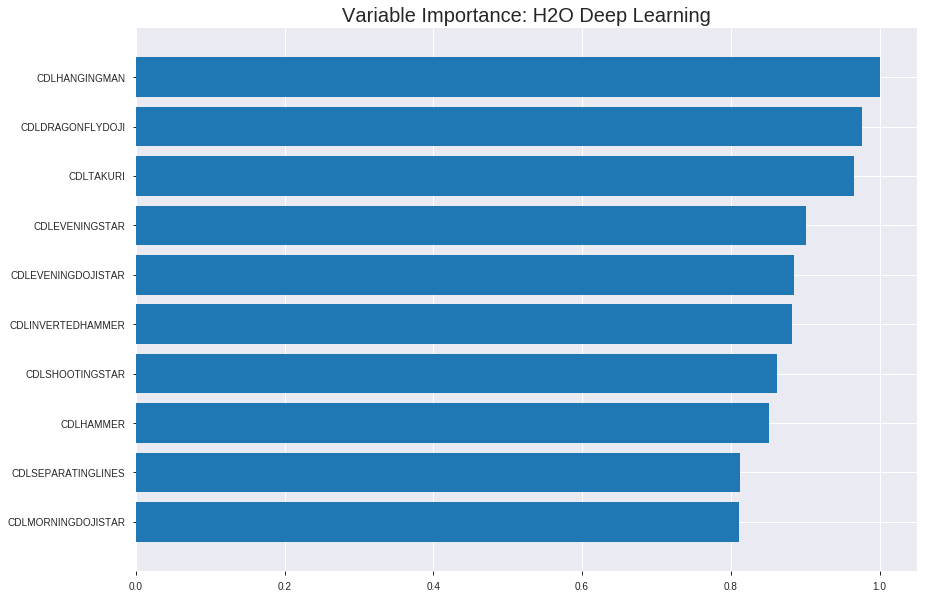

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_120606_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19218075488847006
RMSE: 0.438384254836405
LogLoss: 0.5929249868838453
Mean Per-Class Error: 0.2679586968802963
AUC: 0.8161364634988387
pr_auc: 0.7737903702886824
Gini: 0.6322729269976775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5474824502956744: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      515  375   0.4213   (375.0/890.0)
1      116  779   0.1296   (116.0/895.0)
Total  631  1154  0.2751   (491.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.547482     0.760371  219
max f2                       0.336363     0.869652  294
max f0point5                 0.811733     0.741275  103
max accuracy                 0.64069      0.732213  179
max precision                0.994439     0.947368  5
max recall                   0.00474802   1         395
max specificity              0.999814     0.996629  0
max absolute_mcc             0.547482     0.469652  219
max min_per_class_accuracy   0.700604     0.726257  153
max mean_per_class_accuracy  0.64069      0.732041  179

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 62.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.999822           1.77281   1.77281            0.888889         0.999937   0.888889                    0.999937            0.0178771       0.0178771                  77.2812   77.2812
    2        0.0201681                   0.999167           1.88361   1.82821            0.944444         0.999539   0.916667                    0.999738            0.0189944       0.0368715                  88.3613   82.8212
    3        0.0302521                   0.998111           1.99441   1.88361            1                0.99871    0.944444                    0.999396            0.0201117       0.0569832                  99.4413   88.3613
    4        0.0403361                   0.996894           1.88361   1.88361            0.944444         0.997562   0.944444                    0.998937            0.0189944       0.0759777                  88.3613   88.3613
    5        0.0504202                   0.994687           1.88361   1.88361            0.944444         0.995974   0.944444                    0.998345            0.0189944       0.0949721                  88.3613   88.3613
    6        0.10028                     0.977984           1.74791   1.81614            0.876404         0.986862   0.910615                    0.992636            0.0871508       0.182123                   74.7913   81.6142
    7        0.15014                     0.954416           1.65828   1.76372            0.831461         0.96806    0.884328                    0.984474            0.0826816       0.264804                   65.8276   76.3716
    8        0.2                         0.921656           1.65828   1.73743            0.831461         0.937016   0.871148                    0.972643            0.0826816       0.347486                   65.8276   73.743
    9        0.30028                     0.855388           1.43731   1.63721            0.72067          0.889171   0.820896                    0.944767            0.144134        0.49162                    43.7315   63.7205
    10       0.4                         0.785135           1.26612   1.54469            0.634831         0.818795   0.77451                     0.913362            0.126257        0.617877                   26.6116   54.4693
    11       0.50028                     0.699392           1.09191   1.45393            0.547486         0.742071   0.729003                    0.879027            0.109497        0.727374                   9.19135   45.3934
    12       0.6                         0.598733           0.963593  1.37244            0.483146         0.651765   0.688142                    0.841256            0.0960894       0.823464                   -3.6407   37.2439
    13       0.69972                     0.471704           0.829138  1.29501            0.41573          0.539104   0.649319                    0.798196            0.0826816       0.906145                   -17.0862  29.5011
    14       0.8                         0.329597           0.657376  1.21508            0.329609         0.400165   0.609244                    0.748302            0.0659218       0.972067                   -34.2624  21.5084
    15       0.89972                     0.0723589          0.179273  1.10028            0.0898876        0.205544   0.551681                    0.688146            0.0178771       0.989944                   -82.0727  10.028
    16       1                           1.85472e-06        0.100278  1                  0.0502793        0.0198859  0.501401                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19802001792742221
RMSE: 0.4449944021304338
LogLoss: 0.5921843400636569
Mean Per-Class Error: 0.307843137254902
AUC: 0.7607766243752403
pr_auc: 0.7369423162794818
Gini: 0.5215532487504806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3577163245343146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  152  0.5961   (152.0/255.0)
1      21   234  0.0824   (21.0/255.0)
Total  124  386  0.3392   (173.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357716     0.730109  299
max f2                       0.220824     0.857438  338
max f0point5                 0.587944     0.708376  149
max accuracy                 0.561937     0.692157  168
max precision                0.999204     1         0
max recall                   0.0142881    1         391
max specificity              0.999204     1         0
max absolute_mcc             0.587944     0.394905  149
max min_per_class_accuracy   0.5162       0.670588  205
max mean_per_class_accuracy  0.561937     0.692157  168

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.992536           1.66667   1.66667            0.833333         0.995532   0.833333                    0.995532            0.0196078       0.0196078                  66.6667   66.6667
    2        0.0215686                   0.979108           1.2       1.45455            0.6              0.984759   0.727273                    0.990636            0.0117647       0.0313725                  20        45.4545
    3        0.0313725                   0.965263           1.6       1.5                0.8              0.97169    0.75                        0.984715            0.0156863       0.0470588                  60        50
    4        0.0411765                   0.957807           2         1.61905            1                0.960798   0.809524                    0.979021            0.0196078       0.0666667                  100       61.9048
    5        0.0509804                   0.944611           2         1.69231            1                0.95297    0.846154                    0.974011            0.0196078       0.0862745                  100       69.2308
    6        0.1                         0.877004           1.68      1.68627            0.84             0.916846   0.843137                    0.945989            0.0823529       0.168627                   68        68.6275
    7        0.15098                     0.805688           1.46154   1.61039            0.730769         0.840788   0.805195                    0.910467            0.0745098       0.243137                   46.1538   61.039
    8        0.2                         0.72539            1.84      1.66667            0.92             0.764845   0.833333                    0.874775            0.0901961       0.333333                   84        66.6667
    9        0.3                         0.612239           1.41176   1.5817             0.705882         0.672831   0.79085                     0.807461            0.141176        0.47451                    41.1765   58.1699
    10       0.4                         0.561262           1.17647   1.48039            0.588235         0.587665   0.740196                    0.752512            0.117647        0.592157                   17.6471   48.0392
    11       0.5                         0.514558           0.784314  1.34118            0.392157         0.538571   0.670588                    0.709724            0.0784314       0.670588                   -21.5686  34.1176
    12       0.6                         0.4674             1.01961   1.28758            0.509804         0.490863   0.643791                    0.673247            0.101961        0.772549                   1.96078   28.7582
    13       0.7                         0.405403           0.901961  1.23249            0.45098          0.439205   0.616246                    0.639812            0.0901961       0.862745                   -9.80392  23.2493
    14       0.8                         0.317809           0.745098  1.17157            0.372549         0.361335   0.585784                    0.605003            0.0745098       0.937255                   -25.4902  17.1569
    15       0.9                         0.103904           0.470588  1.09368            0.235294         0.207022   0.546841                    0.560783            0.0470588       0.984314                   -52.9412  9.36819
    16       1                           0.000981223        0.156863  1                  0.0784314        0.0412325  0.5                         0.508


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:09:33  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:09:34  3 min 22.555 sec  404 obs/sec       0.247059  1             441        0.660004         4.13556             -0.742435      0.558886        0.531584           1.66201          0.498599                         0.582384           1.97368               -0.356686        0.653095          0.640935             1.33333            0.431373
    2019-08-22 12:09:46  3 min 34.180 sec  457 obs/sec       2.97815   12            5316       0.523312         1.42007             -0.0954301     0.751961        0.636169           1.88361          0.385994                         0.544983           1.62945               -0.188026        0.748158          0.691972             0.666667           0.321569
    2019-08-22 12:09:57  3 min 45.238 sec  465 obs/sec       5.64706   23            10080      0.537149         3.04917             -0.154127      0.72665         0.41319            1.46257          0.328291                         0.581421           2.42272               -0.352202        0.700684          0.565083             1.66667            0.386275
    2019-08-22 12:10:08  3 min 56.389 sec  446 obs/sec       7.90756   32            14115      0.477371         1.06866             0.0884604      0.788989        0.618608           1.88361          0.302521                         0.507648           1.10529               -0.030825        0.756678          0.704512             0.666667           0.333333
    2019-08-22 12:10:20  4 min  8.888 sec  461 obs/sec       11.0936   45            19802      0.464077         0.82944             0.138525       0.795134        0.711488           1.99441          0.296359                         0.464968           0.79091               0.13522          0.769781          0.727512             1                  0.298039
    2019-08-22 12:10:33  4 min 20.863 sec  472 obs/sec       14.2487   58            25434      0.464359         0.840541            0.137477       0.800853        0.713657           1.99441          0.268347                         0.474863           0.731535              0.098021         0.749804          0.716258             1                  0.364706
    2019-08-22 12:10:43  4 min 31.341 sec  479 obs/sec       16.991    69            30329      0.496728         1.146               0.0130359      0.747539        0.763845           1.99441          0.322129                         0.502321           0.796124              -0.00930614      0.742768          0.701881             1                  0.323529
    2019-08-22 12:10:54  4 min 42.395 sec  486 obs/sec       19.9804   81            35665      0.457464         0.761772            0.162899       0.779729        0.699099           1.55121          0.280672                         0.468884           0.662646              0.120593         0.745444          0.722026             1                  0.388235
    2019-08-22 12:11:05

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLHANGINGMAN             1.0                    1.0                  0.0038997583340797735
CDLDRAGONFLYDOJI          0.9761576056480408     0.9761576056480408   0.003806778758001304
CDLTAKURI                 0.9655826687812805     0.9655826687812805   0.0037655390598227883
CDLEVENINGSTAR            0.9011210799217224     0.9011210799217224   0.0035141544414397027
CDLEVENINGDOJISTAR        0.8853765726089478     0.8853765726089478   0.0034527546678307297
---                       ---                    ---                  ---
WMA_12                    0.1881340891122818     0.1881340891122818   0.0007336774819401277
BBANDS_upperband_24_3_3   0.1871386468410492     0.1871386468410492   0.0007297954976467931
BBANDS_upperband_8_0_2    0.18157021701335907    0.18157021701335907  0.0007080799670185201
CDLHIKKAKEMOD             0.1813703328371048     0.1813703328371048   0.0007073004670363218
BBANDS_middleband_20_0_4  0.18123209476470947    0.18123209476470947  0.0007067613719614111


See the whole table with table.as_data_frame()


('accuracy', 0.7578125)

('F1', 0.7392996108949416)

('auc', 0.8125)

('logloss', 0.5357776206038175)

('mean_per_class_error', 0.24705882352941178)

('rmse', 0.424889778496603)

('mse', 0.18053132387089232)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


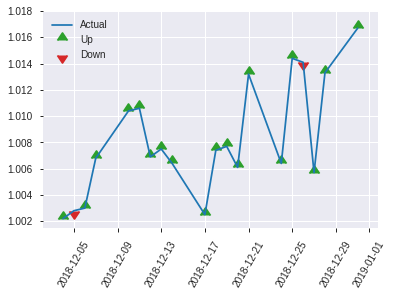


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18053132387089232
RMSE: 0.424889778496603
LogLoss: 0.5357776206038175
Mean Per-Class Error: 0.24705882352941178
AUC: 0.8125
pr_auc: 0.8041112590469085
Gini: 0.625
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48741065578197307: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      94   42   0.3088   (42.0/136.0)
1      25   95   0.2083   (25.0/120.0)
Total  119  137  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487411     0.7393    136
max f2                       0.227817     0.835714  219
max f0point5                 0.598997     0.761364  79
max accuracy                 0.563079     0.757812  103
max precision                0.997644     1         0
max recall                   0.0245681    1         243
max specificity              0.997644     1         0
max absolute_mcc             0.563079     0.514009  103
max min_per_class_accuracy   0.505192     0.741667  123
max mean_per_class_accuracy  0.563079     0.752941  103

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.981137           2.13333   2.13333            1                0.989558   1                           0.989558            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.973076           2.13333   2.13333            1                0.975592   1                           0.982575            0.025           0.05                       113.333   113.333
    3        0.03125                     0.959833           2.13333   2.13333            1                0.966876   1                           0.97865             0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.953809           2.13333   2.13333            1                0.957567   1                           0.9729              0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.945498           2.13333   2.13333            1                0.948676   1                           0.969173            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.893983           1.96923   2.05128            0.923077         0.914844   0.961538                    0.942008            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.814913           1.80513   1.96923            0.846154         0.849813   0.923077                    0.911277            0.0916667       0.3                        80.5128   96.9231
    8        0.203125                    0.69543            1.47692   1.84615            0.692308         0.748326   0.865385                    0.870539            0.075           0.375                      47.6923   84.6154
    9        0.300781                    0.606133           1.62133   1.77316            0.76             0.640287   0.831169                    0.795782            0.158333        0.533333                   62.1333   77.316
    10       0.402344                    0.563993           1.31282   1.65696            0.615385         0.58493    0.776699                    0.742557            0.133333        0.666667                   31.2821   65.6958
    11       0.5                         0.498168           0.938667  1.51667            0.44             0.526193   0.710938                    0.700299            0.0916667       0.758333                   -6.13333  51.6667
    12       0.601562                    0.450783           0.738462  1.38528            0.346154         0.473887   0.649351                    0.662073            0.075           0.833333                   -26.1538  38.5281
    13       0.699219                    0.39843            0.341333  1.23948            0.16             0.42569    0.581006                    0.629059            0.0333333       0.866667                   -65.8667  23.9479
    14       0.800781                    0.318267           0.574359  1.15512            0.269231         0.36155    0.541463                    0.595131            0.0583333       0.925                      -42.5641  15.5122
    15       0.898438                    0.114815           0.512     1.08522            0.24             0.229108   0.508696                    0.555346            0.05            0.975                      -48.8     8.52174
    16       1                           0.000541819        0.246154  1                  0.115385         0.0436185  0.46875                     

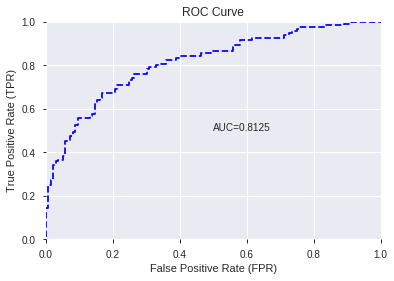

This function is available for GLM models only


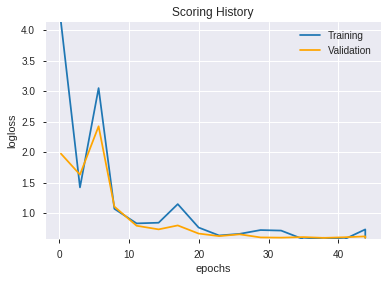

--2019-08-22 12:33:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.5MB/s    in 83s     

2019-08-22 12:34:59 (4.24 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_120606_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_120606_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_123512_model_8  0.832353  0.532136              0.250000  0.424421  0.180133
1  DeepLearning_grid_1_AutoML_20190822_123512_model_6  0.815257  0.546686              0.261765  0.429604  0.184559
2  DeepLearning_grid_1_AutoML_20190822_123512_model_5  0.812684  0.540157              0.266912  0.430487  0.185319
3  DeepLearning_grid_1_AutoML_20190822_123512_model_9  0.801654  0.572362              0.260784  0.436204  0.190274
4  DeepLearning_grid_1_AutoML_20190822_123512_model_4  0.788725  0.602043              0.290931  0.445414  0.198394
5  DeepLearning_grid_1_AutoML_20190822_123512_model_7  0.782659  0.577437              0.302206  0.439228  0.192922
6  DeepLearning_grid_1_AutoML_20190822_123512_model_3  0.763971  0.606322              0.322059  0.455437  0.207423
7               DeepLearning_1_AutoML_20190822_123512  0.758027  0.604332              0.317402  0.451154  0.203540
8  DeepLearning_grid_1_AutoML_20190822_123512_model_1  0.739277  0.775262              0.333333  0.471507  0.222319
9  DeepLearning_grid_1_AutoML_20190822_123512_model_2  0.734498  0.619293              0.393137  0.463070  0.214433

variable  relative_importance  scaled_importance  percentage
0        CDLRICKSHAWMAN             1.000000           1.000000    0.039192
1          STOCHF_fastk             0.888844           0.888844    0.034835
2                   SUB             0.887738           0.887738    0.034792
3                TRANGE             0.857283           0.857283    0.033598
4                ULTOSC             0.798653           0.798653    0.031301
5                   DIV             0.706442           0.706442    0.027687
6              WILLR_12             0.673238           0.673238    0.026385
7                 CCI_8             0.647713           0.647713    0.025385
8               WILLR_8             0.643434           0.643434    0.025217
9      CDLDRAGONFLYDOJI             0.597630           0.597630    0.023422
10           MINUS_DI_8             0.595142           0.595142    0.023325
11    CDLGRAVESTONEDOJI             0.592271           0.592271    0.023212
12            PLUS_DI_8             0.584240           0.584240    0.022897
13            CDLTAKURI             0.579412           0.579412    0.022708
14               CCI_12             0.538986           0.538986    0.021124
15         weekday_name             0.538552           0.538552    0.021107
16             CORREL_8             0.530407           0.530407    0.020788
17          MINUS_DI_12             0.497337           0.497337    0.019492
18            PLUS_DM_8             0.482800           0.482800    0.018922
19            CORREL_20             0.475921           0.475921    0.018652
20           AROONOSC_8             0.471875           0.471875    0.018494
21        CDLHANGINGMAN             0.463575           0.463575    0.018168
22         CDLTASUKIGAP             0.453988           0.453988    0.017793
23          CDLBELTHOLD             0.453839           0.453839    0.017787
24           MINUS_DM_8             0.453241           0.453241    0.017763
25      CDLSHOOTINGSTAR             0.446402           0.446402    0.017495
26                VAR_8             0.445491           0.445491    0.017460
27   CDLSEPARATINGLINES             0.440370           0.440370    0.017259
28       CDL3LINESTRIKE             0.438933           0.438933    0.017203
29    CDLINVERTEDHAMMER             0.436090           0.436090    0.017091
30          CDLPIERCING             0.435247           0.435247    0.017058
31      CDLADVANCEBLOCK             0.434980           0.434980    0.017048
32  CDLXSIDEGAP3METHODS             0.425193           0.425193    0.016664
33       CDLEVENINGSTAR             0.423990           0.423990    0.016617
34   CDLEVENINGDOJISTAR             0.419953           0.419953    0.016459
35   CDLCLOSINGMARUBOZU             0.414609           0.414609    0.016249
36   CDLMORNINGDOJISTAR             0.410744           0.410744    0.016098
37       CDLMATCHINGLOW             0.410624           0.410624    0.016093
38            CDLONNECK             0.408291           0.408291    0.016002
39       is_month_start             0.396835           0.396835    0.015553
40         CDLENGULFING             0.393536           0.393536    0.015423
41       is_quarter_end             0.393033           0.393033    0.015404
42     is_quarter_start             0.389331           0.389331    0.015259
43            CDLHAMMER             0.382503           0.382503    0.014991
44       CDLMORNINGSTAR             0.381458           0.381458    0.014950
45       CDLHARAMICROSS             0.380370           0.380370    0.014907
46          CDL3OUTSIDE             0.379596           0.379596    0.014877
47           CDL3INSIDE             0.371761           0.371761    0.014570
48         is_month_end             0.334856           0.334856    0.013124
49     CDLCOUNTERATTACK             0.308832           0.308832    0.012104

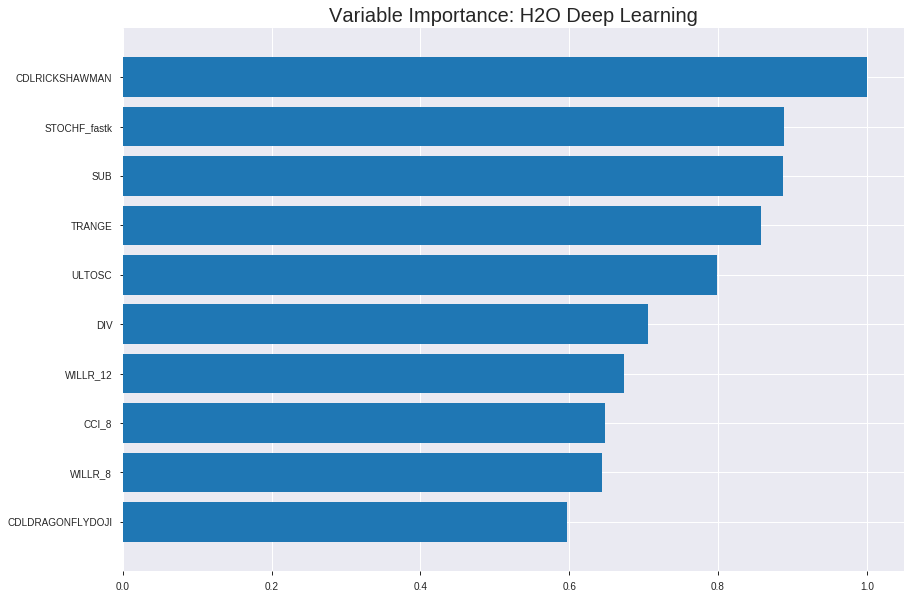

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_123512_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1794954859269033
RMSE: 0.42366907596248193
LogLoss: 0.5248032659569831
Mean Per-Class Error: 0.29333689033958943
AUC: 0.801229677986316
pr_auc: 0.8046195656094248
Gini: 0.6024593559726319
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43098123233884433: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      411  479   0.5382   (479.0/890.0)
1      72   823   0.0804   (72.0/895.0)
Total  483  1302  0.3087   (551.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430981     0.749203  246
max f2                       0.183594     0.861463  333
max f0point5                 0.601667     0.732257  129
max accuracy                 0.500386     0.707003  208
max precision                0.999026     1         0
max recall                   0.00957551   1         396
max specificity              0.999026     1         0
max absolute_mcc             0.601667     0.437095  129
max min_per_class_accuracy   0.538579     0.7       177
max mean_per_class_accuracy  0.500386     0.706663  208

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 51.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.996628           1.99441    1.99441            1                0.998288   1                           0.998288            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.993318           1.99441    1.99441            1                0.995106   1                           0.996697            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.990309           1.99441    1.99441            1                0.99181    1                           0.995068            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.988024           1.88361    1.96671            0.944444         0.98929    0.986111                    0.993624            0.0189944       0.0793296                  88.3613   96.6713
    5        0.0504202                   0.983383           1.99441    1.97225            1                0.98578    0.988889                    0.992055            0.0201117       0.0994413                  99.4413   97.2253
    6        0.10028                     0.920195           1.88237    1.92756            0.94382          0.95689    0.96648                     0.97457             0.0938547       0.193296                   88.2368   92.7562
    7        0.15014                     0.808677           1.74791    1.8679             0.876404         0.865095   0.936567                    0.938215            0.0871508       0.280447                   74.7913   86.7902
    8        0.2                         0.677165           1.65828    1.81564            0.831461         0.744762   0.910364                    0.889987            0.0826816       0.363128                   65.8276   81.5642
    9        0.30028                     0.57929            1.29247    1.64093            0.648045         0.610154   0.822761                    0.796535            0.129609        0.492737                   29.2469   64.0926
    10       0.4                         0.557343           0.997207   1.48045            0.5              0.568289   0.742297                    0.739634            0.0994413       0.592179                   -0.27933  48.0447
    11       0.50028                     0.538451           1.09191    1.40257            0.547486         0.547251   0.703247                    0.701071            0.109497        0.701676                   9.19135   40.2566
    12       0.6                         0.510579           1.01962    1.33892            0.511236         0.525811   0.671335                    0.671943            0.101676        0.803352                   1.96158   33.892
    13       0.69972                     0.463222           0.90757    1.27745            0.455056         0.490435   0.640512                    0.646075            0.0905028       0.893855                   -9.24299  27.7447
    14       0.8                         0.311782           0.568241   1.18855            0.284916         0.396125   0.595938                    0.614744            0.0569832       0.950838                   -43.1759  18.8547
    15       0.89972                     0.0836402          0.425774   1.10401            0.213483         0.211415   0.553549                    0.570041            0.0424581       0.993296                   -57.4226  10.4006
    16       1                           0.00113995         0.0668518  1                  0.0335196        0.0371062  0.501401  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18307107649927795
RMSE: 0.4278680596857844
LogLoss: 0.550596690661964
Mean Per-Class Error: 0.27254901960784317
AUC: 0.7945174932718185
pr_auc: 0.773167919621112
Gini: 0.5890349865436371
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4938389596045524: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      131  124  0.4863   (124.0/255.0)
1      22   233  0.0863   (22.0/255.0)
Total  153  357  0.2863   (146.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493839     0.761438  264
max f2                       0.397288     0.86695   295
max f0point5                 0.534109     0.71837   219
max accuracy                 0.534109     0.727451  219
max precision                0.860004     0.943662  60
max recall                   0.0439743    1         371
max specificity              0.998228     0.996078  0
max absolute_mcc             0.493839     0.466387  264
max min_per_class_accuracy   0.544933     0.698039  200
max mean_per_class_accuracy  0.534109     0.727451  219

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.994969           1.33333   1.33333            0.666667         0.996639   0.666667                    0.996639            0.0156863       0.0156863                  33.3333   33.3333
    2        0.0215686                   0.993345           2         1.63636            1                0.994094   0.818182                    0.995482            0.0196078       0.0352941                  100       63.6364
    3        0.0313725                   0.98799            2         1.75               1                0.991089   0.875                       0.994109            0.0196078       0.054902                   100       75
    4        0.0411765                   0.982938           2         1.80952            1                0.984298   0.904762                    0.991773            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.979661           2         1.84615            1                0.981898   0.923077                    0.989874            0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.932859           1.84      1.84314            0.92             0.957075   0.921569                    0.973796            0.0901961       0.184314                   84        84.3137
    7        0.15098                     0.826312           1.76923   1.81818            0.884615         0.880465   0.909091                    0.942282            0.0901961       0.27451                    76.9231   81.8182
    8        0.2                         0.705725           1.44      1.72549            0.72             0.763874   0.862745                    0.898554            0.0705882       0.345098                   44        72.549
    9        0.3                         0.583048           1.33333   1.59477            0.666667         0.620419   0.797386                    0.805842            0.133333        0.478431                   33.3333   59.4771
    10       0.4                         0.55983            0.980392  1.44118            0.490196         0.571308   0.720588                    0.747209            0.0980392       0.576471                   -1.96078  44.1176
    11       0.5                         0.544095           1.21569   1.39608            0.607843         0.551719   0.698039                    0.708111            0.121569        0.698039                   21.5686   39.6078
    12       0.6                         0.52792            1.13725   1.35294            0.568627         0.535915   0.676471                    0.679412            0.113725        0.811765                   13.7255   35.2941
    13       0.7                         0.493505           1.01961   1.30532            0.509804         0.514615   0.652661                    0.655869            0.101961        0.913725                   1.96078   30.5322
    14       0.8                         0.293942           0.509804  1.20588            0.254902         0.427942   0.602941                    0.627378            0.0509804       0.964706                   -49.0196  20.5882
    15       0.9                         0.0713831          0.196078  1.09368            0.0980392        0.167695   0.546841                    0.576302            0.0196078       0.984314                   -80.3922  9.36819
    16       1                           0.00897359         0.156863  1                  0.0784314        0.0370442  0.5                         0.522


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:41:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:41:18  1 min 13.891 sec  594 obs/sec       0.501401  1             895        0.617828         1.20155             -0.526856      0.700697        0.718653           1.77281          0.4                              0.612063           1.16745               -0.498483        0.717409          0.725548             1.66667            0.390196
    2019-08-22 12:41:29  1 min 24.470 sec  967 obs/sec       6.00616   12            10721      0.466504         0.617365            0.129491       0.759736        0.778557           1.99441          0.380392                         0.467972           0.626108              0.124009         0.742161          0.745352             1.33333            0.352941
    2019-08-22 12:41:39  1 min 34.631 sec  1058 obs/sec      12.0062   24            21431      0.433636         0.547081            0.247832       0.799642        0.801502           1.99441          0.314286                         0.440206           0.57119               0.224874         0.770804          0.759643             1.33333            0.303922
    2019-08-22 12:41:49  1 min 44.796 sec  1123 obs/sec      18.512    37            33044      0.423669         0.524803            0.282012       0.80123         0.80462            1.99441          0.308683                         0.427868           0.550597              0.267716         0.794517          0.773168             1.33333            0.286275
    2019-08-22 12:41:59  1 min 55.222 sec  1171 obs/sec      25.4902   51            45500      0.419001         0.514397            0.297749       0.815015        0.821854           1.99441          0.307563                         0.43447            0.569253              0.244944         0.778762          0.758207             1.33333            0.286275
    2019-08-22 12:42:10  2 min  5.318 sec  1211 obs/sec      32.5249   65            58057      0.415108         0.503732            0.310735       0.820001        0.828284           1.99441          0.281793                         0.436257           0.573852              0.238718         0.783968          0.760803             1.33333            0.282353
    2019-08-22 12:42:20  2 min 15.806 sec  1256 obs/sec      40.4224   81            72154      0.410668         0.495038            0.325402       0.82938         0.839099           1.99441          0.290756                         0.437193           0.571046              0.235448         0.779908          0.760787             1.33333            0.296078
    2019-08-22 12:42:31  2 min 26.358 sec  1291 obs/sec      48.4325   97            86452      0.404314         0.476435            0.346115       0.831276        0.840626           1.99441          0.282353                         0.434767           0.583514              0.243911         0.774225          0.761387             1.33333            0.303922
    2019-08-22 12:42:32

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN    1.0                    1.0                  0.03919172674678261
STOCHF_fastk      0.88884437084198       0.88884437084198     0.034835345702454786
SUB               0.8877376317977905     0.8877376317977905   0.03479197068825492
TRANGE            0.8572825789451599     0.8572825789451599   0.0335983845787958
ULTOSC            0.7986528873443604     0.7986528873443604   0.03130058572632913
---               ---                    ---                  ---
CDLHARAMICROSS    0.38036975264549255    0.38036975264549255  0.014907347408423435
CDL3OUTSIDE       0.37959563732147217    0.37959563732147217  0.01487700849217393
CDL3INSIDE        0.37176066637039185    0.37176066637039185  0.014569942451590212
is_month_end      0.33485618233680725    0.33485618233680725  0.013123591997614963
CDLCOUNTERATTACK  0.3088323771953583     0.3088323771953583   0.012103674137599779


See the whole table with table.as_data_frame()


('accuracy', 0.75390625)

('F1', 0.7608695652173914)

('auc', 0.8323529411764706)

('logloss', 0.5321362576715307)

('mean_per_class_error', 0.24705882352941178)

('rmse', 0.4244211763853623)

('mse', 0.1801333349643348)

deeplearning prediction progress: |███████████████████████████████████████| 100%


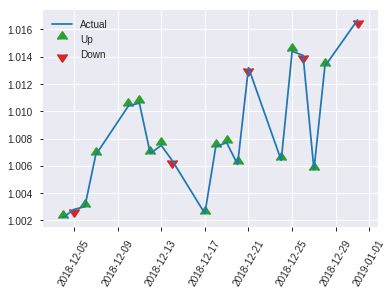


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1801333349643348
RMSE: 0.4244211763853623
LogLoss: 0.5321362576715307
Mean Per-Class Error: 0.24705882352941178
AUC: 0.8323529411764706
pr_auc: 0.8217031106240088
Gini: 0.6647058823529413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5177114072505333: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   51   0.375    (51.0/136.0)
1      15   105  0.125    (15.0/120.0)
Total  100  156  0.2578   (66.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.517711     0.76087   155
max f2                       0.388947     0.839525  192
max f0point5                 0.576229     0.785714  74
max accuracy                 0.576229     0.753906  74
max precision                0.999389     1         0
max recall                   0.063051     1         234
max specificity              0.999389     1         0
max absolute_mcc             0.576229     0.53049   74
max min_per_class_accuracy   0.542006     0.733333  123
max mean_per_class_accuracy  0.534201     0.752941  135

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.994104           2.13333   2.13333            1                0.997317   1                           0.997317            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.992884           2.13333   2.13333            1                0.993309   1                           0.995313            0.025           0.05                       113.333   113.333
    3        0.03125                     0.990827           2.13333   2.13333            1                0.992268   1                           0.994552            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.982223           2.13333   2.13333            1                0.985843   1                           0.992177            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.972914           2.13333   2.13333            1                0.979707   1                           0.990258            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.939016           1.96923   2.05128            0.923077         0.959932   0.961538                    0.975095            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.847811           1.64103   1.91453            0.769231         0.896511   0.897436                    0.9489              0.0833333       0.291667                   64.1026   91.453
    8        0.203125                    0.683144           1.96923   1.92821            0.923077         0.77674    0.903846                    0.90586             0.1             0.391667                   96.9231   92.8205
    9        0.300781                    0.575062           1.70667   1.85628            0.8              0.601378   0.87013                     0.807002            0.166667        0.558333                   70.6667   85.6277
    10       0.402344                    0.55972            0.984615  1.63625            0.461538         0.566903   0.76699                     0.746395            0.1             0.658333                   -1.53846  63.6246
    11       0.5                         0.539286           1.024     1.51667            0.48             0.54958    0.710938                    0.707954            0.1             0.758333                   2.4       51.6667
    12       0.601562                    0.51891            0.984615  1.42684            0.461538         0.53024    0.668831                    0.677951            0.1             0.858333                   -1.53846  42.684
    13       0.699219                    0.461955           0.512     1.29907            0.24             0.497234   0.608939                    0.652711            0.05            0.908333                   -48.8     29.9069
    14       0.800781                    0.290208           0.328205  1.17593            0.153846         0.388963   0.55122                     0.61926             0.0333333       0.941667                   -67.1795  17.5935
    15       0.898438                    0.0722288          0.426667  1.09449            0.2              0.155593   0.513043                    0.568861            0.0416667       0.983333                   -57.3333  9.44928
    16       1                           0.00777411         0.164103  1                  0.0769231        0.0394812  0.46875                     0

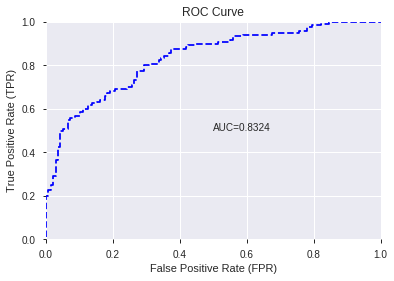

This function is available for GLM models only


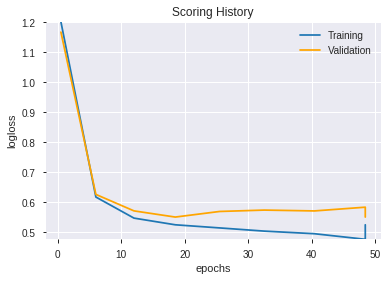

--2019-08-22 12:43:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_123512_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_123512_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'ULTOSC',
 'DIV',
 'WILLR_12',
 'CCI_8',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'MINUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_8',
 'CDLTAKURI',
 'CCI_12',
 'weekday_name',
 'CORREL_8',
 'MINUS_DI_12',
 'PLUS_DM_8',
 'CORREL_20',
 'AROONOSC_8',
 'CDLHANGINGMAN',
 'CDLTASUKIGAP',
 'CDLBELTHOLD',
 'MINUS_DM_8',
 'CDLSHOOTINGSTAR',
 'VAR_8',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'CDLINVERTEDHAMMER',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLMORNINGDOJISTAR',
 'CDLMATCHINGLOW',
 'CDLONNECK',
 'is_month_start',
 'CDLENGULFING',
 'is_quarter_end',
 'is_quarter_start',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'CDLHARAMICROSS',
 'CDL3OUTSIDE',
 'CDL3INSIDE',
 'is_month_end',
 'CDLCOUNTERATTACK']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190822_124356_model_1  0.800735  0.54054              0.264216  0.42907  0.184101

variable  relative_importance  scaled_importance  percentage
0                 CCI_8             0.552869           1.000000    0.086438
1              WILLR_12             0.542511           0.981265    0.084819
2          STOCHF_fastk             0.501426           0.906953    0.078396
3               WILLR_8             0.391071           0.707349    0.061142
4             PLUS_DI_8             0.356235           0.644339    0.055696
5                CCI_12             0.351199           0.635230    0.054908
6            MINUS_DI_8             0.336869           0.609310    0.052668
7      CDLDRAGONFLYDOJI             0.304058           0.549964    0.047538
8             CDLTAKURI             0.288696           0.522177    0.045136
9     CDLGRAVESTONEDOJI             0.226342           0.409395    0.035387
10   CDLSEPARATINGLINES             0.184932           0.334496    0.028913
11           AROONOSC_8             0.164452           0.297453    0.025711
12            PLUS_DM_8             0.162271           0.293508    0.025370
13  CDLXSIDEGAP3METHODS             0.140114           0.253430    0.021906
14       is_quarter_end             0.137738           0.249134    0.021535
15       CDLRICKSHAWMAN             0.136226           0.246399    0.021298
16          CDLBELTHOLD             0.106277           0.192228    0.016616
17               ULTOSC             0.104773           0.189509    0.016381
18          CDLPIERCING             0.096652           0.174818    0.015111
19               TRANGE             0.096558           0.174649    0.015096
20    CDLINVERTEDHAMMER             0.081800           0.147956    0.012789
21          MINUS_DI_12             0.081707           0.147788    0.012775
22         CDLTASUKIGAP             0.081246           0.146954    0.012702
23                  DIV             0.077966           0.141021    0.012190
24      CDLADVANCEBLOCK             0.075924           0.137327    0.011870
25             CORREL_8             0.071587           0.129482    0.011192
26   CDLEVENINGDOJISTAR             0.069520           0.125744    0.010869
27       CDL3LINESTRIKE             0.067379           0.121872    0.010534
28       is_month_start             0.059973           0.108475    0.009376
29        CDLHANGINGMAN             0.059077           0.106855    0.009236
30      CDLSHOOTINGSTAR             0.055211           0.099862    0.008632
31         weekday_name             0.049094           0.088799    0.007676
32          CDL3OUTSIDE             0.042304           0.076517    0.006614
33                VAR_8             0.040378           0.073034    0.006313
34     CDLCOUNTERATTACK             0.038982           0.070509    0.006095
35         CDLENGULFING             0.038266           0.069213    0.005983
36            CDLHAMMER             0.032091           0.058045    0.005017
37            CORREL_20             0.030785           0.055682    0.004813
38           MINUS_DM_8             0.026878           0.048616    0.004202
39     is_quarter_start             0.024519           0.044349    0.003833
40           CDL3INSIDE             0.021593           0.039056    0.003376
41            CDLONNECK             0.017816           0.032225    0.002785
42   CDLMORNINGDOJISTAR             0.017726           0.032061    0.002771
43         is_month_end             0.013642           0.024675    0.002133
44       CDLMORNINGSTAR             0.012464           0.022545    0.001949
45                  SUB             0.012000           0.021705    0.001876
46   CDLCLOSINGMARUBOZU             0.006302           0.011399    0.000985
47       CDLHARAMICROSS             0.005736           0.010376    0.000897
48       CDLEVENINGSTAR             0.002768           0.005007    0.000433
49       CDLMATCHINGLOW             0.000101           0.000183    0.000016

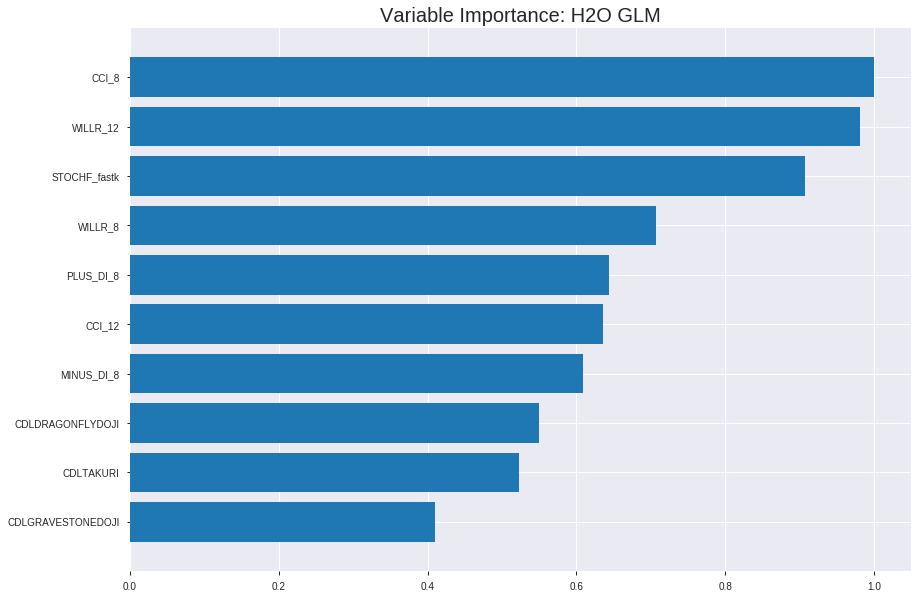

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124356_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18490207127329544
RMSE: 0.43000240845057536
LogLoss: 0.5450377098353326
Null degrees of freedom: 1784
Residual degrees of freedom: 1734
Null deviance: 2474.52142897845
Residual deviance: 1945.7846241121374
AIC: 2047.7846241121374
AUC: 0.7952965915510639
pr_auc: 0.7905748823316463
Gini: 0.5905931831021278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4359996914418943: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      514  376   0.4225   (376.0/890.0)
1      138  757   0.1542   (138.0/895.0)
Total  652  1133  0.288    (514.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436        0.746548  238
max f2                       0.189687     0.856198  334
max f0point5                 0.53116      0.722758  184
max accuracy                 0.465439     0.713725  221
max precision                0.992688     1         0
max recall                   0.035372     1         390
max specificity              0.992688     1         0
max absolute_mcc             0.438275     0.440555  237
max min_per_class_accuracy   0.504882     0.70838   199
max mean_per_class_accuracy  0.465439     0.713533  221

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.951267           1.99441   1.99441            1                0.964091   1                           0.964091            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.940249           1.88361   1.93901            0.944444         0.94687    0.972222                    0.955481            0.0189944       0.0391061                  88.3613   93.9013
    3        0.0302521                   0.926282           1.88361   1.92055            0.944444         0.933018   0.962963                    0.947993            0.0189944       0.0581006                  88.3613   92.0546
    4        0.0403361                   0.912067           1.66201   1.85591            0.833333         0.917919   0.930556                    0.940475            0.0167598       0.0748603                  66.2011   85.5912
    5        0.0504202                   0.900586           1.77281   1.83929            0.888889         0.905316   0.922222                    0.933443            0.0178771       0.0927374                  77.2812   83.9292
    6        0.10028                     0.837192           1.79273   1.81614            0.898876         0.866966   0.910615                    0.90039             0.0893855       0.182123                   79.2731   81.6142
    7        0.15014                     0.761979           1.7255    1.78604            0.865169         0.800877   0.895522                    0.867343            0.0860335       0.268156                   72.5504   78.6042
    8        0.2                         0.710031           1.59105   1.73743            0.797753         0.733936   0.871148                    0.834085            0.0793296       0.347486                   59.1049   73.743
    9        0.30028                     0.620814           1.32589   1.6                0.664804         0.660247   0.802239                    0.776031            0.132961        0.480447                   32.5895   59.9996
    10       0.4                         0.557287           1.2325    1.50838            0.617978         0.587749   0.756303                    0.729092            0.122905        0.603352                   23.2503   50.838
    11       0.50028                     0.502318           1.04735   1.41597            0.52514          0.528083   0.709966                    0.6888              0.105028        0.70838                    4.73456   41.5967
    12       0.6                         0.450145           1.05323   1.35568            0.52809          0.474969   0.679739                    0.653262            0.105028        0.813408                   5.32296   35.568
    13       0.69972                     0.394194           0.739502  1.26787            0.370787         0.423104   0.635709                    0.620461            0.073743        0.887151                   -26.0498  26.7866
    14       0.8                         0.321328           0.623951  1.18715            0.312849         0.363686   0.595238                    0.588274            0.0625698       0.949721                   -37.6049  18.7151
    15       0.89972                     0.12655            0.380955  1.0978             0.191011         0.239712   0.550436                    0.549641            0.0379888       0.987709                   -61.9045  9.77967
    16       1                           0.00645377         0.122562  1                  0.0614525        0.0685813  0.501401                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1880463825370518
RMSE: 0.43364315114740576
LogLoss: 0.5527731842038128
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 707.0141257874837
Residual deviance: 563.8286478878891
AIC: 665.8286478878891
AUC: 0.7850519031141868
pr_auc: 0.7771338071514955
Gini: 0.5701038062283736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668884533958096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  107  0.4196   (107.0/255.0)
1      42   213  0.1647   (42.0/255.0)
Total  190  320  0.2922   (149.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466888     0.74087   251
max f2                       0.256647     0.855263  329
max f0point5                 0.631277     0.716578  136
max accuracy                 0.516611     0.707843  215
max precision                0.982297     1         0
max recall                   0.0415369    1         392
max specificity              0.982297     1         0
max absolute_mcc             0.466888     0.429887  251
max min_per_class_accuracy   0.532454     0.690196  202
max mean_per_class_accuracy  0.466888     0.707843  251

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.970889           2         2                  1                0.978002   1                           0.978002            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.955283           1.2       1.63636            0.6              0.963125   0.818182                    0.97124             0.0117647       0.0352941                  20        63.6364
    3        0.0313725                   0.947752           2         1.75               1                0.950751   0.875                       0.964837            0.0196078       0.054902                   100       75
    4        0.0411765                   0.943569           2         1.80952            1                0.945946   0.904762                    0.960339            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.933709           1.6       1.76923            0.8              0.938992   0.884615                    0.956234            0.0156863       0.0901961                  60        76.9231
    6        0.1                         0.889702           2         1.88235            1                0.91396    0.941176                    0.935511            0.0980392       0.188235                   100       88.2353
    7        0.15098                     0.841617           1.69231   1.81818            0.846154         0.867359   0.909091                    0.912499            0.0862745       0.27451                    69.2308   81.8182
    8        0.2                         0.784126           1.44      1.72549            0.72             0.811108   0.862745                    0.887648            0.0705882       0.345098                   44        72.549
    9        0.3                         0.655797           1.33333   1.59477            0.666667         0.716102   0.797386                    0.830466            0.133333        0.478431                   33.3333   59.4771
    10       0.4                         0.582539           1.09804   1.47059            0.54902          0.616569   0.735294                    0.776992            0.109804        0.588235                   9.80392   47.0588
    11       0.5                         0.531467           1.01961   1.38039            0.509804         0.557223   0.690196                    0.733038            0.101961        0.690196                   1.96078   38.0392
    12       0.6                         0.482707           1.05882   1.3268             0.529412         0.507943   0.663399                    0.695522            0.105882        0.796078                   5.88235   32.6797
    13       0.7                         0.416868           0.784314  1.2493             0.392157         0.448477   0.62465                     0.66023             0.0784314       0.87451                    -21.5686  24.93
    14       0.8                         0.332003           0.666667  1.17647            0.333333         0.383108   0.588235                    0.62559             0.0666667       0.941176                   -33.3333  17.6471
    15       0.9                         0.111405           0.431373  1.09368            0.215686         0.202627   0.546841                    0.578594            0.0431373       0.984314                   -56.8627  9.36819
    16       1                           0.0221787          0.156863  1                  0.0784314        0.0641968  0.5                         0.527154   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:43:57  0.000 sec   2            .15E2     48            1.370475027188685   1.3669938698817896
     2019-08-22 12:43:57  0.044 sec   4            .92E1     51            1.3617895740892512  1.3564057030195862
     2019-08-22 12:43:57  0.087 sec   6            .57E1     51            1.3491040759042867  1.3409742715065553
     2019-08-22 12:43:57  0.127 sec   8            .36E1     51            1.3314763906705247  1.319626631022526
     2019-08-22 12:43:57  0.162 sec   10           .22E1     51            1.308530925020666   1.2921110629247445
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:43:58  0.456 sec   34           .73E-2    51            1.0862016817919373  1.1062679197852077
     2019-08-22 12:43:58  0.479 sec   36           .45E-2    51            1.0837721383721122  1.1075453109701405
     2019-08-22 12:43:58  0.504 sec   38           .28E-2    51            1.0822732284797072  1.1090460223520762
     2019-08-22 12:43:58  0.539 sec   40           .17E-2    51            1.0813638452643815  1.1106636615890264
     2019-08-22 12:43:58  0.560 sec   42           .11E-2    51            1.0808304750922177  1.1123677773843987


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.728)

('auc', 0.8007352941176471)

('logloss', 0.5405395376721251)

('mean_per_class_error', 0.26421568627450975)

('rmse', 0.4290697451195293)

('mse', 0.18410084617693784)

glm prediction progress: |████████████████████████████████████████████████| 100%


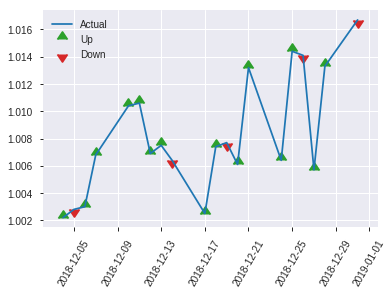


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18410084617693784
RMSE: 0.4290697451195293
LogLoss: 0.5405395376721251
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9830011899469
Residual deviance: 276.7562432881281
AIC: 378.7562432881281
AUC: 0.8007352941176471
pr_auc: 0.7963355869940013
Gini: 0.6014705882352942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5135310738710314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   39   0.2868   (39.0/136.0)
1      29   91   0.2417   (29.0/120.0)
Total  126  130  0.2656   (68.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513531     0.728     129
max f2                       0.10059      0.834492  238
max f0point5                 0.641637     0.756881  78
max accuracy                 0.641637     0.738281  78
max precision                0.978209     1         0
max recall                   0.10059      1         238
max specificity              0.978209     1         0
max absolute_mcc             0.641637     0.490919  78
max min_per_class_accuracy   0.523195     0.720588  124
max mean_per_class_accuracy  0.513531     0.735784  129

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.95743            2.13333   2.13333            1                0.969171   1                           0.969171            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.949746           2.13333   2.13333            1                0.953525   1                           0.961348            0.025           0.05                       113.333   113.333
    3        0.03125                     0.944864           2.13333   2.13333            1                0.947167   1                           0.957803            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.939718           2.13333   2.13333            1                0.941706   1                           0.953413            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.932091           2.13333   2.13333            1                0.937304   1                           0.950935            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.884126           1.96923   2.05128            0.923077         0.912092   0.961538                    0.931513            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.823726           1.80513   1.96923            0.846154         0.854871   0.923077                    0.905966            0.0916667       0.3                        80.5128   96.9231
    8        0.203125                    0.746575           1.64103   1.88718            0.769231         0.78431    0.884615                    0.875552            0.0833333       0.383333                   64.1026   88.7179
    9        0.300781                    0.645129           1.536     1.77316            0.72             0.695731   0.831169                    0.817168            0.15            0.533333                   53.6      77.316
    10       0.402344                    0.559898           0.984615  1.57411            0.461538         0.608206   0.737864                    0.764421            0.1             0.633333                   -1.53846  57.411
    11       0.5                         0.515811           1.10933   1.48333            0.52             0.53997    0.695312                    0.720582            0.108333        0.741667                   10.9333   48.3333
    12       0.601562                    0.455113           0.574359  1.32987            0.269231         0.487167   0.623377                    0.681175            0.0583333       0.8                        -42.5641  32.987
    13       0.699219                    0.390164           0.682667  1.23948            0.32             0.423025   0.581006                    0.64512             0.0666667       0.866667                   -31.7333  23.9479
    14       0.800781                    0.29793            0.738462  1.17593            0.346154         0.346291   0.55122                     0.60722             0.075           0.941667                   -26.1538  17.5935
    15       0.898438                    0.149648           0.426667  1.09449            0.2              0.222754   0.513043                    0.56543             0.0416667       0.983333                   -57.3333  9.44928
    16       1                           0.025977           0.164103  1                  0.0769231        0.0909443  0.46875                     0.

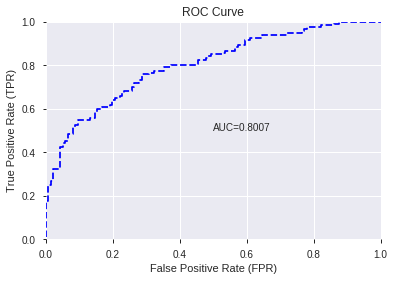

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


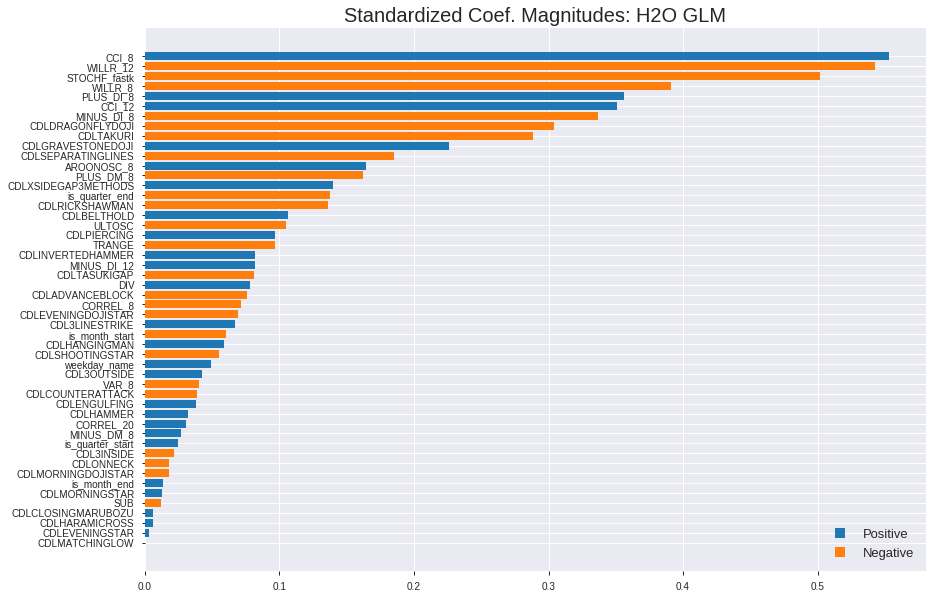

'log_likelihood'
--2019-08-22 12:44:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124356_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124356_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CCI_8',
 'WILLR_12',
 'STOCHF_fastk',
 'WILLR_8',
 'PLUS_DI_8',
 'CCI_12',
 'MINUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLSEPARATINGLINES',
 'AROONOSC_8',
 'PLUS_DM_8',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'ULTOSC',
 'CDLPIERCING',
 'TRANGE',
 'CDLINVERTEDHAMMER',
 'MINUS_DI_12',
 'CDLTASUKIGAP',
 'DIV',
 'CDLADVANCEBLOCK',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'CDL3OUTSIDE',
 'VAR_8',
 'CDLCOUNTERATTACK',
 'CDLENGULFING',
 'CDLHAMMER',
 'CORREL_20',
 'MINUS_DM_8',
 'is_quarter_start',
 'CDL3INSIDE',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'CDLMORNINGSTAR',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW']

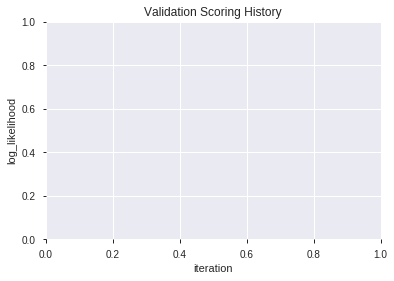

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124413_model_4  0.824203  0.529929              0.229657  0.419887  0.176305
1  XGBoost_grid_1_AutoML_20190822_124413_model_6  0.818873  0.526453              0.261520  0.420321  0.176670
2  XGBoost_grid_1_AutoML_20190822_124413_model_2  0.815074  0.531935              0.248529  0.422663  0.178644
3  XGBoost_grid_1_AutoML_20190822_124413_model_7  0.814277  0.529128              0.273529  0.421726  0.177853
4               XGBoost_2_AutoML_20190822_124413  0.810968  0.538933              0.265686  0.424806  0.180460
5  XGBoost_grid_1_AutoML_20190822_124413_model_1  0.809988  0.535084              0.276225  0.424973  0.180602
6               XGBoost_1_AutoML_20190822_124413  0.805208  0.538637              0.278186  0.426145  0.181600
7               XGBoost_3_AutoML_20190822_124413  0.804412  0.537167              0.266667  0.426046  0.181515
8  XGBoost_grid_1_AutoML_20190822_124413_model_3  0.803002  0.542489              0.281127  0.427893  0.183093
9  XGBoost_grid_1_AutoML_20190822_124413_model_5  0.802022  0.551974              0.261029  0.430571  0.185391

variable  relative_importance  scaled_importance  percentage
0    CDLDRAGONFLYDOJI           748.846802           1.000000    0.134534
1        STOCHF_fastk           741.321350           0.989951    0.133182
2               CCI_8           599.650330           0.800765    0.107730
3   CDLGRAVESTONEDOJI           519.951233           0.694336    0.093412
4             WILLR_8           473.652527           0.632509    0.085094
5            WILLR_12           344.300262           0.459774    0.061855
6           PLUS_DI_8           280.171753           0.374138    0.050334
7           CDLTAKURI           262.534637           0.350585    0.047166
8              ULTOSC           233.034286           0.311191    0.041866
9          MINUS_DI_8           202.856873           0.270892    0.036444
10         MINUS_DM_8           152.388184           0.203497    0.027377
11             CCI_12           143.590149           0.191748    0.025797
12           CORREL_8           143.523422           0.191659    0.025785
13             TRANGE           119.522446           0.159609    0.021473
14     CDLRICKSHAWMAN           112.333557           0.150009    0.020181
15              VAR_8            94.691185           0.126449    0.017012
16                DIV            77.461349           0.103441    0.013916
17         AROONOSC_8            75.541222           0.100877    0.013571
18                SUB            73.599899           0.098284    0.013223
19          PLUS_DM_8            58.370068           0.077947    0.010486
20       weekday_name            45.939526           0.061347    0.008253
21          CORREL_20            35.670879           0.047634    0.006408
22        MINUS_DI_12            27.271931           0.036419    0.004900

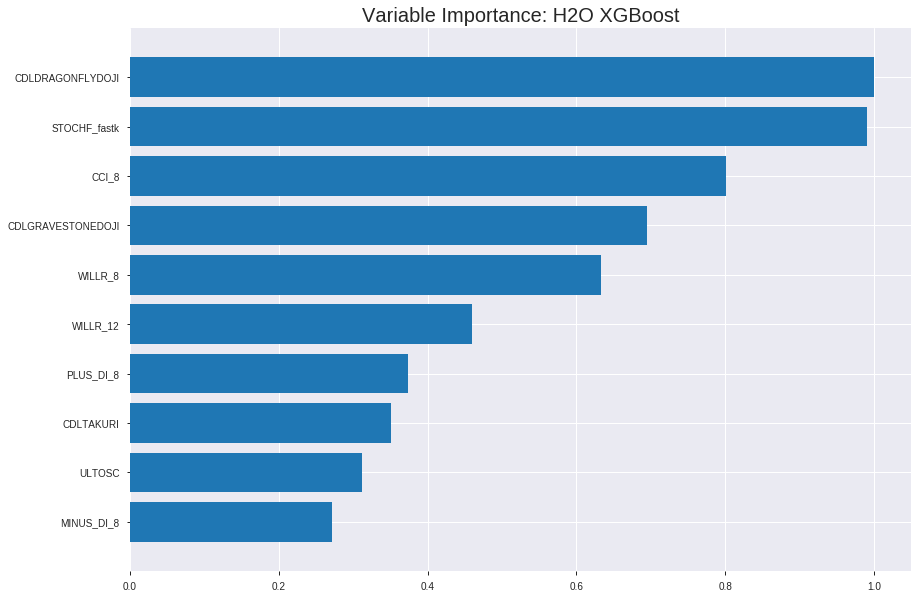

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124413_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16735244158925958
RMSE: 0.40908732758331634
LogLoss: 0.5085776045887112
Mean Per-Class Error: 0.23967422007406936
AUC: 0.8419609566254472
pr_auc: 0.8407385683117365
Gini: 0.6839219132508945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40815505385398865: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      566  324   0.364    (324.0/890.0)
1      117  778   0.1307   (117.0/895.0)
Total  683  1102  0.2471   (441.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408155     0.779169  249
max f2                       0.233906     0.864294  334
max f0point5                 0.575358     0.77446   168
max accuracy                 0.521997     0.760224  194
max precision                0.923318     1         0
max recall                   0.106049     1         390
max specificity              0.923318     1         0
max absolute_mcc             0.521997     0.521972  194
max min_per_class_accuracy   0.490574     0.753933  208
max mean_per_class_accuracy  0.521997     0.760326  194

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.904238           1.99441    1.99441            1                0.911804  1                           0.911804            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.890439           1.99441    1.99441            1                0.895932  1                           0.903868            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.88065            1.99441    1.99441            1                0.885313  1                           0.897683            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.867167           1.99441    1.99441            1                0.874283  1                           0.891833            0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.854328           1.99441    1.99441            1                0.860464  1                           0.885559            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.81308            1.83755    1.91642            0.921348         0.831388  0.960894                    0.858625            0.0916201       0.192179                   83.7549   91.642
    7        0.15014                     0.77516            1.70309    1.84558            0.853933         0.796229  0.925373                    0.837904            0.0849162       0.277095                   70.3095   84.5577
    8        0.2                         0.726131           1.63587    1.7933             0.820225         0.751186  0.89916                     0.816285            0.0815642       0.358659                   63.5867   79.3296
    9        0.30028                     0.653816           1.52645    1.70418            0.765363         0.688253  0.854478                    0.773528            0.153073        0.511732                   52.645    70.4182
    10       0.4                         0.574257           1.37816    1.62291            0.691011         0.61574   0.813725                    0.734192            0.13743         0.649162                   37.8162   62.2905
    11       0.50028                     0.490155           1.0362     1.5053             0.519553         0.531834  0.754759                    0.693629            0.103911        0.753073                   3.62036   50.5302
    12       0.6                         0.42038            0.963593   1.41527            0.483146         0.457959  0.709617                    0.654461            0.0960894       0.849162                   -3.6407   41.527
    13       0.69972                     0.348342           0.728297   1.31737            0.365169         0.384644  0.660528                    0.616008            0.0726257       0.921788                   -27.1703  31.7367
    14       0.8                         0.280834           0.423395   1.20531            0.212291         0.315587  0.604342                    0.57835             0.0424581       0.964246                   -57.6605  20.5307
    15       0.89972                     0.185363           0.26891    1.10152            0.134831         0.238638  0.552304                    0.540699            0.0268156       0.991061                   -73.109   10.1522
    16       1                           0.0768322          0.0891358  1                  0.0446927        0.133748  0.501401                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1823397175921291
RMSE: 0.42701254968926744
LogLoss: 0.5423348083000169
Mean Per-Class Error: 0.27647058823529413
AUC: 0.8016762783544791
pr_auc: 0.7958984682315066
Gini: 0.6033525567089582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34262022376060486: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  143  0.5608   (143.0/255.0)
1      16   239  0.0627   (16.0/255.0)
Total  128  382  0.3118   (159.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34262      0.750392  290
max f2                       0.285248     0.856742  310
max f0point5                 0.628468     0.748691  136
max accuracy                 0.590016     0.723529  155
max precision                0.914983     1         0
max recall                   0.104247     1         392
max specificity              0.914983     1         0
max absolute_mcc             0.628468     0.458439  136
max min_per_class_accuracy   0.535731     0.705882  188
max mean_per_class_accuracy  0.590016     0.723529  155

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.907338           2         2                  1                0.911175  1                           0.911175            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.901179           1.6       1.81818            0.8              0.903419  0.909091                    0.907649            0.0156863       0.0392157                  60        81.8182
    3        0.0313725                   0.889099           1.6       1.75               0.8              0.892639  0.875                       0.902959            0.0156863       0.054902                   60        75
    4        0.0411765                   0.880133           2         1.80952            1                0.884426  0.904762                    0.898546            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.862325           2         1.84615            1                0.86754   0.923077                    0.892583            0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.831843           1.92      1.88235            0.96             0.846854  0.941176                    0.870167            0.0941176       0.188235                   92        88.2353
    7        0.15098                     0.79246            1.69231   1.81818            0.846154         0.812466  0.909091                    0.850683            0.0862745       0.27451                    69.2308   81.8182
    8        0.2                         0.74249            1.68      1.78431            0.84             0.768654  0.892157                    0.830578            0.0823529       0.356863                   68        78.4314
    9        0.3                         0.653994           1.4902    1.68627            0.745098         0.69405   0.843137                    0.785069            0.14902         0.505882                   49.0196   68.6275
    10       0.4                         0.587234           1.17647   1.55882            0.588235         0.620679  0.779412                    0.743971            0.117647        0.623529                   17.6471   55.8824
    11       0.5                         0.529237           0.823529  1.41176            0.411765         0.558939  0.705882                    0.706965            0.0823529       0.705882                   -17.6471  41.1765
    12       0.6                         0.455818           0.862745  1.32026            0.431373         0.49195   0.660131                    0.671129            0.0862745       0.792157                   -13.7255  32.0261
    13       0.7                         0.383896           0.901961  1.2605             0.45098          0.418405  0.630252                    0.635026            0.0901961       0.882353                   -9.80392  26.0504
    14       0.8                         0.275562           0.745098  1.19608            0.372549         0.333537  0.598039                    0.597339            0.0745098       0.956863                   -25.4902  19.6078
    15       0.9                         0.17228            0.196078  1.08497            0.0980392        0.221447  0.542484                    0.555574            0.0196078       0.976471                   -80.3922  8.49673
    16       1                           0.0808807          0.235294  1                  0.117647         0.128448  0.5                         0.512861            0.0235


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:44:28  6.651 sec   0                  0.5              0.693147            0.5             0                  1                0.498599                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-22 12:44:28  6.773 sec   5                  0.479154         0.652062            0.78979         0.598082           1.7095           0.336695                         0.476642           0.647174              0.784537          0.530959             1.79487            0.3
    2019-08-22 12:44:28  6.831 sec   10                 0.464148         0.622584            0.793675        0.600763           1.7095           0.295798                         0.460712           0.615759              0.783991          0.529364             1.79487            0.321569
    2019-08-22 12:44:28  6.893 sec   15                 0.45298          0.600315            0.799731        0.742574           1.86976          0.305882                         0.450592           0.595094              0.787597          0.718223             1.9                0.3
    2019-08-22 12:44:28  6.956 sec   20                 0.444986         0.583915            0.804           0.771732           1.99441          0.296919                         0.44262            0.578299              0.79278           0.752913             1.81818            0.298039
    2019-08-22 12:44:28  7.034 sec   25                 0.438372         0.570403            0.809592        0.802195           1.99441          0.291317                         0.438955           0.569973              0.791211          0.783741             1.71429            0.305882
    2019-08-22 12:44:28  7.152 sec   30                 0.433199         0.55974             0.815071        0.810366           1.99441          0.280112                         0.436488           0.564364              0.790565          0.787781             1.66667            0.319608
    2019-08-22 12:44:28  7.239 sec   35                 0.429188         0.551305            0.818404        0.815334           1.99441          0.27507                          0.434562           0.559961              0.792249          0.789052             1.66667            0.319608
    2019-08-22 12:44:28  7.328 sec   40                 0.425747         0.544112            0.821777        0.819181           1.99441          0.278992                         0.43374            0.557781              0.792311          0.787394             1.66667            0.309804
    2019-08-22 12:44:28  7.411 sec   45                 0.422463         0.53714             0.825612        0.819496           1.99441          0.268908                         0.431584           0.552982              0.795909          0.791415             1.66667            0.313725
    2019-08-22 12:44:28  7.528 sec   50                 0.419625         0.531166            0.829088        0.824277           1.99441          0.259384                         0.43074            0.550888              0.796578          0.790895             1.66667            0.317647
    2019-08-22 12:44:29  7.618 sec   55                 0.417098         0.525737            0.831764        0.82885            1.99441          0.257703                         0.429976           0.549051              0.796786          0.795183        

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLDRAGONFLYDOJI   748.8468017578125      1.0                  0.1345340789982983
STOCHF_fastk       741.3213500976562      0.9899506125385175   0.1331820939116707
CCI_8              599.6503295898438      0.8007650272155119   0.10773018543048618
CDLGRAVESTONEDOJI  519.9512329101562      0.6943359198298555   0.09341184348974592
WILLR_8            473.65252685546875     0.6325092472100249   0.0850940490313077
---                ---                    ---                  ---
SUB                73.59989929199219      0.09828432079729363  0.013222590578437195
PLUS_DM_8          58.37006759643555      0.07794660731596907  0.01048647502629592
weekday_name       45.93952560424805      0.06134702785190706  0.00825326589133927
CORREL_20          35.67087936401367      0.04763441505028973  0.006408452157413409
MINUS_DI_12        27.271930694580078     0.0364185713694217   0.004899538957618944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.77734375)

('F1', 0.7611336032388665)

('auc', 0.824203431372549)

('logloss', 0.5299294421291354)

('mean_per_class_error', 0.22426470588235292)

('rmse', 0.41988683324063386)

('mse', 0.17630495272884789)

xgboost prediction progress: |████████████████████████████████████████████| 100%


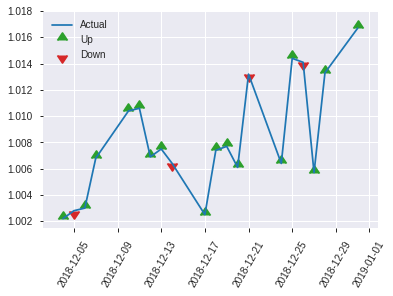


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17630495272884789
RMSE: 0.41988683324063386
LogLoss: 0.5299294421291354
Mean Per-Class Error: 0.22426470588235292
AUC: 0.824203431372549
pr_auc: 0.8095865849513793
Gini: 0.6484068627450981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5092520713806152: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      103  33   0.2426   (33.0/136.0)
1      26   94   0.2167   (26.0/120.0)
Total  129  127  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509252     0.761134  126
max f2                       0.326258     0.838323  187
max f0point5                 0.53464      0.765306  116
max accuracy                 0.53464      0.777344  116
max precision                0.908495     1         0
max recall                   0.138358     1         241
max specificity              0.908495     1         0
max absolute_mcc             0.53464      0.552436  116
max min_per_class_accuracy   0.515563     0.764706  123
max mean_per_class_accuracy  0.53464      0.775735  116

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.892452           2.13333   2.13333            1                0.903916  1                           0.903916            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.881492           2.13333   2.13333            1                0.886452  1                           0.895184            0.025           0.05                       113.333   113.333
    3        0.03125                     0.873522           2.13333   2.13333            1                0.876343  1                           0.890474            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.867603           2.13333   2.13333            1                0.869918  1                           0.884868            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.863622           2.13333   2.13333            1                0.865857  1                           0.881943            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.826426           1.80513   1.96923            0.846154         0.843753  0.923077                    0.862848            0.0916667       0.2                        80.5128   96.9231
    7        0.152344                    0.792348           1.96923   1.96923            0.923077         0.810117  0.923077                    0.845271            0.1             0.3                        96.9231   96.9231
    8        0.203125                    0.740757           1.64103   1.88718            0.769231         0.768886  0.884615                    0.826175            0.0833333       0.383333                   64.1026   88.7179
    9        0.300781                    0.656671           1.45067   1.74545            0.68             0.691114  0.818182                    0.782324            0.141667        0.525                      45.0667   74.5455
    10       0.402344                    0.559973           1.39487   1.65696            0.653846         0.604038  0.776699                    0.73732             0.141667        0.666667                   39.4872   65.6958
    11       0.5                         0.507337           1.19467   1.56667            0.56             0.538429  0.734375                    0.698474            0.116667        0.783333                   19.4667   56.6667
    12       0.601562                    0.444078           0.492308  1.38528            0.230769         0.480046  0.649351                    0.661596            0.05            0.833333                   -50.7692  38.5281
    13       0.699219                    0.355486           0.597333  1.27523            0.28             0.411201  0.597765                    0.626625            0.0583333       0.891667                   -40.2667  27.5233
    14       0.800781                    0.26312            0.574359  1.18634            0.269231         0.310241  0.556098                    0.586498            0.0583333       0.95                       -42.5641  18.6341
    15       0.898438                    0.168798           0.256     1.08522            0.12             0.220862  0.508696                    0.546755            0.025           0.975                      -74.4     8.52174
    16       1                           0.102029           0.246154  1                  0.115385         0.135574  0.46875                     0.504995         

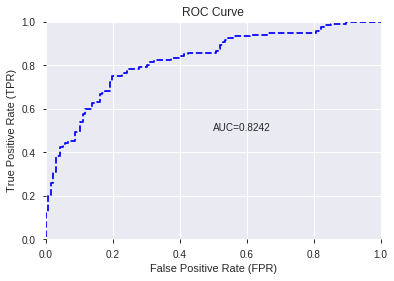

This function is available for GLM models only


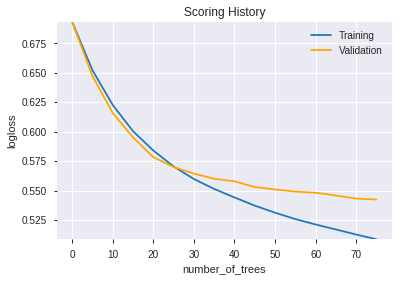

--2019-08-22 12:44:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.52
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.52|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124413_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124413_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'WILLR_12',
 'PLUS_DI_8',
 'CDLTAKURI',
 'ULTOSC',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'CCI_12',
 'CORREL_8',
 'TRANGE',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'DIV',
 'AROONOSC_8',
 'SUB',
 'PLUS_DM_8',
 'weekday_name',
 'CORREL_20',
 'MINUS_DI_12']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124456_model_1  0.797794  0.536933              0.311029  0.426604  0.181991

variable  relative_importance  scaled_importance    percentage
0                 STOCHF_fastk             0.527031           1.000000  1.592472e-02
1                    PLUS_DI_8             0.427466           0.811083  1.291628e-02
2                     WILLR_12             0.418820           0.794678  1.265502e-02
3                   MINUS_DI_8             0.409529           0.777048  1.237427e-02
4                         MULT             0.318636           0.604586  9.627868e-03
...                        ...                  ...                ...           ...
1017   BBANDS_upperband_24_7_4             0.000098           0.000186  2.955532e-06
1018   BBANDS_lowerband_24_2_5             0.000095           0.000181  2.881403e-06
1019  BBANDS_middleband_24_5_4             0.000056           0.000106  1.693637e-06
1020   BBANDS_lowerband_12_5_3             0.000048           0.000091  1.455553e-06
1021        LINEARREG_ANGLE_20             0.000019           0.000036  5.714641e-07

[1022 rows x 4 columns]

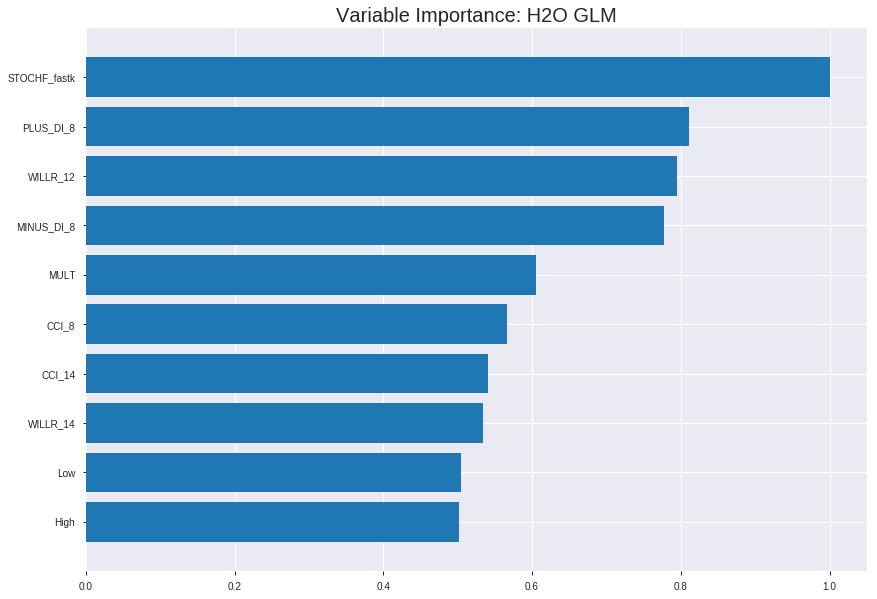

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124456_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.16436415935605506
RMSE: 0.4054184990303909
LogLoss: 0.49695400383210975
Null degrees of freedom: 1784
Residual degrees of freedom: 762
Null deviance: 2474.52142897845
Residual deviance: 1774.1257936806314
AIC: 3820.1257936806314
AUC: 0.8423852865482393
pr_auc: 0.8342630628527883
Gini: 0.6847705730964786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3855213884288735: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      511  379   0.4258   (379.0/890.0)
1      84   811   0.0939   (84.0/895.0)
Total  595  1190  0.2594   (463.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385521     0.777938  254
max f2                       0.301928     0.870093  289
max f0point5                 0.594508     0.775047  159
max accuracy                 0.50253      0.761345  198
max precision                1            1         0
max recall                   0.0292085    1         389
max specificity              1            1         0
max absolute_mcc             0.50253      0.522745  198
max min_per_class_accuracy   0.508368     0.757303  195
max mean_per_class_accuracy  0.50253      0.761318  198

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.967723           1.99441    1.99441            1                0.980046   1                           0.980046            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.955887           1.99441    1.99441            1                0.962123   1                           0.971084            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.941954           1.88361    1.95748            0.944444         0.949606   0.981481                    0.963925            0.0189944       0.0592179                  88.3613   95.748
    4        0.0403361                   0.927176           1.99441    1.96671            1                0.935188   0.986111                    0.956741            0.0201117       0.0793296                  99.4413   96.6713
    5        0.0504202                   0.918859           1.77281    1.92793            0.888889         0.922492   0.966667                    0.949891            0.0178771       0.0972067                  77.2812   92.7933
    6        0.10028                     0.862899           1.77032    1.84957            0.88764          0.892786   0.927374                    0.921498            0.0882682       0.185475                   77.0322   84.9568
    7        0.15014                     0.800574           1.68069    1.79348            0.842697         0.833237   0.899254                    0.892188            0.0837989       0.269274                   68.0685   79.3484
    8        0.2                         0.743026           1.68069    1.76536            0.842697         0.772886   0.885154                    0.862446            0.0837989       0.353073                   68.0685   76.5363
    9        0.30028                     0.65673            1.63787    1.72279            0.821229         0.698737   0.863806                    0.807774            0.164246        0.517318                   63.787    72.2786
    10       0.4                         0.587986           1.29973    1.61732            0.651685         0.622105   0.810924                    0.761487            0.129609        0.646927                   29.973    61.7318
    11       0.50028                     0.508541           1.09191    1.512              0.547486         0.548275   0.758119                    0.718749            0.109497        0.756425                   9.19135   51.2002
    12       0.6                         0.434072           0.873956   1.40596            0.438202         0.472175   0.704949                    0.677769            0.0871508       0.843575                   -12.6044  40.5959
    13       0.69972                     0.35502            0.817934   1.32216            0.410112         0.396787   0.66293                     0.637725            0.0815642       0.92514                    -18.2066  32.2157
    14       0.8                         0.257708           0.456821   1.21369            0.22905          0.310099   0.608543                    0.596657            0.0458101       0.97095                    -54.3179  21.3687
    15       0.89972                     0.108973           0.201682   1.10152            0.101124         0.187421   0.552304                    0.551299            0.0201117       0.991061                   -79.8318  10.1522
    16       1                           0.000321748        0.0891358  1                  0.0446927        0.0537048  0.501401  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18847917121739644
RMSE: 0.4341418791333041
LogLoss: 0.558760489627609
Null degrees of freedom: 509
Residual degrees of freedom: -513
Null deviance: 707.0141257874837
Residual deviance: 569.9356994201611
AIC: 2615.935699420161
AUC: 0.7864359861591695
pr_auc: 0.7708337106616829
Gini: 0.5728719723183391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42358638086363304: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  107  0.4196   (107.0/255.0)
1      46   209  0.1804   (46.0/255.0)
Total  194  316  0.3      (153.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423586     0.732049  242
max f2                       0.111813     0.85656   351
max f0point5                 0.607042     0.740552  144
max accuracy                 0.50426      0.717647  197
max precision                0.992202     1         0
max recall                   0.0247392    1         390
max specificity              0.992202     1         0
max absolute_mcc             0.607042     0.446673  144
max min_per_class_accuracy   0.50426      0.713725  197
max mean_per_class_accuracy  0.50426      0.717647  197

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.983202           1.66667   1.66667            0.833333         0.986601  0.833333                    0.986601            0.0196078       0.0196078                  66.6667   66.6667
    2        0.0215686                   0.976119           1.6       1.63636            0.8              0.978057  0.818182                    0.982718            0.0156863       0.0352941                  60        63.6364
    3        0.0313725                   0.961396           2         1.75               1                0.967906  0.875                       0.978089            0.0196078       0.054902                   100       75
    4        0.0411765                   0.955257           1.6       1.71429            0.8              0.958551  0.857143                    0.973437            0.0156863       0.0705882                  60        71.4286
    5        0.0509804                   0.941821           2         1.76923            1                0.949155  0.884615                    0.968768            0.0196078       0.0901961                  100       76.9231
    6        0.1                         0.895762           1.84      1.80392            0.92             0.916042  0.901961                    0.942922            0.0901961       0.180392                   84        80.3922
    7        0.15098                     0.828299           1.76923   1.79221            0.884615         0.870195  0.896104                    0.918365            0.0901961       0.270588                   76.9231   79.2208
    8        0.2                         0.767283           1.36      1.68627            0.68             0.79925   0.843137                    0.88917             0.0666667       0.337255                   36        68.6275
    9        0.3                         0.658765           1.52941   1.63399            0.764706         0.710761  0.816993                    0.8297              0.152941        0.490196                   52.9412   63.3987
    10       0.4                         0.577709           1.13725   1.5098             0.568627         0.613365  0.754902                    0.775616            0.113725        0.603922                   13.7255   50.9804
    11       0.5                         0.499891           1.09804   1.42745            0.54902          0.538309  0.713725                    0.728155            0.109804        0.713725                   9.80392   42.7451
    12       0.6                         0.433761           0.823529  1.3268             0.411765         0.465864  0.663399                    0.68444             0.0823529       0.796078                   -17.6471  32.6797
    13       0.7                         0.349652           0.666667  1.23249            0.333333         0.393114  0.616246                    0.642822            0.0666667       0.862745                   -33.3333  23.2493
    14       0.8                         0.240701           0.823529  1.18137            0.411765         0.301735  0.590686                    0.600186            0.0823529       0.945098                   -17.6471  18.1373
    15       0.9                         0.0892572          0.431373  1.09804            0.215686         0.161236  0.54902                     0.551414            0.0431373       0.988235                   -56.8627  9.80392
    16       1                           0.0106534          0.117647  1                  0.0588235        0.043937  0.5                         0.500666            0.


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:45:00  0.000 sec         2            .15E2     1000          1.3622301374281731  1.3629891613075906
     2019-08-22 12:45:03  2.312 sec         4            .11E2     1022          1.3550080785985272  1.3552162778230206
     2019-08-22 12:45:05  4.683 sec         6            .79E1     1023          1.3457656681965096  1.3451647900658694
     2019-08-22 12:45:08  7.302 sec         8            .57E1     1023          1.3341702679627734  1.332533319986555
     2019-08-22 12:45:10  9.671 sec         10           .42E1     1023          1.319965780273392   1.3171257086010988
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-22 12:46:00  59.732 sec        50           .73E-2    1023          0.9825617850460437  1.1177423311531494
     2019-08-22 12:46:02  1 min  2.083 sec  52           .53E-2    1023          0.9714045360109174  1.1183348343927557
     2019-08-22 12:46:05  1 min  4.605 sec  54           .39E-2    1023          0.9604415334868746  1.1193538619497594
     2019-08-22 12:46:07  1 min  6.974 sec  56           .28E-2    1023          0.9497582502346871  1.1207504395251142
     2019-08-22 12:46:10  1 min  9.365 sec  58           .2E-2     1023          0.9391433149785424  1.1225113133932902


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7421875)

('F1', 0.722408026755853)

('auc', 0.7977941176470589)

('logloss', 0.5369327376454548)

('mean_per_class_error', 0.267156862745098)

('rmse', 0.42660412726354435)

('mse', 0.18199108139829034)

glm prediction progress: |████████████████████████████████████████████████| 100%


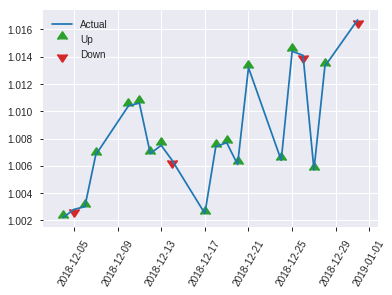


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18199108139829034
RMSE: 0.42660412726354435
LogLoss: 0.5369327376454548
Null degrees of freedom: 255
Residual degrees of freedom: -767
Null deviance: 354.9830011899469
Residual deviance: 274.9095616744729
AIC: 2320.909561674473
AUC: 0.7977941176470589
pr_auc: 0.7873257442684737
Gini: 0.5955882352941178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32035926262865433: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   71   0.5221   (71.0/136.0)
1      12   108  0.1      (12.0/120.0)
Total  77   179  0.3242   (83.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320359     0.722408  178
max f2                       0.108602     0.834502  232
max f0point5                 0.631735     0.75431   85
max accuracy                 0.631735     0.742188  85
max precision                0.980914     1         0
max recall                   0.0596713    1         245
max specificity              0.980914     1         0
max absolute_mcc             0.631735     0.492017  85
max min_per_class_accuracy   0.484971     0.705882  124
max mean_per_class_accuracy  0.631735     0.732843  85

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.974674           2.13333   2.13333            1                0.978328   1                           0.978328            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.967837           2.13333   2.13333            1                0.971946   1                           0.975137            0.025           0.05                       113.333   113.333
    3        0.03125                     0.962109           2.13333   2.13333            1                0.964026   1                           0.972359            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.958253           2.13333   2.13333            1                0.959882   1                           0.968957            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.94589            2.13333   2.13333            1                0.952287   1                           0.966392            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.895737           1.80513   1.96923            0.846154         0.920019   0.923077                    0.943206            0.0916667       0.2                        80.5128   96.9231
    7        0.152344                    0.818835           1.80513   1.91453            0.846154         0.859845   0.897436                    0.915419            0.0916667       0.291667                   80.5128   91.453
    8        0.203125                    0.760314           1.64103   1.84615            0.769231         0.783035   0.865385                    0.882323            0.0833333       0.375                      64.1026   84.6154
    9        0.300781                    0.660133           1.45067   1.71775            0.68             0.708174   0.805195                    0.825781            0.141667        0.516667                   45.0667   71.7749
    10       0.402344                    0.552602           1.06667   1.5534             0.5              0.607945   0.728155                    0.770793            0.108333        0.625                      6.66667   55.3398
    11       0.5                         0.475943           1.024     1.45               0.48             0.510401   0.679688                    0.719935            0.1             0.725                      2.4       45
    12       0.601562                    0.412054           0.820513  1.34372            0.384615         0.440725   0.62987                     0.672796            0.0833333       0.808333                   -17.9487  34.3723
    13       0.699219                    0.318739           0.938667  1.28715            0.44             0.377054   0.603352                    0.631491            0.0916667       0.9                        -6.13333  28.7151
    14       0.800781                    0.207259           0.410256  1.17593            0.192308         0.268184   0.55122                     0.585413            0.0416667       0.941667                   -58.9744  17.5935
    15       0.898438                    0.113287           0.341333  1.08522            0.16             0.157153   0.508696                    0.538863            0.0333333       0.975                      -65.8667  8.52174
    16       1                           0.0166167          0.246154  1                  0.115385         0.0670449  0.46875                     0.490

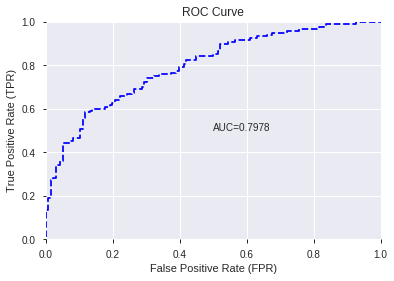

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


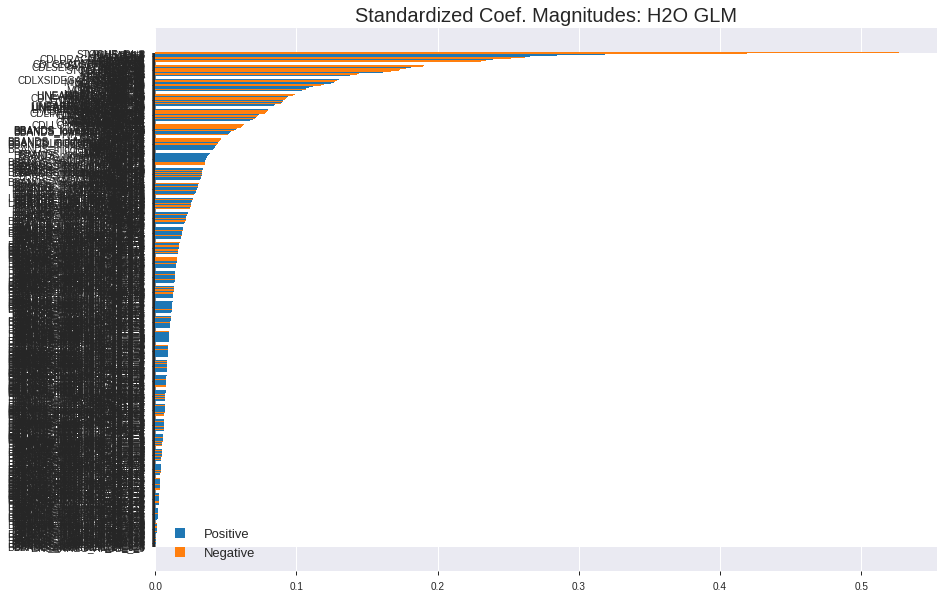

'log_likelihood'
--2019-08-22 12:46:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124456_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124456_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

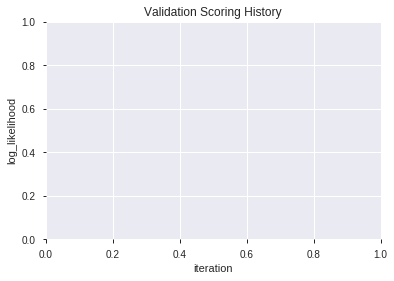

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124649_model_7  0.829473  0.512907              0.245588  0.413315  0.170830
1  XGBoost_grid_1_AutoML_20190822_124649_model_6  0.824755  0.525689              0.246078  0.418394  0.175053
2  XGBoost_grid_1_AutoML_20190822_124649_model_4  0.822549  0.534366              0.222304  0.421327  0.177517
3  XGBoost_grid_1_AutoML_20190822_124649_model_2  0.821630  0.529910              0.256373  0.419916  0.176330
4  XGBoost_grid_1_AutoML_20190822_124649_model_3  0.821140  0.536014              0.211029  0.422071  0.178144
5  XGBoost_grid_1_AutoML_20190822_124649_model_1  0.819118  0.531054              0.232108  0.422182  0.178237
6               XGBoost_1_AutoML_20190822_124649  0.818811  0.529176              0.259804  0.420528  0.176844
7               XGBoost_2_AutoML_20190822_124649  0.818444  0.530004              0.237255  0.419553  0.176025
8               XGBoost_3_AutoML_20190822_124649  0.808027  0.542324              0.239706  0.427115  0.182427
9  XGBoost_grid_1_AutoML_20190822_124649_model_5  0.774571  0.575643              0.276471  0.443638  0.196815

variable  relative_importance  scaled_importance  percentage
0           CDLDRAGONFLYDOJI           744.039062           1.000000    0.056648
1               STOCHF_fastk           598.854675           0.804870    0.045594
2                    WILLR_8           461.567780           0.620354    0.035142
3          CDLGRAVESTONEDOJI           424.105896           0.570005    0.032290
4                  CDLTAKURI           339.999634           0.456965    0.025886
..                       ...                  ...                ...         ...
397  BBANDS_lowerband_20_0_3             1.020920           0.001372    0.000078
398             HT_TRENDMODE             0.803806           0.001080    0.000061
399  BBANDS_lowerband_20_1_2             0.519344           0.000698    0.000040
400  BBANDS_lowerband_12_6_4             0.399567           0.000537    0.000030
401  BBANDS_upperband_30_1_2             0.271599           0.000365    0.000021

[402 rows x 4 columns]

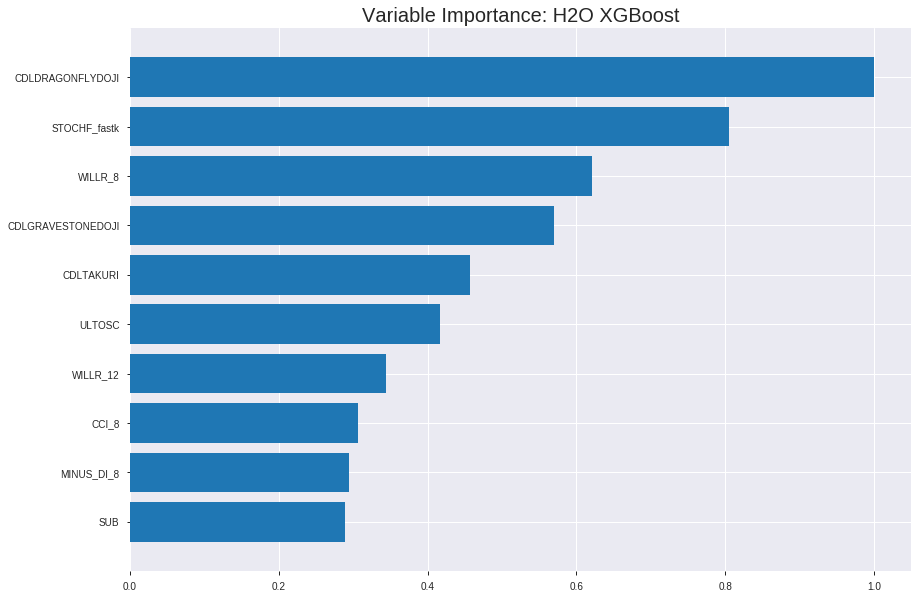

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124649_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07978393598390283
RMSE: 0.28246050340517137
LogLoss: 0.30208435863553684
Mean Per-Class Error: 0.054880421819094805
AUC: 0.9857761596886573
pr_auc: 0.9857650577249275
Gini: 0.9715523193773146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5105889737606049: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      838  52   0.0584   (52.0/890.0)
1      47   848  0.0525   (47.0/895.0)
Total  885  900  0.0555   (99.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510589     0.944847  195
max f2                       0.434518     0.956302  217
max f0point5                 0.581622     0.953577  170
max accuracy                 0.527555     0.945098  189
max precision                0.968834     1         0
max recall                   0.196926     1         319
max specificity              0.968834     1         0
max absolute_mcc             0.527555     0.89031   189
max min_per_class_accuracy   0.51814      0.94382   193
max mean_per_class_accuracy  0.527555     0.94512   189

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.939566           1.99441    1.99441            1                0.949858   1                           0.949858            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.930622           1.99441    1.99441            1                0.933985   1                           0.941922            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.922359           1.99441    1.99441            1                0.926456   1                           0.936766            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.916467           1.99441    1.99441            1                0.919949   1                           0.932562            0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.910504           1.99441    1.99441            1                0.912986   1                           0.928647            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.880861           1.99441    1.99441            1                0.895776   1                           0.912303            0.0994413       0.2                        99.4413   99.4413
    7        0.15014                     0.848318           1.99441    1.99441            1                0.864191   1                           0.896325            0.0994413       0.299441                   99.4413   99.4413
    8        0.2                         0.815121           1.99441    1.99441            1                0.832656   1                           0.880453            0.0994413       0.398883                   99.4413   99.4413
    9        0.30028                     0.744983           1.98327    1.99069            0.994413         0.779135   0.998134                    0.846617            0.198883        0.597765                   98.3271   99.0692
    10       0.4                         0.662551           1.91598    1.97207            0.960674         0.707084   0.988796                    0.811831            0.191061        0.788827                   91.5981   97.2067
    11       0.50028                     0.518633           1.53759    1.88498            0.77095          0.594165   0.945129                    0.768201            0.15419         0.943017                   53.7592   88.4978
    12       0.6                         0.356056           0.448183   1.64618            0.224719         0.426114   0.825397                    0.711346            0.0446927       0.987709                   -55.1817  64.6182
    13       0.69972                     0.267239           0.0672274  1.42116            0.0337079        0.309002   0.71257                     0.654006            0.00670391      0.994413                   -93.2773  42.1159
    14       0.8                         0.182293           0.0557099  1.25               0.027933         0.227208   0.626751                    0.600507            0.00558659      1                          -94.429   25
    15       0.89972                     0.10661            0          1.11146            0                0.143833   0.557285                    0.549892            0               1                          -100      11.1457
    16       1                           0.0340557          0          1                  0                0.0790597  0.501401      



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18262719851528006
RMSE: 0.4273490359358262
LogLoss: 0.5454117937573597
Mean Per-Class Error: 0.27254901960784306
AUC: 0.7997846981930027
pr_auc: 0.781488474613561
Gini: 0.5995693963860054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3685242533683777: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  106  0.4157   (106.0/255.0)
1      36   219  0.1412   (36.0/255.0)
Total  185  325  0.2784   (142.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368524     0.755172  256
max f2                       0.130177     0.850847  357
max f0point5                 0.5976       0.744986  151
max accuracy                 0.400455     0.727451  242
max precision                0.944781     1         0
max recall                   0.0635202    1         392
max specificity              0.944781     1         0
max absolute_mcc             0.400455     0.465058  242
max min_per_class_accuracy   0.498198     0.713725  199
max mean_per_class_accuracy  0.400455     0.727451  242

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.927054           1.66667   1.66667            0.833333         0.935127  0.833333                    0.935127            0.0196078       0.0196078                  66.6667   66.6667
    2        0.0215686                   0.920671           2         1.81818            1                0.924395  0.909091                    0.930249            0.0196078       0.0392157                  100       81.8182
    3        0.0313725                   0.908652           2         1.875              1                0.913832  0.9375                      0.925119            0.0196078       0.0588235                  100       87.5
    4        0.0411765                   0.892119           1.2       1.71429            0.6              0.899268  0.857143                    0.918964            0.0117647       0.0705882                  20        71.4286
    5        0.0509804                   0.878213           2         1.76923            1                0.883674  0.884615                    0.912177            0.0196078       0.0901961                  100       76.9231
    6        0.1                         0.831921           1.76      1.76471            0.88             0.852659  0.882353                    0.883002            0.0862745       0.176471                   76        76.4706
    7        0.15098                     0.797125           1.61538   1.71429            0.807692         0.814136  0.857143                    0.859748            0.0823529       0.258824                   61.5385   71.4286
    8        0.2                         0.763962           1.68      1.70588            0.84             0.780107  0.852941                    0.840228            0.0823529       0.341176                   68        70.5882
    9        0.3                         0.672741           1.56863   1.66013            0.784314         0.720602  0.830065                    0.800353            0.156863        0.498039                   56.8627   66.0131
    10       0.4                         0.585272           1.21569   1.54902            0.607843         0.628159  0.77451                     0.757304            0.121569        0.619608                   21.5686   54.902
    11       0.5                         0.496171           0.941176  1.42745            0.470588         0.541786  0.713725                    0.714201            0.0941176       0.713725                   -5.88235  42.7451
    12       0.6                         0.401467           1.09804   1.37255            0.54902          0.451195  0.686275                    0.670366            0.109804        0.823529                   9.80392   37.2549
    13       0.7                         0.322243           0.745098  1.28291            0.372549         0.361106  0.641457                    0.626186            0.0745098       0.898039                   -25.4902  28.2913
    14       0.8                         0.217731           0.431373  1.17647            0.215686         0.271394  0.588235                    0.581837            0.0431373       0.941176                   -56.8627  17.6471
    15       0.9                         0.120944           0.431373  1.09368            0.215686         0.169873  0.546841                    0.536064            0.0431373       0.984314                   -56.8627  9.36819
    16       1                           0.0436566          0.156863  1                  0.0784314        0.088457  0.5                         0.491303            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:48:02  46.092 sec  0                  0.5              0.693147            0.5             0                  1                0.498599                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-22 12:48:03  47.398 sec  5                  0.461076         0.617688            0.901505        0.897283           1.99441          0.177591                         0.474402           0.642858              0.775556          0.758314             1.66667            0.301961
    2019-08-22 12:48:03  47.724 sec  10                 0.432669         0.564522            0.919447        0.921267           1.99441          0.165266                         0.459214           0.613003              0.779915          0.760697             2                  0.288235
    2019-08-22 12:48:04  48.048 sec  15                 0.409171         0.52105             0.932039        0.931877           1.99441          0.137255                         0.448324           0.591128              0.790004          0.760917             2                  0.288235
    2019-08-22 12:48:04  48.365 sec  20                 0.389026         0.484133            0.941426        0.942155           1.99441          0.121569                         0.442192           0.578272              0.790573          0.763208             1.66667            0.278431
    2019-08-22 12:48:04  48.682 sec  25                 0.372527         0.454323            0.950127        0.951256           1.99441          0.115966                         0.437335           0.56777               0.792818          0.765658             2                  0.282353
    2019-08-22 12:48:05  49.001 sec  30                 0.35903          0.429847            0.954741        0.956113           1.99441          0.105882                         0.435492           0.563255              0.791534          0.769436             2                  0.290196
    2019-08-22 12:48:05  49.303 sec  35                 0.346003         0.407176            0.961284        0.96276            1.99441          0.0980392                        0.432906           0.557592              0.79511           0.771562             2                  0.276471
    2019-08-22 12:48:05  49.617 sec  40                 0.332709         0.384038            0.966784        0.964751           1.99441          0.0896359                        0.431393           0.554215              0.796417          0.7797               2                  0.280392
    2019-08-22 12:48:05  49.920 sec  45                 0.323162         0.367629            0.970689        0.970759           1.99441          0.0812325                        0.4298             0.550614              0.797832          0.778433             2                  0.290196
    2019-08-22 12:48:06  50.240 sec  50                 0.313724         0.351624            0.973978        0.973145           1.99441          0.0767507                        0.42873            0.548313              0.798493          0.775539             1.66667            0.270588
    2019-08-22 12:48:06  50.607 sec  55                 0.30544          0.337845            0.977494        0.976844           1.99441          0.0694678                        0.428029           0.546299              0.799369          0.7813

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
CDLDRAGONFLYDOJI         744.0390625            1.0                     0.056648210757614406
STOCHF_fastk             598.8546752929688      0.8048699395980554      0.045594441970819015
WILLR_8                  461.5677795410156      0.6203542297767675      0.03514195715277187
CDLGRAVESTONEDOJI        424.10589599609375     0.5700048792748617      0.03228975653403092
CDLTAKURI                339.9996337890625      0.45696476290727345     0.025886236197974522
---                      ---                    ---                     ---
BBANDS_lowerband_20_0_3  1.0209203958511353     0.0013721327915510286   7.772886756321647e-05
HT_TRENDMODE             0.8038063049316406     0.0010803280976012474   6.119865376028809e-05
BBANDS_lowerband_20_1_2  0.5193443298339844     0.0006980068063751483   3.954083667778875e-05
BBANDS_lowerband_12_6_4  0.399566650390625      0.0005370237538981699   3.0421434792668773e-05
BBANDS_upperband_30_1_2  0.27159881591796875    0.00036503300647332444  2.0678466684186505e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76171875)

('F1', 0.7557251908396947)

('auc', 0.8294730392156863)

('logloss', 0.5129066653057417)

('mean_per_class_error', 0.23897058823529416)

('rmse', 0.4133153916840843)

('mse', 0.17082961300296803)

xgboost prediction progress: |████████████████████████████████████████████| 100%


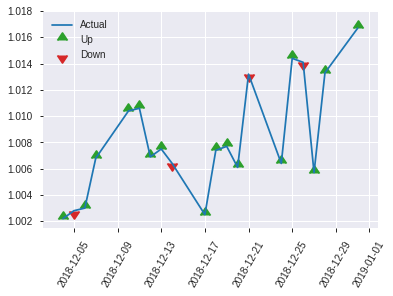


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17082961300296803
RMSE: 0.4133153916840843
LogLoss: 0.5129066653057417
Mean Per-Class Error: 0.23897058823529416
AUC: 0.8294730392156863
pr_auc: 0.8133006154476707
Gini: 0.6589460784313725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47559869289398193: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      93   43   0.3162   (43.0/136.0)
1      21   99   0.175    (21.0/120.0)
Total  114  142  0.25     (64.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475599     0.755725  141
max f2                       0.126293     0.84507   229
max f0point5                 0.617017     0.761719  97
max accuracy                 0.601253     0.761719  106
max precision                0.932158     1         0
max recall                   0.126293     1         229
max specificity              0.932158     1         0
max absolute_mcc             0.54059      0.521819  120
max min_per_class_accuracy   0.54059      0.75      120
max mean_per_class_accuracy  0.54059      0.761029  120

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.910117           2.13333   2.13333            1                0.923941   1                           0.923941            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.897505           2.13333   2.13333            1                0.903391   1                           0.913666            0.025           0.05                       113.333   113.333
    3        0.03125                     0.891116           2.13333   2.13333            1                0.893462   1                           0.908615            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.883971           2.13333   2.13333            1                0.888184   1                           0.903043            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.879883           2.13333   2.13333            1                0.881745   1                           0.899766            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.83221            1.96923   2.05128            0.923077         0.857021   0.961538                    0.878394            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.785857           2.13333   2.07863            1                0.806825   0.974359                    0.854537            0.108333        0.316667                   113.333   107.863
    8        0.203125                    0.752631           1.31282   1.88718            0.615385         0.769297   0.884615                    0.833227            0.0666667       0.383333                   31.2821   88.7179
    9        0.300781                    0.667283           1.36533   1.71775            0.64             0.711056   0.805195                    0.793561            0.133333        0.516667                   36.5333   71.7749
    10       0.402344                    0.610254           1.47692   1.65696            0.692308         0.634688   0.776699                    0.753457            0.15            0.666667                   47.6923   65.6958
    11       0.5                         0.522002           1.024     1.53333            0.48             0.558654   0.71875                     0.71541             0.1             0.766667                   2.4       53.3333
    12       0.601562                    0.43934            0.820513  1.41299            0.384615         0.478631   0.662338                    0.675434            0.0833333       0.85                       -17.9487  41.2987
    13       0.699219                    0.334299           0.512     1.28715            0.24             0.384937   0.603352                    0.634862            0.05            0.9                        -48.8     28.7151
    14       0.800781                    0.208659           0.574359  1.19675            0.269231         0.263284   0.560976                    0.587735            0.0583333       0.958333                   -42.5641  19.6748
    15       0.898438                    0.126166           0.426667  1.11304            0.2              0.159038   0.521739                    0.541137            0.0416667       1                          -57.3333  11.3043
    16       1                           0.0483136          0         1                  0                0.0897838  0.46875                    

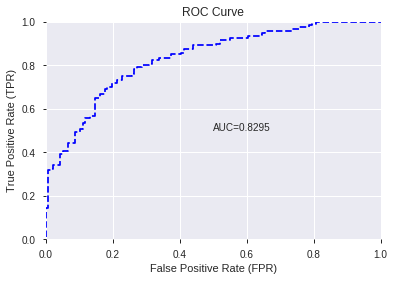

This function is available for GLM models only


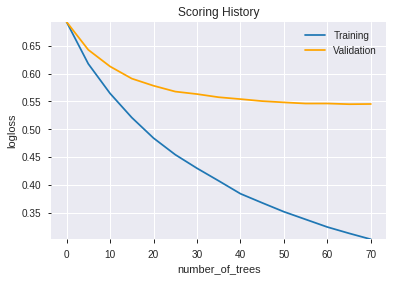

--2019-08-22 12:48:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124649_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124649_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_124824_model_8  0.823437  0.527664              0.239216  0.420494  0.176815
1  DeepLearning_grid_1_AutoML_20190822_124824_model_9  0.815870  0.545818              0.257598  0.429237  0.184244
2  DeepLearning_grid_1_AutoML_20190822_124824_model_6  0.795159  0.565979              0.286765  0.427209  0.182507
3  DeepLearning_grid_1_AutoML_20190822_124824_model_5  0.792708  0.556112              0.290931  0.436174  0.190247
4  DeepLearning_grid_1_AutoML_20190822_124824_model_3  0.765564  0.598097              0.318873  0.450460  0.202914
5               DeepLearning_1_AutoML_20190822_124824  0.765564  0.605975              0.290931  0.449376  0.201939
6  DeepLearning_grid_1_AutoML_20190822_124824_model_4  0.761520  0.633790              0.343873  0.463960  0.215259
7  DeepLearning_grid_1_AutoML_20190822_124824_model_7  0.759681  0.586608              0.335294  0.445700  0.198649
8  DeepLearning_grid_1_AutoML_20190822_124824_model_1  0.739767  0.797208              0.344118  0.475210  0.225825
9  DeepLearning_grid_1_AutoML_20190822_124824_model_2  0.736581  0.624556              0.336275  0.462008  0.213452

variable  relative_importance  scaled_importance  percentage
0        CDLRICKSHAWMAN             1.000000           1.000000    0.040009
1                   SUB             0.850208           0.850208    0.034016
2                TRANGE             0.840133           0.840133    0.033613
3                ULTOSC             0.778564           0.778564    0.031150
4          STOCHF_fastk             0.772100           0.772100    0.030891
5                 CCI_8             0.684727           0.684727    0.027396
6              WILLR_12             0.675522           0.675522    0.027027
7                   DIV             0.620394           0.620394    0.024822
8             CDLTAKURI             0.609633           0.609633    0.024391
9             PLUS_DI_8             0.602074           0.602074    0.024089
10               CCI_12             0.601348           0.601348    0.024060
11           MINUS_DI_8             0.582617           0.582617    0.023310
12     CDLDRAGONFLYDOJI             0.572682           0.572682    0.022913
13              WILLR_8             0.572451           0.572451    0.022903
14    CDLGRAVESTONEDOJI             0.552595           0.552595    0.022109
15             CORREL_8             0.549183           0.549183    0.021972
16         weekday_name             0.536148           0.536148    0.021451
17          MINUS_DI_12             0.529371           0.529371    0.021180
18            CORREL_20             0.521706           0.521706    0.020873
19   CDLSEPARATINGLINES             0.515252           0.515252    0.020615
20            PLUS_DM_8             0.497572           0.497572    0.019908
21       CDL3LINESTRIKE             0.474893           0.474893    0.019000
22         CDLTASUKIGAP             0.473167           0.473167    0.018931
23        CDLHANGINGMAN             0.471576           0.471576    0.018867
24                VAR_8             0.469030           0.469030    0.018766
25      CDLADVANCEBLOCK             0.465859           0.465859    0.018639
26          CDLBELTHOLD             0.458174           0.458174    0.018331
27    CDLINVERTEDHAMMER             0.449058           0.449058    0.017967
28           MINUS_DM_8             0.443785           0.443785    0.017756
29          CDLPIERCING             0.442576           0.442576    0.017707
30           AROONOSC_8             0.440798           0.440798    0.017636
31  CDLXSIDEGAP3METHODS             0.432249           0.432249    0.017294
32   CDLEVENINGDOJISTAR             0.425711           0.425711    0.017032
33            CDLONNECK             0.421930           0.421930    0.016881
34       is_month_start             0.412077           0.412077    0.016487
35       CDLEVENINGSTAR             0.398757           0.398757    0.015954
36   CDLCLOSINGMARUBOZU             0.396264           0.396264    0.015854
37       CDLMATCHINGLOW             0.382942           0.382942    0.015321
38      CDLSHOOTINGSTAR             0.379620           0.379620    0.015188
39   CDLMORNINGDOJISTAR             0.369763           0.369763    0.014794
40         is_month_end             0.369309           0.369309    0.014776
41          CDL3OUTSIDE             0.356176           0.356176    0.014250
42       CDLMORNINGSTAR             0.348461           0.348461    0.013942
43     is_quarter_start             0.347558           0.347558    0.013906
44       CDLHARAMICROSS             0.343212           0.343212    0.013732
45         CDLENGULFING             0.339497           0.339497    0.013583
46           CDL3INSIDE             0.335481           0.335481    0.013422
47            CDLHAMMER             0.320880           0.320880    0.012838
48       is_quarter_end             0.314472           0.314472    0.012582
49     CDLCOUNTERATTACK             0.246552           0.246552    0.009864

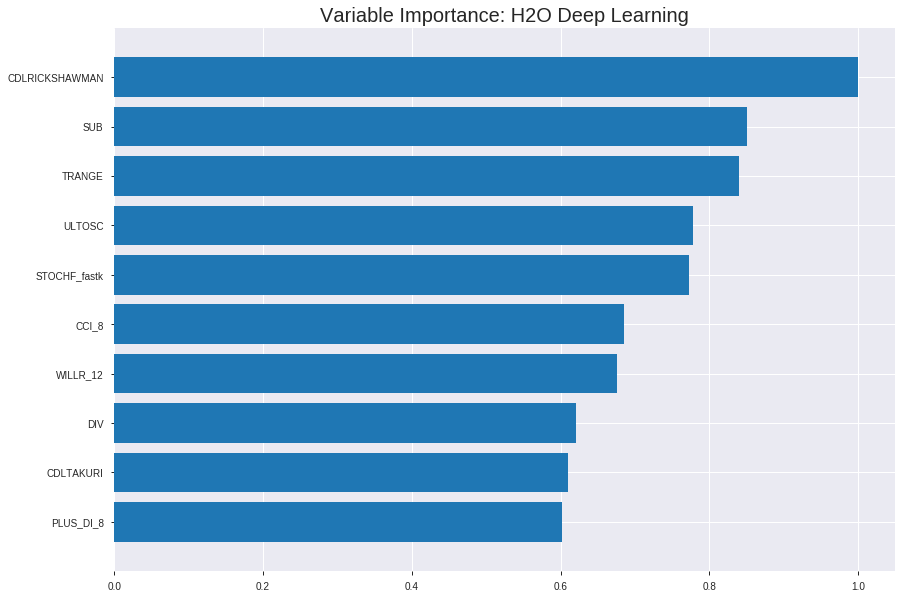

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_124824_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16676970994222587
RMSE: 0.40837447268680477
LogLoss: 0.49102107067198275
Mean Per-Class Error: 0.27371476994538946
AUC: 0.8230217814324273
pr_auc: 0.8324710938578651
Gini: 0.6460435628648546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.350728325977131: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  460   0.5169   (460.0/890.0)
1      52   843   0.0581   (52.0/895.0)
Total  482  1303  0.2868   (512.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350728     0.767061  266
max f2                       0.220578     0.8703    313
max f0point5                 0.571635     0.753787  149
max accuracy                 0.462233     0.726611  218
max precision                0.998929     1         0
max recall                   0.0105812    1         394
max specificity              0.998929     1         0
max absolute_mcc             0.350728     0.478681  266
max min_per_class_accuracy   0.508829     0.71236   188
max mean_per_class_accuracy  0.462233     0.726285  218

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.985718           1.99441    1.99441            1                0.989909   1                           0.989909            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.982579           1.99441    1.99441            1                0.984044   1                           0.986977            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.979064           1.99441    1.99441            1                0.981169   1                           0.985041            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.973201           1.99441    1.99441            1                0.976472   1                           0.982899            0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.968841           1.99441    1.99441            1                0.970989   1                           0.980517            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.929859           1.92719    1.96099            0.966292         0.951989   0.98324                     0.966333            0.0960894       0.196648                   92.7186   96.0987
    7        0.15014                     0.837278           1.79273    1.90511            0.898876         0.889103   0.955224                    0.940685            0.0893855       0.286034                   79.2731   90.5111
    8        0.2                         0.713455           1.68069    1.84916            0.842697         0.776986   0.927171                    0.899875            0.0837989       0.369832                   68.0685   84.9162
    9        0.30028                     0.545182           1.34818    1.68186            0.675978         0.611084   0.843284                    0.803432            0.135196        0.505028                   34.8179   68.1856
    10       0.431933                    0.532815           1.01842    1.47964            0.510638         0.53435    0.741894                    0.721416            0.134078        0.639106                   1.84239   47.9643
    11       0.50028                     0.509139           1.07894    1.4249             0.540984         0.520425   0.714446                    0.693957            0.073743        0.712849                   7.8945    42.49
    12       0.6                         0.468215           1.08684    1.36872            0.544944         0.488441   0.686275                    0.6598              0.10838         0.821229                   8.68433   36.8715
    13       0.69972                     0.40105            0.952388   1.30938            0.477528         0.440416   0.656525                    0.628535            0.0949721       0.916201                   -4.76116  30.9383
    14       0.8                         0.228713           0.568241   1.21648            0.284916         0.318464   0.609944                    0.589668            0.0569832       0.973184                   -43.1759  21.648
    15       0.89972                     0.0704921          0.212887   1.10525            0.106742         0.152308   0.554172                    0.541193            0.0212291       0.994413                   -78.7113  10.5248
    16       1                           0.000206575        0.0557099  1                  0.027933         0.0318469  0.501401    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17789894267186704
RMSE: 0.4217806807712594
LogLoss: 0.5324161222306173
Mean Per-Class Error: 0.2450980392156863
AUC: 0.8103114186851211
pr_auc: 0.7945091382950723
Gini: 0.6206228373702423
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4883523448752879: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      163  92   0.3608   (92.0/255.0)
1      33   222  0.1294   (33.0/255.0)
Total  196  314  0.2451   (125.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488352     0.780316  215
max f2                       0.286512     0.862676  294
max f0point5                 0.488352     0.734613  215
max accuracy                 0.488352     0.754902  215
max precision                0.991783     1         0
max recall                   0.00605322   1         399
max specificity              0.991783     1         0
max absolute_mcc             0.488352     0.524023  215
max min_per_class_accuracy   0.523472     0.72549   166
max mean_per_class_accuracy  0.488352     0.754902  215

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.984054           2          2                  1                0.986701   1                           0.986701            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.97882            1.2        1.63636            0.6              0.98119    0.818182                    0.984196            0.0117647       0.0352941                  20        63.6364
    3        0.0313725                   0.973538           2          1.75               1                0.975678   0.875                       0.981534            0.0196078       0.054902                   100       75
    4        0.0411765                   0.965623           2          1.80952            1                0.968678   0.904762                    0.978473            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.962346           2          1.84615            1                0.963686   0.923077                    0.97563             0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.924297           1.84       1.84314            0.92             0.947099   0.921569                    0.961644            0.0901961       0.184314                   84        84.3137
    7        0.15098                     0.844612           1.84615    1.84416            0.923077         0.886034   0.922078                    0.936114            0.0941176       0.278431                   84.6154   84.4156
    8        0.2                         0.731567           1.76       1.82353            0.88             0.7812     0.911765                    0.898144            0.0862745       0.364706                   76        82.3529
    9        0.3                         0.540157           1.05882    1.56863            0.529412         0.609747   0.784314                    0.802012            0.105882        0.470588                   5.88235   56.8627
    10       0.470588                    0.532815           1.21839    1.44167            0.609195         0.533741   0.720833                    0.704764            0.207843        0.678431                   21.8391   44.1667
    11       0.5                         0.522904           1.6        1.45098            0.8              0.527317   0.72549                     0.694326            0.0470588       0.72549                    60        45.098
    12       0.6                         0.493462           1.21569    1.41176            0.607843         0.507944   0.705882                    0.663262            0.121569        0.847059                   21.5686   41.1765
    13       0.7                         0.445699           0.705882   1.31092            0.352941         0.473997   0.655462                    0.636224            0.0705882       0.917647                   -29.4118  31.0924
    14       0.8                         0.24041            0.431373   1.20098            0.215686         0.363218   0.60049                     0.602098            0.0431373       0.960784                   -56.8627  20.098
    15       0.9                         0.0611294          0.352941   1.10675            0.176471         0.137374   0.553377                    0.550462            0.0352941       0.996078                   -64.7059  10.6754
    16       1                           0.00605322         0.0392157  1                  0.0196078        0.0346749  0.5                 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:54:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:54:33  1 min 15.592 sec  573 obs/sec       0.501401  1             895        0.530537         0.851531            -0.125888      0.748389        0.743428           1.55121          0.371429                         0.51449            0.785171              -0.0587991       0.764168          0.752548             1.66667            0.35098
    2019-08-22 12:54:44  1 min 26.436 sec  940 obs/sec       6.00616   12            10721      0.467058         0.616652            0.12742        0.770642        0.782808           1.99441          0.340056                         0.465605           0.621588              0.132846         0.808973          0.78816              1.33333            0.260784
    2019-08-22 12:54:54  1 min 37.264 sec  1053 obs/sec      12.5109   25            22332      0.437381         0.552678            0.234784       0.806206        0.813412           1.99441          0.309804                         0.439419           0.566187              0.227645         0.796132          0.777018             1.33333            0.286275
    2019-08-22 12:55:05  1 min 47.644 sec  1110 obs/sec      19.0095   38            33932      0.430253         0.53967             0.259522       0.800372        0.809817           1.99441          0.32605                          0.433718           0.560403              0.247556         0.774594          0.764287             1.66667            0.292157
    2019-08-22 12:55:15  1 min 58.096 sec  1163 obs/sec      26.0034   52            46416      0.419231         0.51646             0.296976       0.8093          0.820956           1.99441          0.294678                         0.429752           0.555605              0.261253         0.79654           0.781901             1.66667            0.284314
    2019-08-22 12:55:27  2 min  9.743 sec  1202 obs/sec      33.9933   68            60678      0.408374         0.491021            0.332916       0.823022        0.832471           1.99441          0.286835                         0.421781           0.532416              0.288404         0.810311          0.794509             2                  0.245098
    2019-08-22 12:55:38  2 min 20.650 sec  1238 obs/sec      41.8947   84            74782      0.40887          0.494876            0.331296       0.828601        0.825544           1.99441          0.290196                         0.436747           0.591392              0.237009         0.770719          0.768163             1.66667            0.309804
    2019-08-22 12:55:48  2 min 31.284 sec  1235 obs/sec      48.4325   97            86452      0.402837         0.477552            0.350883       0.838528        0.846159           1.99441          0.281232                         0.432684           0.572441              0.251139         0.780308          0.768989             2                  0.292157
    2019-08-22 12:55:50 

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLRICKSHAWMAN    1.0                    1.0                  0.04000943842862224
SUB               0.8502083420753479     0.8502083420753479   0.03401635831376463
TRANGE            0.8401329517364502     0.8401329517364502   0.03361324760435617
ULTOSC            0.7785636782646179     0.7785636782646179   0.03114989554828989
STOCHF_fastk      0.7721002697944641     0.7721002697944641   0.030891298205064234
---               ---                    ---                  ---
CDLENGULFING      0.33949682116508484    0.33949682116508484  0.013583077163117439
CDL3INSIDE        0.33548134565353394    0.33548134565353394  0.013422420242876402
CDLHAMMER         0.32087963819503784    0.32087963819503784  0.012838214127362949
is_quarter_end    0.31447210907936096    0.31447210907936096  0.012581852485729671
CDLCOUNTERATTACK  0.24655191600322723    0.24655191600322723  0.009864403702789962


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7578125)

('F1', 0.7578125)

('auc', 0.8234374999999999)

('logloss', 0.5276636962883784)

('mean_per_class_error', 0.23921568627450984)

('rmse', 0.42049351595869017)

('mse', 0.1768147969633012)

deeplearning prediction progress: |███████████████████████████████████████| 100%


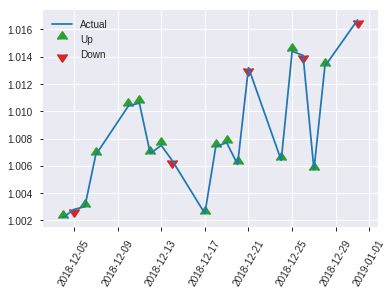


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1768147969633012
RMSE: 0.42049351595869017
LogLoss: 0.5276636962883784
Mean Per-Class Error: 0.23921568627450984
AUC: 0.8234374999999999
pr_auc: 0.8104045355420214
Gini: 0.6468749999999999
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5220548551736658: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   39   0.2868   (39.0/136.0)
1      23   97   0.1917   (23.0/120.0)
Total  120  136  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522055     0.757812  94
max f2                       0.387669     0.845808  146
max f0point5                 0.538362     0.761905  74
max accuracy                 0.530162     0.757812  88
max precision                0.99187      1         0
max recall                   0.0517651    1         197
max specificity              0.99187      1         0
max absolute_mcc             0.522055     0.521569  94
max min_per_class_accuracy   0.532129     0.742647  83
max mean_per_class_accuracy  0.522055     0.760784  94

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.986899           2.13333   2.13333            1                0.990219   1                           0.990219            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.980795           2.13333   2.13333            1                0.982985   1                           0.986602            0.025           0.05                       113.333   113.333
    3        0.03125                     0.977175           2.13333   2.13333            1                0.978722   1                           0.984632            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.970928           2.13333   2.13333            1                0.973744   1                           0.981663            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.966114           2.13333   2.13333            1                0.969711   1                           0.979824            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.928801           1.96923   2.05128            0.923077         0.947911   0.961538                    0.963867            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.847068           1.64103   1.91453            0.769231         0.899413   0.897436                    0.942383            0.0833333       0.291667                   64.1026   91.453
    8        0.203125                    0.77992            1.80513   1.88718            0.846154         0.802945   0.884615                    0.907523            0.0916667       0.383333                   80.5128   88.7179
    9        0.300781                    0.536741           1.536     1.77316            0.72             0.643218   0.831169                    0.82171             0.15            0.533333                   53.6      77.316
    10       0.484375                    0.532815           1.13475   1.53118            0.531915         0.533001   0.717742                    0.71228             0.208333        0.741667                   13.4752   53.1183
    11       0.5                         0.530924           1.6       1.53333            0.75             0.531568   0.71875                     0.706632            0.025           0.766667                   60        53.3333
    12       0.601562                    0.490154           0.738462  1.39913            0.346154         0.512035   0.655844                    0.673778            0.075           0.841667                   -26.1538  39.9134
    13       0.699219                    0.43352            0.682667  1.29907            0.32             0.466095   0.608939                    0.644772            0.0666667       0.908333                   -31.7333  29.9069
    14       0.800781                    0.206562           0.410256  1.18634            0.192308         0.339268   0.556098                    0.606025            0.0416667       0.95                       -58.9744  18.6341
    15       0.898438                    0.0796169          0.170667  1.07594            0.08             0.142728   0.504348                    0.555667            0.0166667       0.966667                   -82.9333  7.5942
    16       1                           0.00599882         0.328205  1                  0.153846         0.0375078  0.46875                     0.

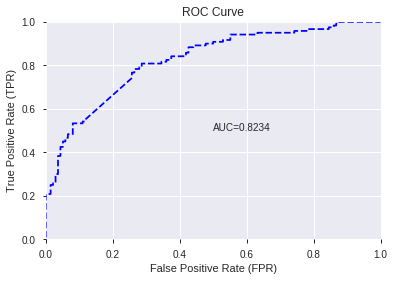

This function is available for GLM models only


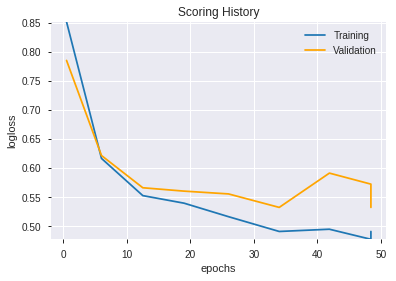

--2019-08-22 12:57:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_124824_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_124824_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLRICKSHAWMAN',
 'SUB',
 'TRANGE',
 'ULTOSC',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_12',
 'DIV',
 'CDLTAKURI',
 'PLUS_DI_8',
 'CCI_12',
 'MINUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'CORREL_8',
 'weekday_name',
 'MINUS_DI_12',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'PLUS_DM_8',
 'CDL3LINESTRIKE',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'VAR_8',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLINVERTEDHAMMER',
 'MINUS_DM_8',
 'CDLPIERCING',
 'AROONOSC_8',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'is_month_start',
 'CDLEVENINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'CDL3OUTSIDE',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLHARAMICROSS',
 'CDLENGULFING',
 'CDL3INSIDE',
 'CDLHAMMER',
 'is_quarter_end',
 'CDLCOUNTERATTACK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190822_125728_model_1  0.800735  0.54054              0.264216  0.42907  0.184101

variable  relative_importance  scaled_importance  percentage
0                 CCI_8             0.552869           1.000000    0.086438
1              WILLR_12             0.542511           0.981265    0.084819
2          STOCHF_fastk             0.501426           0.906953    0.078396
3               WILLR_8             0.391071           0.707349    0.061142
4             PLUS_DI_8             0.356235           0.644339    0.055696
5                CCI_12             0.351199           0.635230    0.054908
6            MINUS_DI_8             0.336869           0.609310    0.052668
7      CDLDRAGONFLYDOJI             0.304058           0.549964    0.047538
8             CDLTAKURI             0.288696           0.522177    0.045136
9     CDLGRAVESTONEDOJI             0.226342           0.409395    0.035387
10   CDLSEPARATINGLINES             0.184932           0.334496    0.028913
11           AROONOSC_8             0.164452           0.297453    0.025711
12            PLUS_DM_8             0.162271           0.293508    0.025370
13  CDLXSIDEGAP3METHODS             0.140114           0.253430    0.021906
14       is_quarter_end             0.137738           0.249134    0.021535
15       CDLRICKSHAWMAN             0.136226           0.246399    0.021298
16          CDLBELTHOLD             0.106277           0.192228    0.016616
17               ULTOSC             0.104773           0.189509    0.016381
18          CDLPIERCING             0.096652           0.174818    0.015111
19               TRANGE             0.096558           0.174649    0.015096
20    CDLINVERTEDHAMMER             0.081800           0.147956    0.012789
21          MINUS_DI_12             0.081707           0.147788    0.012775
22         CDLTASUKIGAP             0.081246           0.146954    0.012702
23                  DIV             0.077966           0.141021    0.012190
24      CDLADVANCEBLOCK             0.075924           0.137327    0.011870
25             CORREL_8             0.071587           0.129482    0.011192
26   CDLEVENINGDOJISTAR             0.069520           0.125744    0.010869
27       CDL3LINESTRIKE             0.067379           0.121872    0.010534
28       is_month_start             0.059973           0.108475    0.009376
29        CDLHANGINGMAN             0.059077           0.106855    0.009236
30      CDLSHOOTINGSTAR             0.055211           0.099862    0.008632
31         weekday_name             0.049094           0.088799    0.007676
32          CDL3OUTSIDE             0.042304           0.076517    0.006614
33                VAR_8             0.040378           0.073034    0.006313
34     CDLCOUNTERATTACK             0.038982           0.070509    0.006095
35         CDLENGULFING             0.038266           0.069213    0.005983
36            CDLHAMMER             0.032091           0.058045    0.005017
37            CORREL_20             0.030785           0.055682    0.004813
38           MINUS_DM_8             0.026878           0.048616    0.004202
39     is_quarter_start             0.024519           0.044349    0.003833
40           CDL3INSIDE             0.021593           0.039056    0.003376
41            CDLONNECK             0.017816           0.032225    0.002785
42   CDLMORNINGDOJISTAR             0.017726           0.032061    0.002771
43         is_month_end             0.013642           0.024675    0.002133
44       CDLMORNINGSTAR             0.012464           0.022545    0.001949
45                  SUB             0.012000           0.021705    0.001876
46   CDLCLOSINGMARUBOZU             0.006302           0.011399    0.000985
47       CDLHARAMICROSS             0.005736           0.010376    0.000897
48       CDLEVENINGSTAR             0.002768           0.005007    0.000433
49       CDLMATCHINGLOW             0.000101           0.000183    0.000016

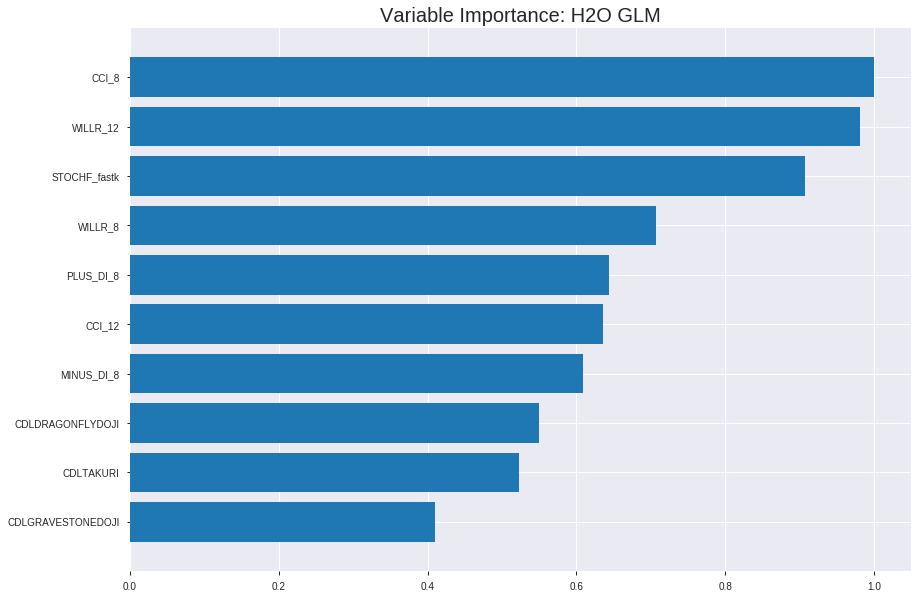

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_125728_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18490207127329544
RMSE: 0.43000240845057536
LogLoss: 0.5450377098353326
Null degrees of freedom: 1784
Residual degrees of freedom: 1734
Null deviance: 2474.52142897845
Residual deviance: 1945.7846241121374
AIC: 2047.7846241121374
AUC: 0.7952965915510639
pr_auc: 0.7905748823316463
Gini: 0.5905931831021278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4359996914418943: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      514  376   0.4225   (376.0/890.0)
1      138  757   0.1542   (138.0/895.0)
Total  652  1133  0.288    (514.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436        0.746548  238
max f2                       0.189687     0.856198  334
max f0point5                 0.53116      0.722758  184
max accuracy                 0.465439     0.713725  221
max precision                0.992688     1         0
max recall                   0.035372     1         390
max specificity              0.992688     1         0
max absolute_mcc             0.438275     0.440555  237
max min_per_class_accuracy   0.504882     0.70838   199
max mean_per_class_accuracy  0.465439     0.713533  221

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.951267           1.99441   1.99441            1                0.964091   1                           0.964091            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.940249           1.88361   1.93901            0.944444         0.94687    0.972222                    0.955481            0.0189944       0.0391061                  88.3613   93.9013
    3        0.0302521                   0.926282           1.88361   1.92055            0.944444         0.933018   0.962963                    0.947993            0.0189944       0.0581006                  88.3613   92.0546
    4        0.0403361                   0.912067           1.66201   1.85591            0.833333         0.917919   0.930556                    0.940475            0.0167598       0.0748603                  66.2011   85.5912
    5        0.0504202                   0.900586           1.77281   1.83929            0.888889         0.905316   0.922222                    0.933443            0.0178771       0.0927374                  77.2812   83.9292
    6        0.10028                     0.837192           1.79273   1.81614            0.898876         0.866966   0.910615                    0.90039             0.0893855       0.182123                   79.2731   81.6142
    7        0.15014                     0.761979           1.7255    1.78604            0.865169         0.800877   0.895522                    0.867343            0.0860335       0.268156                   72.5504   78.6042
    8        0.2                         0.710031           1.59105   1.73743            0.797753         0.733936   0.871148                    0.834085            0.0793296       0.347486                   59.1049   73.743
    9        0.30028                     0.620814           1.32589   1.6                0.664804         0.660247   0.802239                    0.776031            0.132961        0.480447                   32.5895   59.9996
    10       0.4                         0.557287           1.2325    1.50838            0.617978         0.587749   0.756303                    0.729092            0.122905        0.603352                   23.2503   50.838
    11       0.50028                     0.502318           1.04735   1.41597            0.52514          0.528083   0.709966                    0.6888              0.105028        0.70838                    4.73456   41.5967
    12       0.6                         0.450145           1.05323   1.35568            0.52809          0.474969   0.679739                    0.653262            0.105028        0.813408                   5.32296   35.568
    13       0.69972                     0.394194           0.739502  1.26787            0.370787         0.423104   0.635709                    0.620461            0.073743        0.887151                   -26.0498  26.7866
    14       0.8                         0.321328           0.623951  1.18715            0.312849         0.363686   0.595238                    0.588274            0.0625698       0.949721                   -37.6049  18.7151
    15       0.89972                     0.12655            0.380955  1.0978             0.191011         0.239712   0.550436                    0.549641            0.0379888       0.987709                   -61.9045  9.77967
    16       1                           0.00645377         0.122562  1                  0.0614525        0.0685813  0.501401                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1880463825370518
RMSE: 0.43364315114740576
LogLoss: 0.5527731842038128
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 707.0141257874837
Residual deviance: 563.8286478878891
AIC: 665.8286478878891
AUC: 0.7850519031141868
pr_auc: 0.7771338071514955
Gini: 0.5701038062283736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668884533958096: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      148  107  0.4196   (107.0/255.0)
1      42   213  0.1647   (42.0/255.0)
Total  190  320  0.2922   (149.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466888     0.74087   251
max f2                       0.256647     0.855263  329
max f0point5                 0.631277     0.716578  136
max accuracy                 0.516611     0.707843  215
max precision                0.982297     1         0
max recall                   0.0415369    1         392
max specificity              0.982297     1         0
max absolute_mcc             0.466888     0.429887  251
max min_per_class_accuracy   0.532454     0.690196  202
max mean_per_class_accuracy  0.466888     0.707843  251

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.970889           2         2                  1                0.978002   1                           0.978002            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.955283           1.2       1.63636            0.6              0.963125   0.818182                    0.97124             0.0117647       0.0352941                  20        63.6364
    3        0.0313725                   0.947752           2         1.75               1                0.950751   0.875                       0.964837            0.0196078       0.054902                   100       75
    4        0.0411765                   0.943569           2         1.80952            1                0.945946   0.904762                    0.960339            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.933709           1.6       1.76923            0.8              0.938992   0.884615                    0.956234            0.0156863       0.0901961                  60        76.9231
    6        0.1                         0.889702           2         1.88235            1                0.91396    0.941176                    0.935511            0.0980392       0.188235                   100       88.2353
    7        0.15098                     0.841617           1.69231   1.81818            0.846154         0.867359   0.909091                    0.912499            0.0862745       0.27451                    69.2308   81.8182
    8        0.2                         0.784126           1.44      1.72549            0.72             0.811108   0.862745                    0.887648            0.0705882       0.345098                   44        72.549
    9        0.3                         0.655797           1.33333   1.59477            0.666667         0.716102   0.797386                    0.830466            0.133333        0.478431                   33.3333   59.4771
    10       0.4                         0.582539           1.09804   1.47059            0.54902          0.616569   0.735294                    0.776992            0.109804        0.588235                   9.80392   47.0588
    11       0.5                         0.531467           1.01961   1.38039            0.509804         0.557223   0.690196                    0.733038            0.101961        0.690196                   1.96078   38.0392
    12       0.6                         0.482707           1.05882   1.3268             0.529412         0.507943   0.663399                    0.695522            0.105882        0.796078                   5.88235   32.6797
    13       0.7                         0.416868           0.784314  1.2493             0.392157         0.448477   0.62465                     0.66023             0.0784314       0.87451                    -21.5686  24.93
    14       0.8                         0.332003           0.666667  1.17647            0.333333         0.383108   0.588235                    0.62559             0.0666667       0.941176                   -33.3333  17.6471
    15       0.9                         0.111405           0.431373  1.09368            0.215686         0.202627   0.546841                    0.578594            0.0431373       0.984314                   -56.8627  9.36819
    16       1                           0.0221787          0.156863  1                  0.0784314        0.0641968  0.5                         0.527154   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:57:29  0.000 sec   2            .15E2     48            1.370475027188685   1.3669938698817896
     2019-08-22 12:57:29  0.033 sec   4            .92E1     51            1.3617895740892512  1.3564057030195862
     2019-08-22 12:57:29  0.060 sec   6            .57E1     51            1.3491040759042867  1.3409742715065553
     2019-08-22 12:57:29  0.078 sec   8            .36E1     51            1.3314763906705247  1.319626631022526
     2019-08-22 12:57:29  0.096 sec   10           .22E1     51            1.308530925020666   1.2921110629247445
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:57:29  0.297 sec   34           .73E-2    51            1.0862016817919373  1.1062679197852077
     2019-08-22 12:57:29  0.316 sec   36           .45E-2    51            1.0837721383721122  1.1075453109701405
     2019-08-22 12:57:29  0.338 sec   38           .28E-2    51            1.0822732284797072  1.1090460223520762
     2019-08-22 12:57:29  0.355 sec   40           .17E-2    51            1.0813638452643815  1.1106636615890264
     2019-08-22 12:57:29  0.364 sec   42           .11E-2    51            1.0808304750922177  1.1123677773843987


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.728)

('auc', 0.8007352941176471)

('logloss', 0.5405395376721251)

('mean_per_class_error', 0.26421568627450975)

('rmse', 0.4290697451195293)

('mse', 0.18410084617693784)

glm prediction progress: |████████████████████████████████████████████████| 100%


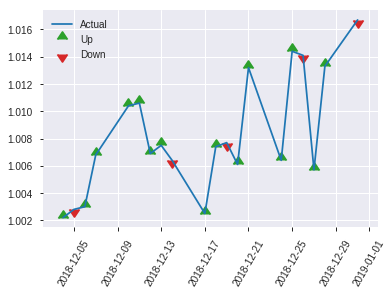


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18410084617693784
RMSE: 0.4290697451195293
LogLoss: 0.5405395376721251
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9830011899469
Residual deviance: 276.7562432881281
AIC: 378.7562432881281
AUC: 0.8007352941176471
pr_auc: 0.7963355869940013
Gini: 0.6014705882352942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5135310738710314: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      97   39   0.2868   (39.0/136.0)
1      29   91   0.2417   (29.0/120.0)
Total  126  130  0.2656   (68.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513531     0.728     129
max f2                       0.10059      0.834492  238
max f0point5                 0.641637     0.756881  78
max accuracy                 0.641637     0.738281  78
max precision                0.978209     1         0
max recall                   0.10059      1         238
max specificity              0.978209     1         0
max absolute_mcc             0.641637     0.490919  78
max min_per_class_accuracy   0.523195     0.720588  124
max mean_per_class_accuracy  0.513531     0.735784  129

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.95743            2.13333   2.13333            1                0.969171   1                           0.969171            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.949746           2.13333   2.13333            1                0.953525   1                           0.961348            0.025           0.05                       113.333   113.333
    3        0.03125                     0.944864           2.13333   2.13333            1                0.947167   1                           0.957803            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.939718           2.13333   2.13333            1                0.941706   1                           0.953413            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.932091           2.13333   2.13333            1                0.937304   1                           0.950935            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.884126           1.96923   2.05128            0.923077         0.912092   0.961538                    0.931513            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.823726           1.80513   1.96923            0.846154         0.854871   0.923077                    0.905966            0.0916667       0.3                        80.5128   96.9231
    8        0.203125                    0.746575           1.64103   1.88718            0.769231         0.78431    0.884615                    0.875552            0.0833333       0.383333                   64.1026   88.7179
    9        0.300781                    0.645129           1.536     1.77316            0.72             0.695731   0.831169                    0.817168            0.15            0.533333                   53.6      77.316
    10       0.402344                    0.559898           0.984615  1.57411            0.461538         0.608206   0.737864                    0.764421            0.1             0.633333                   -1.53846  57.411
    11       0.5                         0.515811           1.10933   1.48333            0.52             0.53997    0.695312                    0.720582            0.108333        0.741667                   10.9333   48.3333
    12       0.601562                    0.455113           0.574359  1.32987            0.269231         0.487167   0.623377                    0.681175            0.0583333       0.8                        -42.5641  32.987
    13       0.699219                    0.390164           0.682667  1.23948            0.32             0.423025   0.581006                    0.64512             0.0666667       0.866667                   -31.7333  23.9479
    14       0.800781                    0.29793            0.738462  1.17593            0.346154         0.346291   0.55122                     0.60722             0.075           0.941667                   -26.1538  17.5935
    15       0.898438                    0.149648           0.426667  1.09449            0.2              0.222754   0.513043                    0.56543             0.0416667       0.983333                   -57.3333  9.44928
    16       1                           0.025977           0.164103  1                  0.0769231        0.0909443  0.46875                     0.

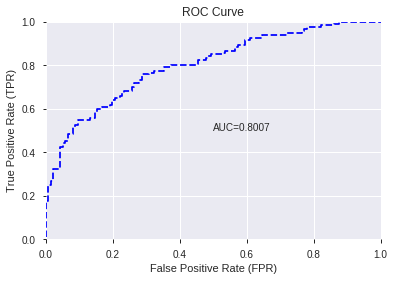

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


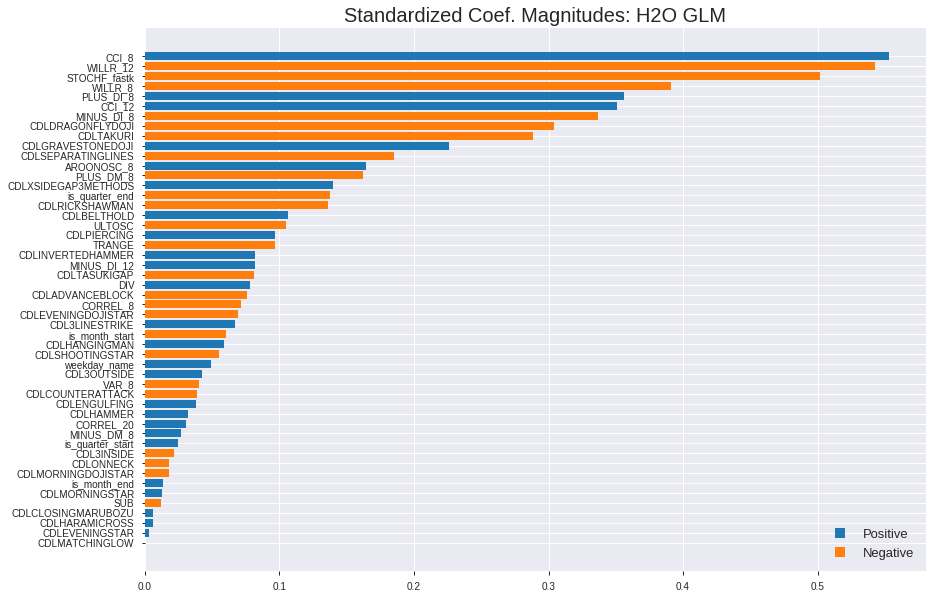

'log_likelihood'
--2019-08-22 12:57:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_125728_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_125728_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CCI_8',
 'WILLR_12',
 'STOCHF_fastk',
 'WILLR_8',
 'PLUS_DI_8',
 'CCI_12',
 'MINUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLSEPARATINGLINES',
 'AROONOSC_8',
 'PLUS_DM_8',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'ULTOSC',
 'CDLPIERCING',
 'TRANGE',
 'CDLINVERTEDHAMMER',
 'MINUS_DI_12',
 'CDLTASUKIGAP',
 'DIV',
 'CDLADVANCEBLOCK',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'CDL3OUTSIDE',
 'VAR_8',
 'CDLCOUNTERATTACK',
 'CDLENGULFING',
 'CDLHAMMER',
 'CORREL_20',
 'MINUS_DM_8',
 'is_quarter_start',
 'CDL3INSIDE',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'is_month_end',
 'CDLMORNINGSTAR',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW']

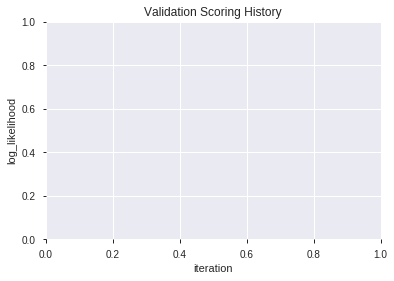

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_125745_model_4  0.824203  0.529929              0.229657  0.419887  0.176305
1  XGBoost_grid_1_AutoML_20190822_125745_model_6  0.818873  0.526453              0.261520  0.420321  0.176670
2  XGBoost_grid_1_AutoML_20190822_125745_model_2  0.815074  0.531935              0.248529  0.422663  0.178644
3  XGBoost_grid_1_AutoML_20190822_125745_model_7  0.814277  0.529128              0.273529  0.421726  0.177853
4               XGBoost_2_AutoML_20190822_125745  0.810968  0.538933              0.265686  0.424806  0.180460
5  XGBoost_grid_1_AutoML_20190822_125745_model_1  0.809988  0.535084              0.276225  0.424973  0.180602
6               XGBoost_1_AutoML_20190822_125745  0.805208  0.538637              0.278186  0.426145  0.181600
7               XGBoost_3_AutoML_20190822_125745  0.804412  0.537167              0.266667  0.426046  0.181515
8  XGBoost_grid_1_AutoML_20190822_125745_model_3  0.803002  0.542489              0.281127  0.427893  0.183093
9  XGBoost_grid_1_AutoML_20190822_125745_model_5  0.802022  0.551974              0.261029  0.430571  0.185391

variable  relative_importance  scaled_importance  percentage
0    CDLDRAGONFLYDOJI           748.846802           1.000000    0.134534
1        STOCHF_fastk           741.321350           0.989951    0.133182
2               CCI_8           599.650330           0.800765    0.107730
3   CDLGRAVESTONEDOJI           519.951233           0.694336    0.093412
4             WILLR_8           473.652527           0.632509    0.085094
5            WILLR_12           344.300262           0.459774    0.061855
6           PLUS_DI_8           280.171753           0.374138    0.050334
7           CDLTAKURI           262.534637           0.350585    0.047166
8              ULTOSC           233.034286           0.311191    0.041866
9          MINUS_DI_8           202.856873           0.270892    0.036444
10         MINUS_DM_8           152.388184           0.203497    0.027377
11             CCI_12           143.590149           0.191748    0.025797
12           CORREL_8           143.523422           0.191659    0.025785
13             TRANGE           119.522446           0.159609    0.021473
14     CDLRICKSHAWMAN           112.333557           0.150009    0.020181
15              VAR_8            94.691185           0.126449    0.017012
16                DIV            77.461349           0.103441    0.013916
17         AROONOSC_8            75.541222           0.100877    0.013571
18                SUB            73.599899           0.098284    0.013223
19          PLUS_DM_8            58.370068           0.077947    0.010486
20       weekday_name            45.939526           0.061347    0.008253
21          CORREL_20            35.670879           0.047634    0.006408
22        MINUS_DI_12            27.271931           0.036419    0.004900

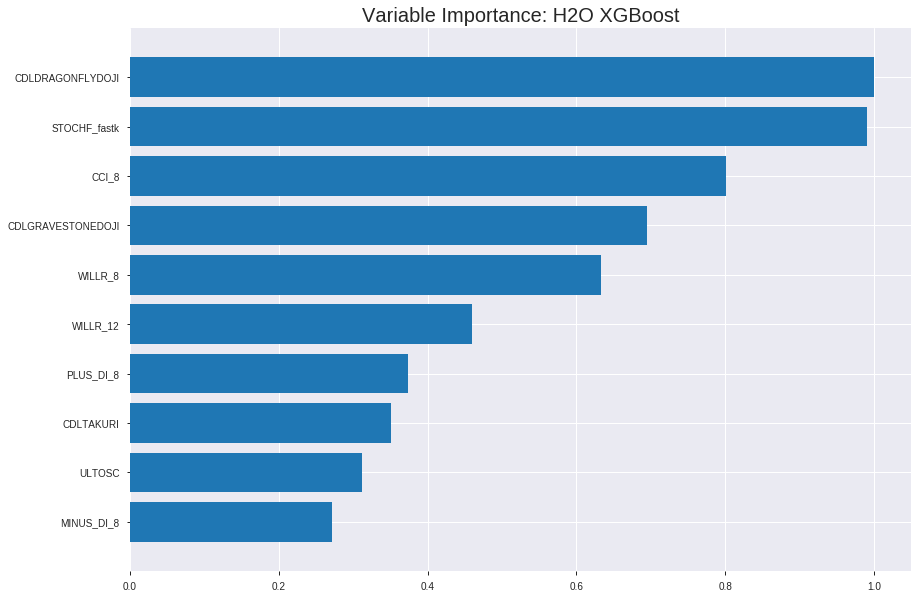

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_125745_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16735244158925958
RMSE: 0.40908732758331634
LogLoss: 0.5085776045887112
Mean Per-Class Error: 0.23967422007406936
AUC: 0.8419609566254472
pr_auc: 0.8407385683117365
Gini: 0.6839219132508945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40815505385398865: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      566  324   0.364    (324.0/890.0)
1      117  778   0.1307   (117.0/895.0)
Total  683  1102  0.2471   (441.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408155     0.779169  249
max f2                       0.233906     0.864294  334
max f0point5                 0.575358     0.77446   168
max accuracy                 0.521997     0.760224  194
max precision                0.923318     1         0
max recall                   0.106049     1         390
max specificity              0.923318     1         0
max absolute_mcc             0.521997     0.521972  194
max min_per_class_accuracy   0.490574     0.753933  208
max mean_per_class_accuracy  0.521997     0.760326  194

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 49.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.904238           1.99441    1.99441            1                0.911804  1                           0.911804            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.890439           1.99441    1.99441            1                0.895932  1                           0.903868            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.88065            1.99441    1.99441            1                0.885313  1                           0.897683            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.867167           1.99441    1.99441            1                0.874283  1                           0.891833            0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.854328           1.99441    1.99441            1                0.860464  1                           0.885559            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.81308            1.83755    1.91642            0.921348         0.831388  0.960894                    0.858625            0.0916201       0.192179                   83.7549   91.642
    7        0.15014                     0.77516            1.70309    1.84558            0.853933         0.796229  0.925373                    0.837904            0.0849162       0.277095                   70.3095   84.5577
    8        0.2                         0.726131           1.63587    1.7933             0.820225         0.751186  0.89916                     0.816285            0.0815642       0.358659                   63.5867   79.3296
    9        0.30028                     0.653816           1.52645    1.70418            0.765363         0.688253  0.854478                    0.773528            0.153073        0.511732                   52.645    70.4182
    10       0.4                         0.574257           1.37816    1.62291            0.691011         0.61574   0.813725                    0.734192            0.13743         0.649162                   37.8162   62.2905
    11       0.50028                     0.490155           1.0362     1.5053             0.519553         0.531834  0.754759                    0.693629            0.103911        0.753073                   3.62036   50.5302
    12       0.6                         0.42038            0.963593   1.41527            0.483146         0.457959  0.709617                    0.654461            0.0960894       0.849162                   -3.6407   41.527
    13       0.69972                     0.348342           0.728297   1.31737            0.365169         0.384644  0.660528                    0.616008            0.0726257       0.921788                   -27.1703  31.7367
    14       0.8                         0.280834           0.423395   1.20531            0.212291         0.315587  0.604342                    0.57835             0.0424581       0.964246                   -57.6605  20.5307
    15       0.89972                     0.185363           0.26891    1.10152            0.134831         0.238638  0.552304                    0.540699            0.0268156       0.991061                   -73.109   10.1522
    16       1                           0.0768322          0.0891358  1                  0.0446927        0.133748  0.501401                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1823397175921291
RMSE: 0.42701254968926744
LogLoss: 0.5423348083000169
Mean Per-Class Error: 0.27647058823529413
AUC: 0.8016762783544791
pr_auc: 0.7958984682315066
Gini: 0.6033525567089582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34262022376060486: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  143  0.5608   (143.0/255.0)
1      16   239  0.0627   (16.0/255.0)
Total  128  382  0.3118   (159.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34262      0.750392  290
max f2                       0.285248     0.856742  310
max f0point5                 0.628468     0.748691  136
max accuracy                 0.590016     0.723529  155
max precision                0.914983     1         0
max recall                   0.104247     1         392
max specificity              0.914983     1         0
max absolute_mcc             0.628468     0.458439  136
max min_per_class_accuracy   0.535731     0.705882  188
max mean_per_class_accuracy  0.590016     0.723529  155

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.907338           2         2                  1                0.911175  1                           0.911175            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.901179           1.6       1.81818            0.8              0.903419  0.909091                    0.907649            0.0156863       0.0392157                  60        81.8182
    3        0.0313725                   0.889099           1.6       1.75               0.8              0.892639  0.875                       0.902959            0.0156863       0.054902                   60        75
    4        0.0411765                   0.880133           2         1.80952            1                0.884426  0.904762                    0.898546            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.862325           2         1.84615            1                0.86754   0.923077                    0.892583            0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.831843           1.92      1.88235            0.96             0.846854  0.941176                    0.870167            0.0941176       0.188235                   92        88.2353
    7        0.15098                     0.79246            1.69231   1.81818            0.846154         0.812466  0.909091                    0.850683            0.0862745       0.27451                    69.2308   81.8182
    8        0.2                         0.74249            1.68      1.78431            0.84             0.768654  0.892157                    0.830578            0.0823529       0.356863                   68        78.4314
    9        0.3                         0.653994           1.4902    1.68627            0.745098         0.69405   0.843137                    0.785069            0.14902         0.505882                   49.0196   68.6275
    10       0.4                         0.587234           1.17647   1.55882            0.588235         0.620679  0.779412                    0.743971            0.117647        0.623529                   17.6471   55.8824
    11       0.5                         0.529237           0.823529  1.41176            0.411765         0.558939  0.705882                    0.706965            0.0823529       0.705882                   -17.6471  41.1765
    12       0.6                         0.455818           0.862745  1.32026            0.431373         0.49195   0.660131                    0.671129            0.0862745       0.792157                   -13.7255  32.0261
    13       0.7                         0.383896           0.901961  1.2605             0.45098          0.418405  0.630252                    0.635026            0.0901961       0.882353                   -9.80392  26.0504
    14       0.8                         0.275562           0.745098  1.19608            0.372549         0.333537  0.598039                    0.597339            0.0745098       0.956863                   -25.4902  19.6078
    15       0.9                         0.17228            0.196078  1.08497            0.0980392        0.221447  0.542484                    0.555574            0.0196078       0.976471                   -80.3922  8.49673
    16       1                           0.0808807          0.235294  1                  0.117647         0.128448  0.5                         0.512861            0.0235


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:57:57  5.435 sec   0                  0.5              0.693147            0.5             0                  1                0.498599                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-22 12:57:57  5.549 sec   5                  0.479154         0.652062            0.78979         0.598082           1.7095           0.336695                         0.476642           0.647174              0.784537          0.530959             1.79487            0.3
    2019-08-22 12:57:57  5.610 sec   10                 0.464148         0.622584            0.793675        0.600763           1.7095           0.295798                         0.460712           0.615759              0.783991          0.529364             1.79487            0.321569
    2019-08-22 12:57:57  5.670 sec   15                 0.45298          0.600315            0.799731        0.742574           1.86976          0.305882                         0.450592           0.595094              0.787597          0.718223             1.9                0.3
    2019-08-22 12:57:57  5.730 sec   20                 0.444986         0.583915            0.804           0.771732           1.99441          0.296919                         0.44262            0.578299              0.79278           0.752913             1.81818            0.298039
    2019-08-22 12:57:57  5.802 sec   25                 0.438372         0.570403            0.809592        0.802195           1.99441          0.291317                         0.438955           0.569973              0.791211          0.783741             1.71429            0.305882
    2019-08-22 12:57:57  5.880 sec   30                 0.433199         0.55974             0.815071        0.810366           1.99441          0.280112                         0.436488           0.564364              0.790565          0.787781             1.66667            0.319608
    2019-08-22 12:57:57  5.958 sec   35                 0.429188         0.551305            0.818404        0.815334           1.99441          0.27507                          0.434562           0.559961              0.792249          0.789052             1.66667            0.319608
    2019-08-22 12:57:57  6.036 sec   40                 0.425747         0.544112            0.821777        0.819181           1.99441          0.278992                         0.43374            0.557781              0.792311          0.787394             1.66667            0.309804
    2019-08-22 12:57:57  6.117 sec   45                 0.422463         0.53714             0.825612        0.819496           1.99441          0.268908                         0.431584           0.552982              0.795909          0.791415             1.66667            0.313725
    2019-08-22 12:57:57  6.199 sec   50                 0.419625         0.531166            0.829088        0.824277           1.99441          0.259384                         0.43074            0.550888              0.796578          0.790895             1.66667            0.317647
    2019-08-22 12:57:57  6.288 sec   55                 0.417098         0.525737            0.831764        0.82885            1.99441          0.257703                         0.429976           0.549051              0.796786          0.795183        

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLDRAGONFLYDOJI   748.8468017578125      1.0                  0.1345340789982983
STOCHF_fastk       741.3213500976562      0.9899506125385175   0.1331820939116707
CCI_8              599.6503295898438      0.8007650272155119   0.10773018543048618
CDLGRAVESTONEDOJI  519.9512329101562      0.6943359198298555   0.09341184348974592
WILLR_8            473.65252685546875     0.6325092472100249   0.0850940490313077
---                ---                    ---                  ---
SUB                73.59989929199219      0.09828432079729363  0.013222590578437195
PLUS_DM_8          58.37006759643555      0.07794660731596907  0.01048647502629592
weekday_name       45.93952560424805      0.06134702785190706  0.00825326589133927
CORREL_20          35.67087936401367      0.04763441505028973  0.006408452157413409
MINUS_DI_12        27.271930694580078     0.0364185713694217   0.004899538957618944


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.77734375)

('F1', 0.7611336032388665)

('auc', 0.824203431372549)

('logloss', 0.5299294421291354)

('mean_per_class_error', 0.22426470588235292)

('rmse', 0.41988683324063386)

('mse', 0.17630495272884789)

xgboost prediction progress: |████████████████████████████████████████████| 100%


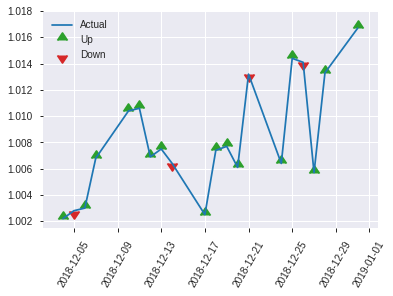


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17630495272884789
RMSE: 0.41988683324063386
LogLoss: 0.5299294421291354
Mean Per-Class Error: 0.22426470588235292
AUC: 0.824203431372549
pr_auc: 0.8095865849513793
Gini: 0.6484068627450981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5092520713806152: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      103  33   0.2426   (33.0/136.0)
1      26   94   0.2167   (26.0/120.0)
Total  129  127  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509252     0.761134  126
max f2                       0.326258     0.838323  187
max f0point5                 0.53464      0.765306  116
max accuracy                 0.53464      0.777344  116
max precision                0.908495     1         0
max recall                   0.138358     1         241
max specificity              0.908495     1         0
max absolute_mcc             0.53464      0.552436  116
max min_per_class_accuracy   0.515563     0.764706  123
max mean_per_class_accuracy  0.53464      0.775735  116

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.892452           2.13333   2.13333            1                0.903916  1                           0.903916            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.881492           2.13333   2.13333            1                0.886452  1                           0.895184            0.025           0.05                       113.333   113.333
    3        0.03125                     0.873522           2.13333   2.13333            1                0.876343  1                           0.890474            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.867603           2.13333   2.13333            1                0.869918  1                           0.884868            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.863622           2.13333   2.13333            1                0.865857  1                           0.881943            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.826426           1.80513   1.96923            0.846154         0.843753  0.923077                    0.862848            0.0916667       0.2                        80.5128   96.9231
    7        0.152344                    0.792348           1.96923   1.96923            0.923077         0.810117  0.923077                    0.845271            0.1             0.3                        96.9231   96.9231
    8        0.203125                    0.740757           1.64103   1.88718            0.769231         0.768886  0.884615                    0.826175            0.0833333       0.383333                   64.1026   88.7179
    9        0.300781                    0.656671           1.45067   1.74545            0.68             0.691114  0.818182                    0.782324            0.141667        0.525                      45.0667   74.5455
    10       0.402344                    0.559973           1.39487   1.65696            0.653846         0.604038  0.776699                    0.73732             0.141667        0.666667                   39.4872   65.6958
    11       0.5                         0.507337           1.19467   1.56667            0.56             0.538429  0.734375                    0.698474            0.116667        0.783333                   19.4667   56.6667
    12       0.601562                    0.444078           0.492308  1.38528            0.230769         0.480046  0.649351                    0.661596            0.05            0.833333                   -50.7692  38.5281
    13       0.699219                    0.355486           0.597333  1.27523            0.28             0.411201  0.597765                    0.626625            0.0583333       0.891667                   -40.2667  27.5233
    14       0.800781                    0.26312            0.574359  1.18634            0.269231         0.310241  0.556098                    0.586498            0.0583333       0.95                       -42.5641  18.6341
    15       0.898438                    0.168798           0.256     1.08522            0.12             0.220862  0.508696                    0.546755            0.025           0.975                      -74.4     8.52174
    16       1                           0.102029           0.246154  1                  0.115385         0.135574  0.46875                     0.504995         

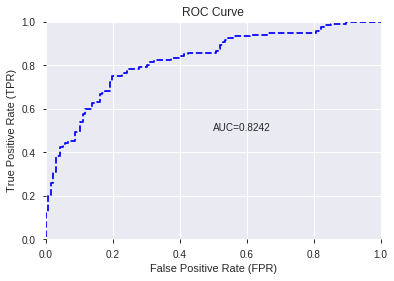

This function is available for GLM models only


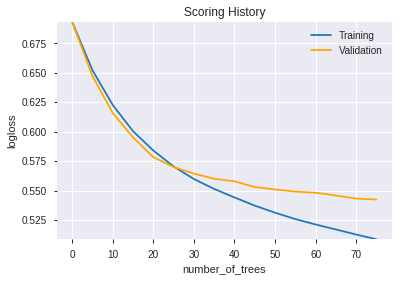

--2019-08-22 12:58:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_125745_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_125745_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'WILLR_12',
 'PLUS_DI_8',
 'CDLTAKURI',
 'ULTOSC',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'CCI_12',
 'CORREL_8',
 'TRANGE',
 'CDLRICKSHAWMAN',
 'VAR_8',
 'DIV',
 'AROONOSC_8',
 'SUB',
 'PLUS_DM_8',
 'weekday_name',
 'CORREL_20',
 'MINUS_DI_12']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [887 919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


19

['aroondown_8',
 'AROONOSC_8',
 'CCI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'WILLR_8',
 'MINUS_DI_12',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125823_model_6  0.810539  0.555191              0.258824  0.428544  0.183650
1  DeepLearning_grid_1_AutoML_20190822_125823_model_5  0.802696  0.557026              0.273529  0.431144  0.185886
2  DeepLearning_grid_1_AutoML_20190822_125823_model_7  0.800306  0.551871              0.242402  0.428762  0.183836
3  DeepLearning_grid_1_AutoML_20190822_125823_model_4  0.799020  0.562201              0.283578  0.431960  0.186589
4               DeepLearning_1_AutoML_20190822_125823  0.797181  0.538369              0.294118  0.427977  0.183164
5  DeepLearning_grid_1_AutoML_20190822_125823_model_2  0.793934  0.539364              0.269118  0.429095  0.184122
6  DeepLearning_grid_1_AutoML_20190822_125823_model_3  0.791850  0.552669              0.284314  0.431643  0.186316
7  DeepLearning_grid_1_AutoML_20190822_125823_model_1  0.752574  0.646338              0.324755  0.456659  0.208537

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             1.000000           1.000000    0.083747
1                CCI_8             0.974885           0.974885    0.081644
2    CDLGRAVESTONEDOJI             0.962611           0.962611    0.080616
3               ULTOSC             0.881666           0.881666    0.073837
4     CDLDRAGONFLYDOJI             0.827340           0.827340    0.069287
5              WILLR_8             0.800992           0.800992    0.067081
6            CDLTAKURI             0.798728           0.798728    0.066891
7            PLUS_DI_8             0.684100           0.684100    0.057291
8          aroondown_8             0.594876           0.594876    0.049819
9           MINUS_DI_8             0.574832           0.574832    0.048141
10          MINUS_DM_8             0.569281           0.569281    0.047676
11   CDLINVERTEDHAMMER             0.526312           0.526312    0.044077
12         CDLBELTHOLD             0.479081           0.479081    0.040122
13  CDLCLOSINGMARUBOZU             0.425318           0.425318    0.035619
14         MINUS_DI_12             0.422881           0.422881    0.035415
15     CDLSHOOTINGSTAR             0.390809           0.390809    0.032729
16          AROONOSC_8             0.375924           0.375924    0.031483
17       CDLHANGINGMAN             0.359745           0.359745    0.030128
18           CDLHAMMER             0.291322           0.291322    0.024397

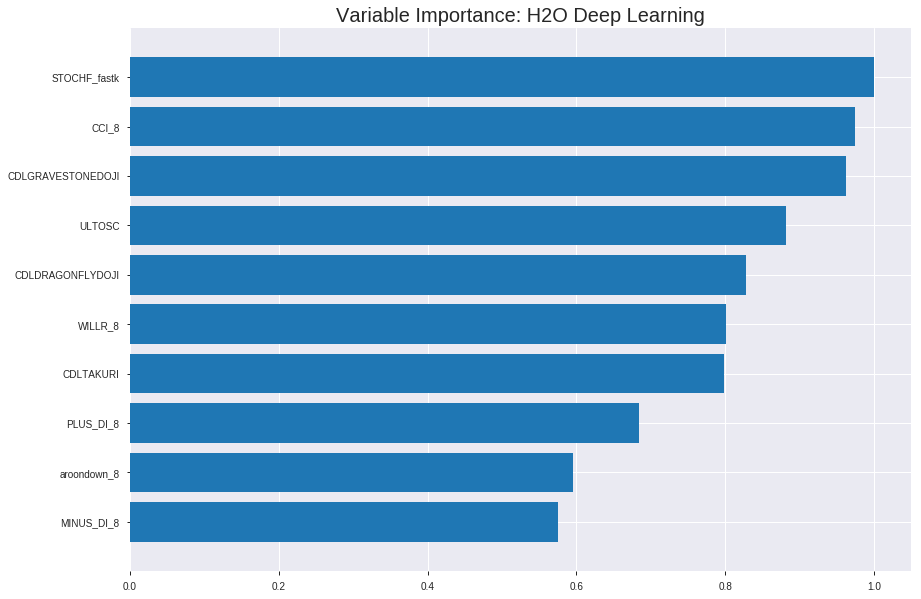

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125823_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1897539952036552
RMSE: 0.4356076160992312
LogLoss: 0.5585926337841249
Mean Per-Class Error: 0.2920563680873768
AUC: 0.7842320005021656
pr_auc: 0.7723974660868289
Gini: 0.5684640010043311
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4583532744234475: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      470  420   0.4719   (420.0/890.0)
1      111  784   0.124    (111.0/895.0)
Total  581  1204  0.2975   (531.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458353     0.747022  241
max f2                       0.320042     0.861012  308
max f0point5                 0.533827     0.705978  189
max accuracy                 0.516735     0.708123  206
max precision                0.989994     1         0
max recall                   0.0221768    1         393
max specificity              0.989994     1         0
max absolute_mcc             0.46101      0.431718  239
max min_per_class_accuracy   0.530533     0.696629  193
max mean_per_class_accuracy  0.516735     0.707944  206

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 51.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.972386           1.88361   1.88361            0.944444         0.976686   0.944444                    0.976686            0.0189944       0.0189944                  88.3613   88.3613
    2        0.0201681                   0.963725           1.88361   1.88361            0.944444         0.967537   0.944444                    0.972111            0.0189944       0.0379888                  88.3613   88.3613
    3        0.0302521                   0.959624           1.77281   1.84668            0.888889         0.961566   0.925926                    0.968596            0.0178771       0.0558659                  77.2812   84.6679
    4        0.0403361                   0.954933           1.66201   1.80051            0.833333         0.957246   0.902778                    0.965759            0.0167598       0.0726257                  66.2011   80.0512
    5        0.0504202                   0.949733           1.88361   1.81713            0.944444         0.952435   0.911111                    0.963094            0.0189944       0.0916201                  88.3613   81.7132
    6        0.10028                     0.889024           1.7255    1.77157            0.865169         0.923667   0.888268                    0.943491            0.0860335       0.177654                   72.5504   77.1574
    7        0.15014                     0.788775           1.74791   1.76372            0.876404         0.83553    0.884328                    0.907638            0.0871508       0.264804                   74.7913   76.3716
    8        0.2                         0.680654           1.41178   1.67598            0.707865         0.732129   0.840336                    0.863884            0.0703911       0.335196                   41.1776   67.5978
    9        0.30028                     0.575646           1.25904   1.53674            0.631285         0.612592   0.770522                    0.779964            0.126257        0.461453                   25.9043   53.674
    10       0.4                         0.548083           1.2325    1.46089            0.617978         0.561355   0.732493                    0.725464            0.122905        0.584358                   23.2503   46.0894
    11       0.50028                     0.530344           1.1142    1.3914             0.558659         0.538649   0.697648                    0.688018            0.111732        0.696089                   11.4197   39.1399
    12       0.6                         0.504564           1.05323   1.3352             0.52809          0.519121   0.669468                    0.659947            0.105028        0.801117                   5.32296   33.5196
    13       0.69972                     0.4393             0.896366  1.27266            0.449438         0.47396    0.63811                     0.633441            0.0893855       0.890503                   -10.3634  27.2656
    14       0.8                         0.352603           0.668518  1.19693            0.335196         0.397207   0.60014                     0.603829            0.0670391       0.957542                   -33.1482  19.6927
    15       0.89972                     0.0695237          0.302523  1.0978             0.151685         0.25417    0.550436                    0.565075            0.0301676       0.987709                   -69.7477  9.77967
    16       1                           0.00568633         0.122562  1                  0.0614525        0.0344364  0.501401                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18667023473675712
RMSE: 0.4320535091128842
LogLoss: 0.5521356435106125
Mean Per-Class Error: 0.27647058823529413
AUC: 0.7923567858515956
pr_auc: 0.7789581892860056
Gini: 0.5847135717031913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4899430775688711: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  110  0.4314   (110.0/255.0)
1      35   220  0.1373   (35.0/255.0)
Total  180  330  0.2843   (145.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489943     0.752137  256
max f2                       0.345012     0.860367  313
max f0point5                 0.52241      0.713262  222
max accuracy                 0.512138     0.723529  233
max precision                0.978174     1         0
max recall                   0.0285371    1         386
max specificity              0.978174     1         0
max absolute_mcc             0.511277     0.454852  234
max min_per_class_accuracy   0.54072      0.701961  204
max mean_per_class_accuracy  0.512138     0.723529  233

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.971891           2          2                  1                0.974946   1                           0.974946            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.966718           1.6        1.81818            0.8              0.968999   0.909091                    0.972243            0.0156863       0.0392157                  60        81.8182
    3        0.0313725                   0.960525           2          1.875              1                0.96259    0.9375                      0.969227            0.0196078       0.0588235                  100       87.5
    4        0.0411765                   0.957547           2          1.90476            1                0.959115   0.952381                    0.966819            0.0196078       0.0784314                  100       90.4762
    5        0.0509804                   0.955314           2          1.92308            1                0.956598   0.961538                    0.964853            0.0196078       0.0980392                  100       92.3077
    6        0.1                         0.92104            1.68       1.80392            0.84             0.940852   0.901961                    0.953088            0.0823529       0.180392                   68        80.3922
    7        0.15098                     0.897167           1.69231    1.76623            0.846154         0.912351   0.883117                    0.939332            0.0862745       0.266667                   69.2308   76.6234
    8        0.2                         0.789288           1.6        1.72549            0.8              0.830292   0.862745                    0.912607            0.0784314       0.345098                   60        72.549
    9        0.3                         0.634843           1.17647    1.54248            0.588235         0.705828   0.771242                    0.84368             0.117647        0.462745                   17.6471   54.2484
    10       0.4                         0.566574           1.29412    1.48039            0.647059         0.591499   0.740196                    0.780635            0.129412        0.592157                   29.4118   48.0392
    11       0.5                         0.540566           1.09804    1.40392            0.54902          0.55207    0.701961                    0.734922            0.109804        0.701961                   9.80392   40.3922
    12       0.6                         0.50833            1.17647    1.36601            0.588235         0.523716   0.683007                    0.699721            0.117647        0.819608                   17.6471   36.6013
    13       0.7                         0.454215           0.705882   1.27171            0.352941         0.485436   0.635854                    0.669109            0.0705882       0.890196                   -29.4118  27.1709
    14       0.8                         0.316069           0.705882   1.20098            0.352941         0.388359   0.60049                     0.634015            0.0705882       0.960784                   -29.4118  20.098
    15       0.9                         0.040568           0.313725   1.1024             0.156863         0.139978   0.551198                    0.579122            0.0313725       0.992157                   -68.6275  10.2397
    16       1                           0.0166472          0.0784314  1                  0.0392157        0.0291051  0.5               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:02:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:02:07  2 min  3.303 sec  959 obs/sec       1         1             1785       0.516107         0.859889            -0.0654758     0.695617        0.670815           1.77281          0.369748                         0.467993           0.692974              0.123932         0.761484          0.734359             2                  0.301961
    2019-08-22 13:02:13  2 min  8.648 sec  2133 obs/sec      8         8             14280      0.446811         0.581536            0.201432       0.753705        0.751559           1.99441          0.373109                         0.435636           0.558334              0.240885         0.783299          0.766106             1.66667            0.296078
    2019-08-22 13:02:18  2 min 13.786 sec  2833 obs/sec      18        18            32130      0.443006         0.571202            0.214977       0.763405        0.757981           1.99441          0.329412                         0.436399           0.561982              0.238225         0.779908          0.753285             2                  0.290196
    2019-08-22 13:02:23  2 min 19.114 sec  3203 obs/sec      29        29            51765      0.438482         0.564877            0.230927       0.775551        0.766123           1.99441          0.317647                         0.43333            0.560536              0.248899         0.787474          0.764165             1.66667            0.303922
    2019-08-22 13:02:28  2 min 24.175 sec  3444 obs/sec      40        40            71400      0.439183         0.56463             0.228466       0.776651        0.76865            1.99441          0.312605                         0.434032           0.553676              0.246466         0.787628          0.769638             1.66667            0.301961
    2019-08-22 13:02:33  2 min 30.135 sec  3627 obs/sec      52        52            92820      0.438986         0.56375             0.229158       0.779856        0.771645           1.99441          0.301401                         0.433307           0.552143              0.248982         0.791434          0.776162             1.66667            0.268627
    2019-08-22 13:02:45  2 min 40.708 sec  3904 obs/sec      78        78            139230     0.435608         0.558593            0.240978       0.784232        0.772397           1.88361          0.297479                         0.432054           0.552136              0.253319         0.792357          0.778958             2                  0.284314

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
STOCHF_fastk        1                      1                    0.0837472
CCI_8               0.974885               0.974885             0.0816439
CDLGRAVESTONEDOJI   0.962611               0.962611             0.0806159
ULTOSC              0.881666               0.881666             0.0738371
CDLDRAGONFLYDOJI    0.82734                0.82734              0.0692874
WILLR_8             0.800992               0.800992             0.0670808
CDLTAKURI           0.798728               0.798728             0.0668912
PLUS_DI_8           0.6841                 0.6841               0.0572914
aroondown_8         0.594876               0.594876             0.0498192
MINUS_DI_8          0.574832               0.574832             0.0481405
MINUS_DM_8          0.569281               0.569281             0.0476757
CDLINVERTEDHAMMER   0.526312               0.526312             0.0440771
CDLBELTHOLD         0.479081               0.479081             0.0401216
CDLCLOSINGMARUBOZU  0.425318               0.425318             0.0356192
MINUS_DI_12         0.422881               0.422881             0.0354151
CDLSHOOTINGSTAR     0.390809               0.390809             0.0327291
AROONOSC_8          0.375924               0.375924             0.0314825
CDLHANGINGMAN       0.359745               0.359745             0.0301277
CDLHAMMER           0.291322               0.291322             0.0243974

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75)

('F1', 0.7499999999999999)

('auc', 0.8105392156862745)

('logloss', 0.5551913018336921)

('mean_per_class_error', 0.25098039215686274)

('rmse', 0.42854371110313355)

('mse', 0.183649712326046)

deeplearning prediction progress: |███████████████████████████████████████| 100%


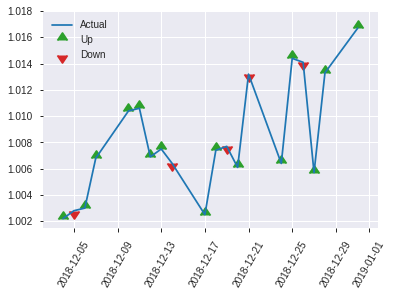


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.183649712326046
RMSE: 0.42854371110313355
LogLoss: 0.5551913018336921
Mean Per-Class Error: 0.25098039215686274
AUC: 0.8105392156862745
pr_auc: 0.8048341872270527
Gini: 0.621078431372549
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4853172395189112: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      86   50   0.3676   (50.0/136.0)
1      18   102  0.15     (18.0/120.0)
Total  104  152  0.2656   (68.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485317     0.75      151
max f2                       0.290855     0.828488  207
max f0point5                 0.613551     0.757212  73
max accuracy                 0.548953     0.75      109
max precision                0.982803     1         0
max recall                   0.0214612    1         251
max specificity              0.982803     1         0
max absolute_mcc             0.536274     0.498039  119
max min_per_class_accuracy   0.536274     0.733333  119
max mean_per_class_accuracy  0.536274     0.74902   119

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.972651           2.13333   2.13333            1                0.979003   1                           0.979003            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.966481           2.13333   2.13333            1                0.969175   1                           0.974089            0.025           0.05                       113.333   113.333
    3        0.03125                     0.96267            2.13333   2.13333            1                0.964465   1                           0.971683            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.960372           2.13333   2.13333            1                0.960924   1                           0.968749            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.956048           2.13333   2.13333            1                0.958467   1                           0.967167            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.927225           1.96923   2.05128            0.923077         0.941609   0.961538                    0.954388            0.1             0.208333                   96.9231   105.128
    7        0.152344                    0.826222           1.96923   2.02393            0.923077         0.89102    0.948718                    0.933265            0.1             0.308333                   96.9231   102.393
    8        0.203125                    0.755666           1.47692   1.88718            0.692308         0.788638   0.884615                    0.897108            0.075           0.383333                   47.6923   88.7179
    9        0.300781                    0.609976           1.536     1.77316            0.72             0.671624   0.831169                    0.823899            0.15            0.533333                   53.6      77.316
    10       0.402344                    0.558522           1.06667   1.59482            0.5              0.576051   0.747573                    0.761336            0.108333        0.641667                   6.66667   59.4822
    11       0.5                         0.527289           1.10933   1.5                0.52             0.540993   0.703125                    0.7183              0.108333        0.75                       10.9333   50
    12       0.601562                    0.481142           0.984615  1.41299            0.461538         0.503774   0.662338                    0.682081            0.1             0.85                       -1.53846  41.2987
    13       0.699219                    0.402052           0.341333  1.26331            0.16             0.440138   0.592179                    0.64829             0.0333333       0.883333                   -65.8667  26.3315
    14       0.800781                    0.308063           0.492308  1.16553            0.230769         0.357508   0.546341                    0.611411            0.05            0.933333                   -50.7692  16.5528
    15       0.898438                    0.0421769          0.256     1.06667            0.12             0.150206   0.5                         0.56128             0.025           0.958333                   -74.4     6.66667
    16       1                           0.0203207          0.410256  1                  0.192308         0.0300562  0.46875                     0.507

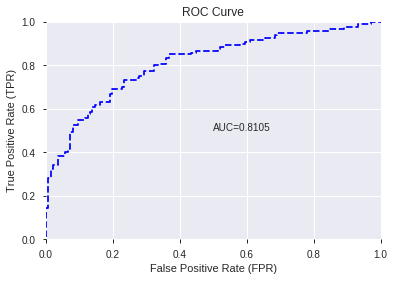

This function is available for GLM models only


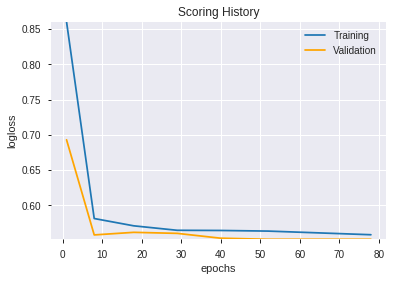

--2019-08-22 13:04:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125823_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125823_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'CCI_8',
 'CDLGRAVESTONEDOJI',
 'ULTOSC',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLTAKURI',
 'PLUS_DI_8',
 'aroondown_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'CDLINVERTEDHAMMER',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_12',
 'CDLSHOOTINGSTAR',
 'AROONOSC_8',
 'CDLHANGINGMAN',
 'CDLHAMMER']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190822_130441_model_1  0.817647  0.518984              0.264706  0.41876  0.17536

variable  relative_importance  scaled_importance  percentage
0           MINUS_DI_8             1.146531           1.000000    0.181373
1                CCI_8             0.997191           0.869746    0.157748
2          MINUS_DI_12             0.978902           0.853794    0.154855
3              WILLR_8             0.916912           0.799727    0.145049
4         STOCHF_fastk             0.617755           0.538803    0.097724
5     CDLDRAGONFLYDOJI             0.450001           0.392489    0.071187
6            PLUS_DI_8             0.278382           0.242804    0.044038
7    CDLGRAVESTONEDOJI             0.251475           0.219336    0.039782
8            CDLTAKURI             0.132879           0.115896    0.021020
9           MINUS_DM_8             0.092541           0.080714    0.014639
10   CDLINVERTEDHAMMER             0.079861           0.069654    0.012633
11         CDLBELTHOLD             0.075681           0.066009    0.011972
12     CDLSHOOTINGSTAR             0.053966           0.047069    0.008537
13         aroondown_8             0.051854           0.045226    0.008203
14       CDLHANGINGMAN             0.044437           0.038758    0.007030
15          AROONOSC_8             0.043182           0.037664    0.006831
16              ULTOSC             0.042264           0.036862    0.006686
17           CDLHAMMER             0.037794           0.032964    0.005979
18  CDLCLOSINGMARUBOZU             0.029799           0.025990    0.004714

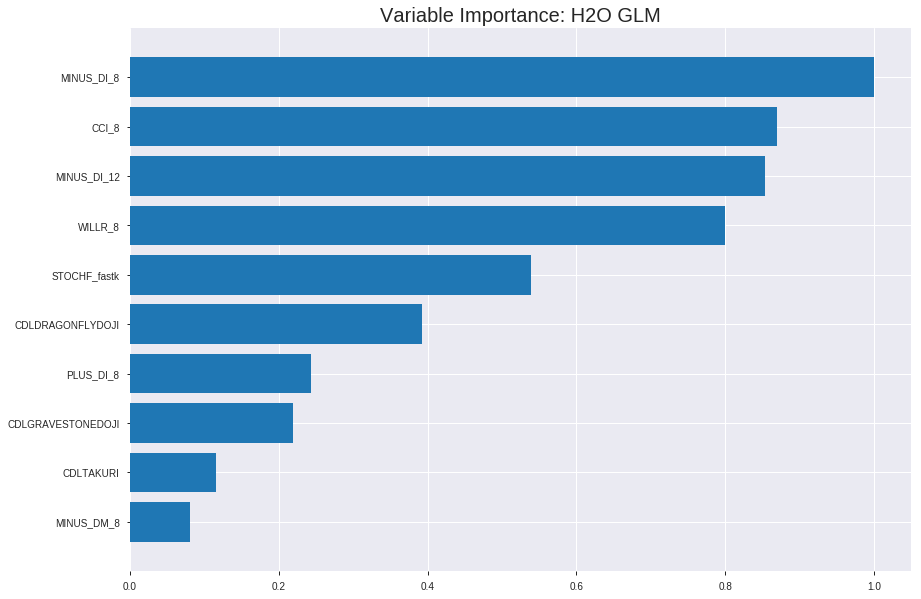

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_130441_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1902197650111159
RMSE: 0.4361419092578881
LogLoss: 0.5581402940742732
Null degrees of freedom: 1784
Residual degrees of freedom: 1765
Null deviance: 2474.52142897845
Residual deviance: 1992.5608498451556
AIC: 2032.5608498451556
AUC: 0.7789121837926056
pr_auc: 0.765697747665434
Gini: 0.5578243675852113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3625857864108444: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      381  509   0.5719   (509.0/890.0)
1      74   821   0.0827   (74.0/895.0)
Total  455  1330  0.3266   (583.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.362586     0.737978  275
max f2                       0.285784     0.858476  307
max f0point5                 0.585555     0.708575  160
max accuracy                 0.482813     0.70084   212
max precision                0.999341     1         0
max recall                   0.0268373    1         392
max specificity              0.999341     1         0
max absolute_mcc             0.461344     0.407505  223
max min_per_class_accuracy   0.510886     0.692737  199
max mean_per_class_accuracy  0.482813     0.700706  212

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.954099           1.88361   1.88361            0.944444         0.96865    0.944444                    0.96865             0.0189944       0.0189944                  88.3613   88.3613
    2        0.0201681                   0.939579           1.66201   1.77281            0.833333         0.947005   0.888889                    0.957827            0.0167598       0.0357542                  66.2011   77.2812
    3        0.0302521                   0.929298           1.88361   1.80975            0.944444         0.93541    0.907407                    0.950355            0.0189944       0.0547486                  88.3613   80.9745
    4        0.0403361                   0.91878            1.99441   1.85591            1                0.92245    0.930556                    0.943379            0.0201117       0.0748603                  99.4413   85.5912
    5        0.0504202                   0.899076           1.77281   1.83929            0.888889         0.909878   0.922222                    0.936679            0.0178771       0.0927374                  77.2812   83.9292
    6        0.10028                     0.83889            1.65828   1.74929            0.831461         0.870021   0.877095                    0.903536            0.0826816       0.175419                   65.8276   74.929
    7        0.15014                     0.762362           1.63587   1.71162            0.820225         0.797635   0.858209                    0.868367            0.0815642       0.256983                   63.5867   71.1623
    8        0.2                         0.710251           1.43418   1.64246            0.719101         0.735683   0.823529                    0.835289            0.0715084       0.328492                   43.4185   64.2458
    9        0.30028                     0.635145           1.39275   1.55907            0.698324         0.671786   0.781716                    0.780686            0.139665        0.468156                   39.2747   55.9066
    10       0.4                         0.574561           1.2325    1.47765            0.617978         0.602788   0.740896                    0.736336            0.122905        0.591061                   23.2503   47.7654
    11       0.50028                     0.508288           1.01392   1.3847             0.50838          0.539264   0.694289                    0.696834            0.101676        0.692737                   1.39197   38.4699
    12       0.6                         0.453891           1.01962   1.32402            0.511236         0.481642   0.663866                    0.661069            0.101676        0.794413                   1.96158   32.4022
    13       0.69972                     0.390523           0.840343  1.25509            0.421348         0.421563   0.629303                    0.626936            0.0837989       0.878212                   -15.9657  25.5091
    14       0.8                         0.302537           0.73537   1.18994            0.368715         0.352758   0.596639                    0.592568            0.073743        0.951955                   -26.463   18.9944
    15       0.89972                     0.105211           0.358546  1.0978             0.179775         0.216608   0.550436                    0.550898            0.0357542       0.987709                   -64.1454  9.77967
    16       1                           0.00969133         0.122562  1                  0.0614525        0.0573024  0.501401                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17963780370822843
RMSE: 0.4238370013439464
LogLoss: 0.5349879226096025
Null degrees of freedom: 509
Residual degrees of freedom: 490
Null deviance: 707.0141257874837
Residual deviance: 545.6876810617945
AIC: 585.6876810617945
AUC: 0.8055517108804305
pr_auc: 0.7921228517489193
Gini: 0.6111034217608611
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4371498298986628: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      145  110  0.4314   (110.0/255.0)
1      28   227  0.1098   (28.0/255.0)
Total  173  337  0.2706   (138.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43715      0.766892  257
max f2                       0.253812     0.863636  317
max f0point5                 0.63654      0.735768  134
max accuracy                 0.447042     0.731373  250
max precision                0.983163     1         0
max recall                   0.0397396    1         389
max specificity              0.983163     1         0
max absolute_mcc             0.43715      0.48456   257
max min_per_class_accuracy   0.536348     0.713725  199
max mean_per_class_accuracy  0.447042     0.731373  250

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.96708            2         2                  1                0.976839   1                           0.976839            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.951943           1.2       1.63636            0.6              0.960274   0.818182                    0.969309            0.0117647       0.0352941                  20        63.6364
    3        0.0313725                   0.945629           2         1.75               1                0.947281   0.875                       0.962426            0.0196078       0.054902                   100       75
    4        0.0411765                   0.937224           2         1.80952            1                0.941343   0.904762                    0.957406            0.0196078       0.0745098                  100       80.9524
    5        0.0509804                   0.926205           2         1.84615            1                0.929684   0.923077                    0.952075            0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.887678           1.92      1.88235            0.96             0.906638   0.941176                    0.929802            0.0941176       0.188235                   92        88.2353
    7        0.15098                     0.823911           1.76923   1.84416            0.884615         0.848644   0.922078                    0.902398            0.0901961       0.278431                   76.9231   84.4156
    8        0.2                         0.775703           1.28      1.70588            0.64             0.800508   0.852941                    0.877425            0.0627451       0.341176                   28        70.5882
    9        0.3                         0.663416           1.4902    1.63399            0.745098         0.713611   0.816993                    0.82282             0.14902         0.490196                   49.0196   63.3987
    10       0.4                         0.582969           1.05882   1.4902             0.529412         0.623158   0.745098                    0.772905            0.105882        0.596078                   5.88235   49.0196
    11       0.5                         0.534728           1.17647   1.42745            0.588235         0.561817   0.713725                    0.730687            0.117647        0.713725                   17.6471   42.7451
    12       0.6                         0.461821           1.09804   1.37255            0.54902          0.49898    0.686275                    0.69207             0.109804        0.823529                   9.80392   37.2549
    13       0.7                         0.403789           0.823529  1.29412            0.411765         0.438157   0.647059                    0.655796            0.0823529       0.905882                   -17.6471  29.4118
    14       0.8                         0.261541           0.588235  1.20588            0.294118         0.345639   0.602941                    0.617027            0.0588235       0.964706                   -41.1765  20.5882
    15       0.9                         0.0857457          0.156863  1.08932            0.0784314        0.168879   0.544662                    0.567232            0.0156863       0.980392                   -84.3137  8.93246
    16       1                           0.014257           0.196078  1                  0.0980392        0.0533593  0.5                         0.515845


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:04:42  0.000 sec   2            .15E2     20            1.3710184523008535  1.367494450496724
     2019-08-22 13:04:42  0.006 sec   4            .92E1     20            1.3626616353142935  1.3571843592952282
     2019-08-22 13:04:42  0.012 sec   6            .57E1     20            1.3504983838655313  1.3421654823404796
     2019-08-22 13:04:42  0.018 sec   8            .36E1     20            1.3336947360792684  1.3213943257450924
     2019-08-22 13:04:42  0.025 sec   10           .22E1     20            1.312016776496103   1.2946364623179831
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:04:42  0.174 sec   45           .26E-3    20            1.1163322634064066  1.0705088486154901
     2019-08-22 13:04:42  0.180 sec   46           .16E-3    20            1.116301702207849   1.0702758680617215
     2019-08-22 13:04:42  0.187 sec   47           .1E-3     20            1.1162885615064286  1.0701274311917854
     2019-08-22 13:04:42  0.193 sec   48           .62E-4    20            1.1162830362501215  1.0700322737545274
     2019-08-22 13:04:42  0.200 sec   49           .39E-4    20            1.1162805881485465  1.069975845219205


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.73828125)

('F1', 0.75)

('auc', 0.8176470588235294)

('logloss', 0.5189842868968567)

('mean_per_class_error', 0.2647058823529411)

('rmse', 0.4187598028721848)

('mse', 0.17535977250155105)

glm prediction progress: |████████████████████████████████████████████████| 100%


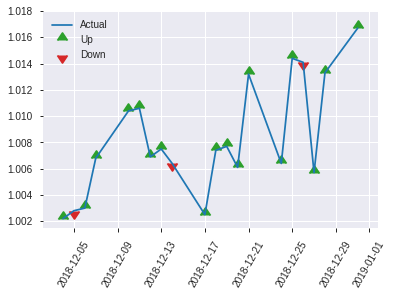


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17535977250155105
RMSE: 0.4187598028721848
LogLoss: 0.5189842868968567
Null degrees of freedom: 255
Residual degrees of freedom: 236
Null deviance: 354.9830011899469
Residual deviance: 265.71995489119064
AIC: 305.71995489119064
AUC: 0.8176470588235294
pr_auc: 0.8110525852070409
Gini: 0.6352941176470588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44033345569364746: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   55   0.4044   (55.0/136.0)
1      15   105  0.125    (15.0/120.0)
Total  96   160  0.2734   (70.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440333     0.75      159
max f2                       0.115875     0.83921   228
max f0point5                 0.676559     0.759804  71
max accuracy                 0.649133     0.738281  76
max precision                0.982976     1         0
max recall                   0.0581618    1         248
max specificity              0.982976     1         0
max absolute_mcc             0.649133     0.493401  76
max min_per_class_accuracy   0.530347     0.708333  120
max mean_per_class_accuracy  0.440333     0.735294  159

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.96241            2.13333    2.13333            1                0.971858   1                           0.971858            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.94791            2.13333    2.13333            1                0.953751   1                           0.962805            0.025           0.05                       113.333   113.333
    3        0.03125                     0.937965           2.13333    2.13333            1                0.943157   1                           0.957893            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.932469           2.13333    2.13333            1                0.934527   1                           0.95152             0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.922317           2.13333    2.13333            1                0.926227   1                           0.947629            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.882899           2.13333    2.13333            1                0.908967   1                           0.928298            0.108333        0.216667                   113.333   113.333
    7        0.152344                    0.79366            1.80513    2.02393            0.846154         0.841741   0.948718                    0.899446            0.0916667       0.308333                   80.5128   102.393
    8        0.203125                    0.74433            1.47692    1.88718            0.692308         0.768339   0.884615                    0.866669            0.075           0.383333                   47.6923   88.7179
    9        0.300781                    0.646327           1.62133    1.80087            0.76             0.694982   0.844156                    0.810927            0.158333        0.541667                   62.1333   80.0866
    10       0.402344                    0.5733             0.984615   1.59482            0.461538         0.609267   0.747573                    0.760022            0.1             0.641667                   -1.53846  59.4822
    11       0.5                         0.496062           0.768      1.43333            0.36             0.53876    0.671875                    0.716807            0.075           0.716667                   -23.2     43.3333
    12       0.601562                    0.448481           1.23077    1.39913            0.576923         0.472504   0.655844                    0.675561            0.125           0.841667                   23.0769   39.9134
    13       0.699219                    0.380071           0.597333   1.28715            0.28             0.421622   0.603352                    0.640095            0.0583333       0.9                        -40.2667  28.7151
    14       0.800781                    0.247905           0.492308   1.18634            0.230769         0.331238   0.556098                    0.600923            0.05            0.95                       -50.7692  18.6341
    15       0.898438                    0.108132           0.426667   1.10377            0.2              0.17638    0.517391                    0.554777            0.0416667       0.991667                   -57.3333  10.3768
    16       1                           0.0188209          0.0820513  1                  0.0384615        0.0710249  0.46875  

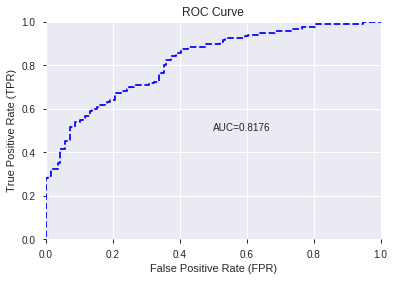

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


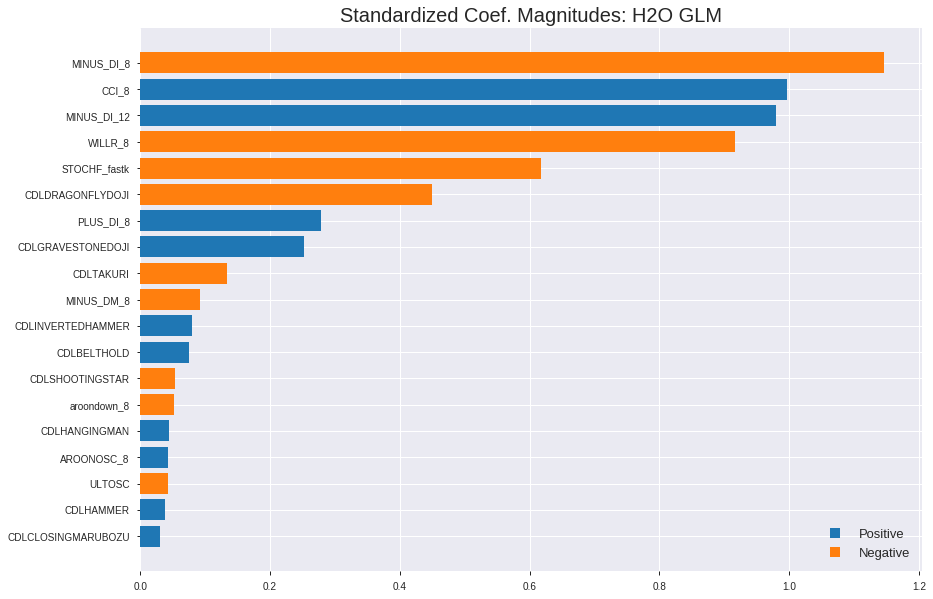

'log_likelihood'
--2019-08-22 13:04:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.88|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_130441_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_130441_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['MINUS_DI_8',
 'CCI_8',
 'MINUS_DI_12',
 'WILLR_8',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'MINUS_DM_8',
 'CDLINVERTEDHAMMER',
 'CDLBELTHOLD',
 'CDLSHOOTINGSTAR',
 'aroondown_8',
 'CDLHANGINGMAN',
 'AROONOSC_8',
 'ULTOSC',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU']

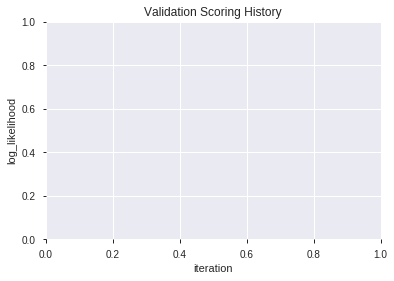

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_130456_model_6  0.822365  0.529442              0.227451  0.419006  0.175566
1  XGBoost_grid_1_AutoML_20190822_130456_model_4  0.820711  0.528781              0.232843  0.418088  0.174797
2  XGBoost_grid_1_AutoML_20190822_130456_model_3  0.820282  0.528224              0.238235  0.418979  0.175543
3               XGBoost_3_AutoML_20190822_130456  0.818321  0.532052              0.270098  0.420061  0.176452
4  XGBoost_grid_1_AutoML_20190822_130456_model_1  0.818260  0.532600              0.254167  0.420855  0.177119
5  XGBoost_grid_1_AutoML_20190822_130456_model_2  0.816452  0.534384              0.241176  0.421123  0.177345
6               XGBoost_2_AutoML_20190822_130456  0.811887  0.535358              0.237500  0.420910  0.177166
7  XGBoost_grid_1_AutoML_20190822_130456_model_5  0.805882  0.543630              0.257108  0.424007  0.179782
8               XGBoost_1_AutoML_20190822_130456  0.804534  0.541450              0.271569  0.424185  0.179933
9  XGBoost_grid_1_AutoML_20190822_130456_model_7  0.803370  0.547896              0.240441  0.426001  0.181477

variable  relative_importance  scaled_importance  percentage
0              WILLR_8          1189.021851           1.000000    0.129322
1         STOCHF_fastk          1156.586548           0.972721    0.125794
2                CCI_8          1001.700989           0.842458    0.108948
3               ULTOSC           757.988708           0.637489    0.082441
4     CDLDRAGONFLYDOJI           737.089233           0.619912    0.080168
5            PLUS_DI_8           734.901917           0.618073    0.079930
6           MINUS_DI_8           593.774780           0.499381    0.064581
7    CDLGRAVESTONEDOJI           589.420959           0.495719    0.064107
8           MINUS_DM_8           558.092407           0.469371    0.060700
9          MINUS_DI_12           520.118286           0.437434    0.056570
10           CDLTAKURI           506.754608           0.426195    0.055116
11         aroondown_8           485.884033           0.408642    0.052846
12          AROONOSC_8           290.190247           0.244058    0.031562
13  CDLCLOSINGMARUBOZU            33.997021           0.028592    0.003698
14         CDLBELTHOLD            20.173820           0.016967    0.002194
15           CDLHAMMER            11.910851           0.010017    0.001295
16   CDLINVERTEDHAMMER             6.667893           0.005608    0.000725

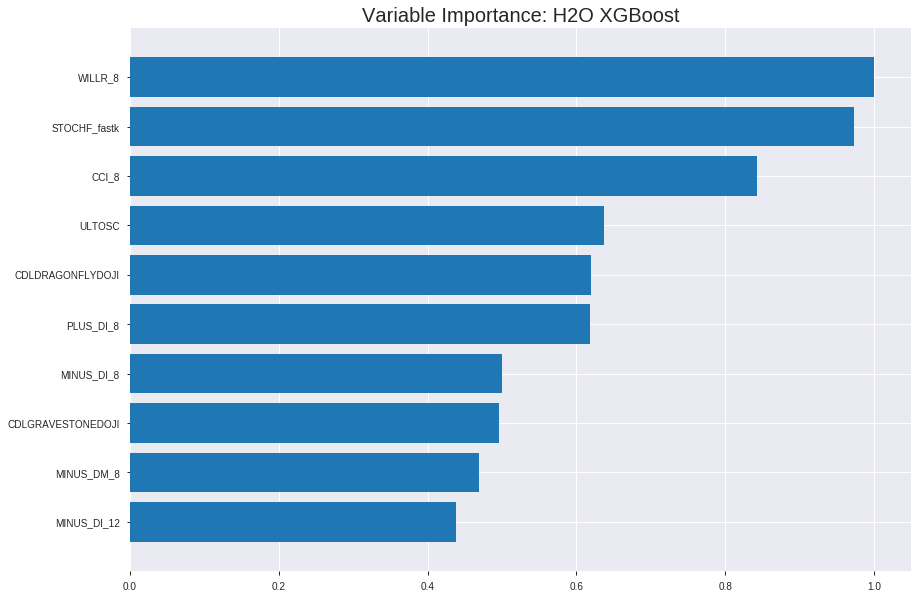

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_130456_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14723198093547904
RMSE: 0.3837081976391422
LogLoss: 0.45851110409715073
Mean Per-Class Error: 0.19327411964095154
AUC: 0.8888833092712323
pr_auc: 0.8913855921264627
Gini: 0.7777666185424645
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43497784733772277: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      606  284   0.3191   (284.0/890.0)
1      91   804   0.1017   (91.0/895.0)
Total  697  1088  0.2101   (375.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434978     0.810893  233
max f2                       0.317677     0.887736  288
max f0point5                 0.588625     0.815144  160
max accuracy                 0.523628     0.806723  192
max precision                0.958368     1         0
max recall                   0.12425      1         363
max specificity              0.958368     1         0
max absolute_mcc             0.523628     0.613449  192
max min_per_class_accuracy   0.523628     0.805587  192
max mean_per_class_accuracy  0.523628     0.806726  192

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.929332           1.99441   1.99441            1                0.938202   1                           0.938202            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.911082           1.99441   1.99441            1                0.919412   1                           0.928807            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.894672           1.99441   1.99441            1                0.904893   1                           0.920836            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.88397            1.99441   1.99441            1                0.888854   1                           0.91284             0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.870929           1.99441   1.99441            1                0.87741    1                           0.905754            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.822412           1.972     1.98327            0.988764         0.845846   0.994413                    0.875967            0.098324        0.198883                   97.2004   98.3271
    7        0.15014                     0.773266           1.88237   1.94976            0.94382          0.796511   0.977612                    0.849581            0.0938547       0.292737                   88.2368   94.9762
    8        0.2                         0.728062           1.81514   1.9162             0.910112         0.75391    0.960784                    0.82573             0.0905028       0.38324                    81.514    91.6201
    9        0.30028                     0.645746           1.60444   1.81209            0.804469         0.687573   0.908582                    0.779592            0.160894        0.544134                   60.4444   81.2088
    10       0.4                         0.58466            1.37816   1.70391            0.691011         0.613782   0.854342                    0.738256            0.13743         0.681564                   37.8162   70.3911
    11       0.50028                     0.522338           1.23676   1.61027            0.620112         0.55362    0.807391                    0.701246            0.124022        0.805587                   23.6759   61.0271
    12       0.6                         0.443526           0.806729  1.47672            0.404494         0.485086   0.74043                     0.66532             0.0804469       0.886034                   -19.3271  47.6723
    13       0.69972                     0.361837           0.605047  1.3525             0.303371         0.403896   0.678143                    0.628063            0.0603352       0.946369                   -39.4953  35.2497
    14       0.8                         0.261786           0.378827  1.23045            0.189944         0.312101   0.616947                    0.588458            0.0379888       0.984358                   -62.1173  23.0447
    15       0.89972                     0.137729           0.145659  1.11022            0.0730337        0.208175   0.556663                    0.546309            0.0145251       0.998883                   -85.4341  11.0215
    16       1                           0.040685           0.011142  1                  0.00558659       0.0901792  0.501401                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18411465504670066
RMSE: 0.42908583645548204
LogLoss: 0.5447017742447233
Mean Per-Class Error: 0.276470588235294
AUC: 0.7951710880430604
pr_auc: 0.7921050863716907
Gini: 0.5903421760861207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35112428665161133: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  137  0.5373   (137.0/255.0)
1      20   235  0.0784   (20.0/255.0)
Total  138  372  0.3078   (157.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351124     0.749601  285
max f2                       0.212107     0.85476   324
max f0point5                 0.623516     0.731109  144
max accuracy                 0.481467     0.723529  224
max precision                0.945101     1         0
max recall                   0.0692664    1         389
max specificity              0.945101     1         0
max absolute_mcc             0.481467     0.452381  224
max min_per_class_accuracy   0.543246     0.705882  193
max mean_per_class_accuracy  0.481467     0.723529  224

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.928118           2         2                  1                0.935783   1                           0.935783            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.915228           2         2                  1                0.920873   1                           0.929006            0.0196078       0.0431373                  100       100
    3        0.0313725                   0.906704           2         2                  1                0.91047    1                           0.923214            0.0196078       0.0627451                  100       100
    4        0.0411765                   0.898384           1.2       1.80952            0.6              0.901462   0.904762                    0.918035            0.0117647       0.0745098                  20        80.9524
    5        0.0509804                   0.887788           2         1.84615            1                0.893299   0.923077                    0.913278            0.0196078       0.0941176                  100       84.6154
    6        0.1                         0.843128           1.92      1.88235            0.96             0.865106   0.941176                    0.889664            0.0941176       0.188235                   92        88.2353
    7        0.15098                     0.801337           1.69231   1.81818            0.846154         0.823339   0.909091                    0.867269            0.0862745       0.27451                    69.2308   81.8182
    8        0.2                         0.746138           1.6       1.76471            0.8              0.77742    0.882353                    0.845247            0.0784314       0.352941                   60        76.4706
    9        0.3                         0.664393           1.21569   1.5817             0.607843         0.705297   0.79085                     0.798597            0.121569        0.47451                    21.5686   58.1699
    10       0.4                         0.605232           1.2549    1.5                0.627451         0.635894   0.75                        0.757921            0.12549         0.6                        25.4902   50
    11       0.5                         0.543246           1.05882   1.41176            0.529412         0.574088   0.705882                    0.721155            0.105882        0.705882                   5.88235   41.1765
    12       0.6                         0.471157           1.01961   1.34641            0.509804         0.502753   0.673203                    0.684754            0.101961        0.807843                   1.96078   34.6405
    13       0.7                         0.397729           0.784314  1.26611            0.392157         0.438497   0.633053                    0.649575            0.0784314       0.886275                   -21.5686  26.6106
    14       0.8                         0.244891           0.588235  1.18137            0.294118         0.318263   0.590686                    0.608161            0.0588235       0.945098                   -41.1765  18.1373
    15       0.9                         0.126172           0.392157  1.09368            0.196078         0.178714   0.546841                    0.560444            0.0392157       0.984314                   -60.7843  9.36819
    16       1                           0.0463206          0.156863  1                  0.0784314        0.0902294  0.5                         0.513423        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:05:12  10.611 sec  0                  0.5              0.693147            0.5             0                  1                0.498599                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-22 13:05:12  10.687 sec  5                  0.476135         0.646197            0.810313        0.790743           1.99441          0.282353                         0.477146           0.648113              0.774464          0.741109             2                  0.301961
    2019-08-22 13:05:12  10.738 sec  10                 0.458483         0.611677            0.815283        0.810373           1.99441          0.284594                         0.460965           0.616276              0.784852          0.773208             1.66667            0.290196
    2019-08-22 13:05:12  10.795 sec  15                 0.445049         0.584952            0.823991        0.815697           1.99441          0.278992                         0.44987            0.593953              0.789935          0.770734             1.66667            0.286275
    2019-08-22 13:05:12  10.851 sec  20                 0.435834         0.565916            0.82849         0.827816           1.99441          0.271709                         0.443116           0.579691              0.793664          0.779704             1.66667            0.280392
    2019-08-22 13:05:12  10.911 sec  25                 0.427171         0.5479              0.835953        0.832486           1.99441          0.27451                          0.437722           0.568082              0.796471          0.781628             1.66667            0.323529
    2019-08-22 13:05:13  10.970 sec  30                 0.420315         0.533609            0.843474        0.845267           1.99441          0.247619                         0.436158           0.563735              0.792964          0.781877             1.66667            0.32549
    2019-08-22 13:05:13  11.043 sec  35                 0.414101         0.520476            0.849793        0.851148           1.99441          0.244818                         0.434501           0.559196              0.791519          0.78562              1.66667            0.32549
    2019-08-22 13:05:13  11.118 sec  40                 0.408732         0.50909             0.856307        0.857623           1.99441          0.22409                          0.432599           0.554522              0.793126          0.78773              2                  0.27451
    2019-08-22 13:05:13  11.184 sec  45                 0.403455         0.498229            0.862812        0.864834           1.99441          0.22409                          0.431444           0.551618              0.793418          0.785811             2                  0.301961
    2019-08-22 13:05:13  11.252 sec  50                 0.399226         0.489352            0.867841        0.868712           1.99441          0.219608                         0.430609           0.549139              0.793979          0.788816             2                  0.307843
    2019-08-22 13:05:13  11.318 sec  55                 0.394375         0.479711            0.874347        0.87602            1.99441          0.211204                         0.429673           0.546801              0.794902          0.789236 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
WILLR_8             1189.02                1                    0.129322
STOCHF_fastk        1156.59                0.972721             0.125794
CCI_8               1001.7                 0.842458             0.108948
ULTOSC              757.989                0.637489             0.0824414
CDLDRAGONFLYDOJI    737.089                0.619912             0.0801683
PLUS_DI_8           734.902                0.618073             0.0799304
MINUS_DI_8          593.775                0.499381             0.0645809
CDLGRAVESTONEDOJI   589.421                0.495719             0.0641074
MINUS_DM_8          558.092                0.469371             0.0607
MINUS_DI_12         520.118                0.437434             0.0565698
CDLTAKURI           506.755                0.426195             0.0551163
aroondown_8         485.884                0.408642             0.0528464
AROONOSC_8          290.19                 0.244058             0.0315621
CDLCLOSINGMARUBOZU  33.997                 0.0285924            0.00369763
CDLBELTHOLD         20.1738                0.0169667            0.00219417
CDLHAMMER           11.9109                0.0100174            0.00129546
CDLINVERTEDHAMMER   6.66789                0.00560788           0.000725222

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.7583333333333333)

('auc', 0.8223651960784314)

('logloss', 0.529442270076237)

('mean_per_class_error', 0.22745098039215694)

('rmse', 0.41900629939476675)

('mse', 0.1755662789324969)

xgboost prediction progress: |████████████████████████████████████████████| 100%


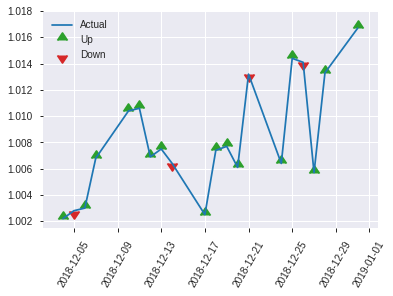


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1755662789324969
RMSE: 0.41900629939476675
LogLoss: 0.529442270076237
Mean Per-Class Error: 0.22745098039215694
AUC: 0.8223651960784314
pr_auc: 0.8033207832846707
Gini: 0.6447303921568628
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5514875650405884: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      107  29   0.2132   (29.0/136.0)
1      29   91   0.2417   (29.0/120.0)
Total  136  120  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.551488     0.758333  119
max f2                       0.407966     0.839753  168
max f0point5                 0.564505     0.762411  110
max accuracy                 0.551488     0.773438  119
max precision                0.93177      1         0
max recall                   0.081446     1         249
max specificity              0.93177      1         0
max absolute_mcc             0.551488     0.545098  119
max min_per_class_accuracy   0.551488     0.758333  119
max mean_per_class_accuracy  0.551488     0.772549  119

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 50.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.919165           2.13333   2.13333            1                0.926006   1                           0.926006            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.913157           2.13333   2.13333            1                0.915311   1                           0.920659            0.025           0.05                       113.333   113.333
    3        0.03125                     0.894298           2.13333   2.13333            1                0.903967   1                           0.916486            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.887638           2.13333   2.13333            1                0.889741   1                           0.909192            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.88007            2.13333   2.13333            1                0.886192   1                           0.905653            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.813338           1.80513   1.96923            0.846154         0.850608   0.923077                    0.878131            0.0916667       0.2                        80.5128   96.9231
    7        0.152344                    0.761507           1.80513   1.91453            0.846154         0.788439   0.897436                    0.848233            0.0916667       0.291667                   80.5128   91.453
    8        0.203125                    0.720655           1.64103   1.84615            0.769231         0.741964   0.865385                    0.821666            0.0833333       0.375                      64.1026   84.6154
    9        0.300781                    0.659046           1.36533   1.69004            0.64             0.689122   0.792208                    0.778632            0.133333        0.508333                   36.5333   69.0043
    10       0.402344                    0.581456           1.47692   1.63625            0.692308         0.623333   0.76699                     0.739431            0.15            0.658333                   47.6923   63.6246
    11       0.5                         0.530884           1.19467   1.55               0.56             0.556577   0.726562                    0.703717            0.116667        0.775                      19.4667   55
    12       0.601562                    0.458571           0.820513  1.42684            0.384615         0.497997   0.668831                    0.668985            0.0833333       0.858333                   -17.9487  42.684
    13       0.699219                    0.35271            0.512     1.29907            0.24             0.411253   0.608939                    0.632989            0.05            0.908333                   -48.8     29.9069
    14       0.800781                    0.24552            0.328205  1.17593            0.153846         0.296252   0.55122                     0.590281            0.0333333       0.941667                   -67.1795  17.5935
    15       0.898438                    0.13465            0.170667  1.06667            0.08             0.178793   0.5                         0.545554            0.0166667       0.958333                   -82.9333  6.66667
    16       1                           0.0448925          0.410256  1                  0.192308         0.0976428  0.46875                     0.5000

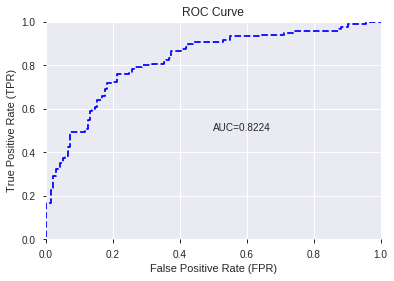

This function is available for GLM models only


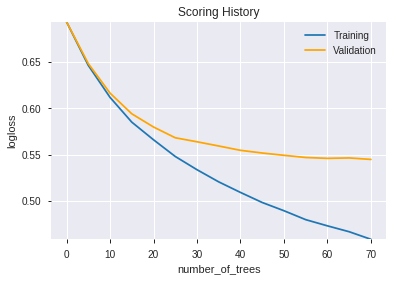

--2019-08-22 13:05:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_130456_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_130456_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['WILLR_8',
 'STOCHF_fastk',
 'CCI_8',
 'ULTOSC',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_8',
 'MINUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'MINUS_DM_8',
 'MINUS_DI_12',
 'CDLTAKURI',
 'aroondown_8',
 'AROONOSC_8',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

55

['BBANDS_upperband_14_1_3',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_4',
 'SMA_20',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_upperband_20_3_2',
 'BBANDS_middleband_20_3_2',
 'BBANDS_upperband_24_5_3',
 'ADX_8',
 'aroondown_8',
 'CCI_8',
 'DX_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'WILLR_8',
 'CCI_12',
 'PLUS_DI_12',
 'ROCP_12',
 'ROCR_12',
 'WILLR_12',
 'DX_14',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroonup_20',
 'PLUS_DI_20',
 'ROCR_20',
 'aroondown_24',
 'aroonup_24',
 'MACDFIX_24',
 'MINUS_DM_24',
 'ROCR_24',
 'WILLR_24',
 'aroonup_30',
 'MOM_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'NATR_12',
 'ATR_20',
 'TRANGE',
 'HT_PHASOR_inphase',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHIGHWAVE',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'LINEARREG_SLOPE_8']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_130702_model_9  0.828983  0.527115              0.259559  0.417094  0.173967
1  DeepLearning_grid_1_AutoML_20190822_130702_model_6  0.809130  0.530534              0.293627  0.422118  0.178184
2  DeepLearning_grid_1_AutoML_20190822_130702_model_8  0.797488  0.543228              0.301716  0.428212  0.183366
3  DeepLearning_grid_1_AutoML_20190822_130702_model_5  0.795466  0.552574              0.289461  0.430768  0.185561
4  DeepLearning_grid_1_AutoML_20190822_130702_model_7  0.793444  0.572232              0.283333  0.429091  0.184119
5  DeepLearning_grid_1_AutoML_20190822_130702_model_2  0.756373  0.579866              0.360294  0.449021  0.201620
6               DeepLearning_1_AutoML_20190822_130702  0.754596  0.728436              0.321569  0.485653  0.235859
7  DeepLearning_grid_1_AutoML_20190822_130702_model_3  0.750797  0.606036              0.355147  0.462302  0.213723
8  DeepLearning_grid_1_AutoML_20190822_130702_model_4  0.746140  0.719500              0.331863  0.484824  0.235055
9  DeepLearning_grid_1_AutoML_20190822_130702_model_1  0.744179  0.769838              0.315196  0.495874  0.245891

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             1.000000           1.000000    0.040471
1           CDLDRAGONFLYDOJI             0.890434           0.890434    0.036037
2             CDLRICKSHAWMAN             0.873406           0.873406    0.035348
3          CDLGRAVESTONEDOJI             0.754955           0.754955    0.030554
4                 MINUS_DI_8             0.711181           0.711181    0.028782
5               STOCHF_fastk             0.694117           0.694117    0.028092
6                      CCI_8             0.597627           0.597627    0.024187
7                     ULTOSC             0.564532           0.564532    0.022847
8                  PLUS_DI_8             0.549583           0.549583    0.022242
9                     CCI_12             0.525122           0.525122    0.021252
10                   WILLR_8             0.508763           0.508763    0.020590
11                  CORREL_8             0.500451           0.500451    0.020254
12         LINEARREG_SLOPE_8             0.448879           0.448879    0.018167
13   BBANDS_lowerband_20_2_3             0.448387           0.448387    0.018147
14                  WILLR_12             0.446938           0.446938    0.018088
15               CDLHIGHWAVE             0.436202           0.436202    0.017654
16                PLUS_DI_12             0.433807           0.433807    0.017557
17               aroondown_8             0.418900           0.418900    0.016953
18                  WILLR_14             0.410259           0.410259    0.016604
19              aroondown_24             0.405240           0.405240    0.016401
20                     ADX_8             0.404608           0.404608    0.016375
21   BBANDS_lowerband_14_4_2             0.403504           0.403504    0.016330
22                      DX_8             0.402284           0.402284    0.016281
23   BBANDS_lowerband_14_7_2             0.399308           0.399308    0.016160
24                PLUS_DI_20             0.398265           0.398265    0.016118
25                   ROCR_24             0.397507           0.397507    0.016088
26                    ATR_20             0.396174           0.396174    0.016034
27                   NATR_12             0.395350           0.395350    0.016000
28               MINUS_DM_24             0.394928           0.394928    0.015983
29               STOCH_slowk             0.393734           0.393734    0.015935
30   BBANDS_lowerband_14_6_2             0.392152           0.392152    0.015871
31              STOCHF_fastd             0.385722           0.385722    0.015611
32                     DX_14             0.385575           0.385575    0.015605
33  BBANDS_middleband_20_3_2             0.384933           0.384933    0.015579
34                    MOM_30             0.381415           0.381415    0.015436
35                    SMA_20             0.381010           0.381010    0.015420
36                aroonup_30             0.379608           0.379608    0.015363
37                   ROCR_20             0.374147           0.374147    0.015142
38   BBANDS_upperband_24_5_3             0.374142           0.374142    0.015142
39   BBANDS_upperband_14_7_4             0.369852           0.369852    0.014968
40                    RSI_14             0.367930           0.367930    0.014891
41                aroonup_20             0.366663           0.366663    0.014839
42   BBANDS_upperband_20_3_2             0.366040           0.366040    0.014814
43            STOCHRSI_fastk             0.364437           0.364437    0.014749
44         HT_PHASOR_inphase             0.360953           0.360953    0.014608
45                MACDFIX_24             0.360090           0.360090    0.014573
46   BBANDS_upperband_14_5_5             0.355596           0.355596    0.014391
47                aroonup_24             0.353504           0.353504    0.014307
48                  WILLR_24             0.352379  

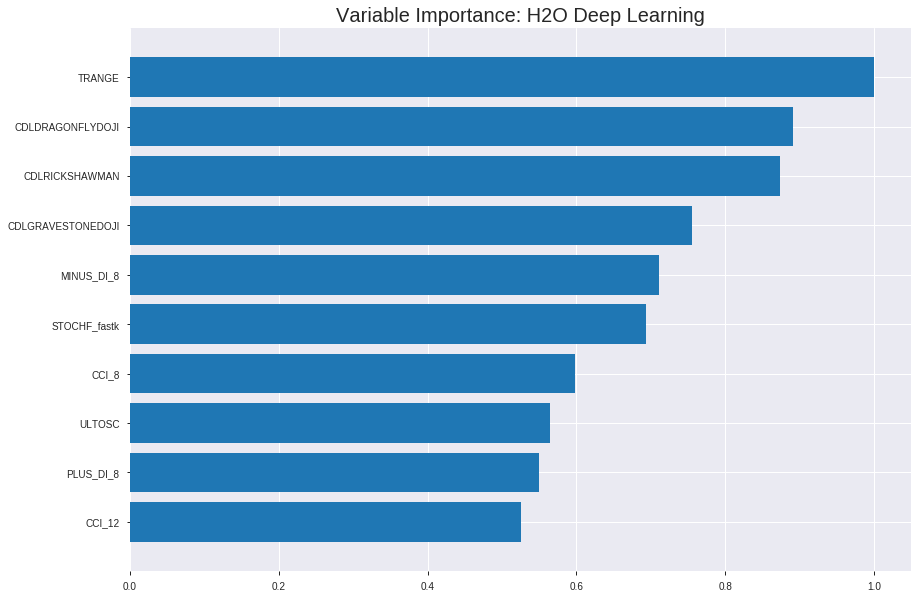

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_130702_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17204142784283602
RMSE: 0.41477876975905603
LogLoss: 0.5114875452505327
Mean Per-Class Error: 0.2697225535120207
AUC: 0.8221216496139602
pr_auc: 0.8143564076516506
Gini: 0.6442432992279203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43687710476853975: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      442  448   0.5034   (448.0/890.0)
1      68   827   0.076    (68.0/895.0)
Total  510  1275  0.2891   (516.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436877     0.762212  253
max f2                       0.172572     0.869911  330
max f0point5                 0.534038     0.747801  179
max accuracy                 0.492242     0.730532  216
max precision                0.999855     1         0
max recall                   0.0212317    1         392
max specificity              0.999855     1         0
max absolute_mcc             0.492242     0.468481  216
max min_per_class_accuracy   0.510527     0.726257  199
max mean_per_class_accuracy  0.492242     0.730277  216

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.40 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.972322           1.88361    1.88361            0.944444         0.978319  0.944444                    0.978319            0.0189944       0.0189944                  88.3613   88.3613
    2        0.0201681                   0.966767           1.88361    1.88361            0.944444         0.970002  0.944444                    0.97416             0.0189944       0.0379888                  88.3613   88.3613
    3        0.0302521                   0.96435            1.99441    1.92055            1                0.965544  0.962963                    0.971288            0.0201117       0.0581006                  99.4413   92.0546
    4        0.0403361                   0.961627           1.77281    1.88361            0.888889         0.963017  0.944444                    0.96922             0.0178771       0.0759777                  77.2812   88.3613
    5        0.0504202                   0.958436           1.88361    1.88361            0.944444         0.960293  0.944444                    0.967435            0.0189944       0.0949721                  88.3613   88.3613
    6        0.10028                     0.939845           1.83755    1.86071            0.921348         0.949418  0.932961                    0.958477            0.0916201       0.186592                   83.7549   86.071
    7        0.15014                     0.895786           1.81514    1.84558            0.910112         0.923007  0.925373                    0.946698            0.0905028       0.277095                   81.514    84.5577
    8        0.2                         0.801632           1.61346    1.78771            0.808989         0.852858  0.896359                    0.923303            0.0804469       0.357542                   61.3458   78.7709
    9        0.30028                     0.574222           1.37046    1.64837            0.687151         0.654327  0.826493                    0.833477            0.13743         0.494972                   37.0463   64.8368
    10       0.4                         0.533618           1.32214    1.56704            0.662921         0.552765  0.785714                    0.763496            0.131844        0.626816                   32.2139   56.7039
    11       0.50028                     0.509698           1.02506    1.4584             0.513966         0.519525  0.731243                    0.714592            0.102793        0.729609                   2.50616   45.8401
    12       0.6                         0.490198           0.986002   1.37989            0.494382         0.500224  0.691877                    0.678964            0.098324        0.827933                   -1.39979  37.9888
    13       0.69972                     0.448668           0.817934   1.2998             0.410112         0.474097  0.651721                    0.649768            0.0815642       0.909497                   -18.2066  29.9802
    14       0.8                         0.225297           0.612809   1.21369            0.307263         0.370661  0.608543                    0.614782            0.0614525       0.97095                    -38.7191  21.3687
    15       0.89972                     0.0358308          0.224091   1.10401            0.11236          0.097863  0.553549                    0.557489            0.0223464       0.993296                   -77.5909  10.4006
    16       1                           0.0083831          0.0668518  1                  0.0335196        0.024122  0.501401                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1849692226446335
RMSE: 0.4300804839150848
LogLoss: 0.5535130357821426
Mean Per-Class Error: 0.2901960784313725
AUC: 0.7819530949634756
pr_auc: 0.7697860881696552
Gini: 0.5639061899269513
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4712350800820594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  127  0.498    (127.0/255.0)
1      22   233  0.0863   (22.0/255.0)
Total  150  360  0.2922   (149.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471235     0.757724  271
max f2                       0.260145     0.861948  311
max f0point5                 0.56506      0.716065  118
max accuracy                 0.477404     0.709804  264
max precision                0.970253     1         0
max recall                   0.0244286    1         391
max specificity              0.970253     1         0
max absolute_mcc             0.471235     0.456151  271
max min_per_class_accuracy   0.50881      0.694118  198
max mean_per_class_accuracy  0.477404     0.709804  264

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.962883           2         2                  1                0.966001   1                           0.966001            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.956344           1.6       1.81818            0.8              0.959645   0.909091                    0.963112            0.0156863       0.0392157                  60        81.8182
    3        0.0313725                   0.94895            2         1.875              1                0.9513     0.9375                      0.95942             0.0196078       0.0588235                  100       87.5
    4        0.0411765                   0.942128           1.2       1.71429            0.6              0.946426   0.857143                    0.956326            0.0117647       0.0705882                  20        71.4286
    5        0.0509804                   0.939605           2         1.76923            1                0.940716   0.884615                    0.953324            0.0196078       0.0901961                  100       76.9231
    6        0.1                         0.893767           1.84      1.80392            0.92             0.919731   0.901961                    0.936857            0.0901961       0.180392                   84        80.3922
    7        0.15098                     0.838325           1.61538   1.74026            0.807692         0.870569   0.87013                     0.914474            0.0823529       0.262745                   61.5385   74.026
    8        0.2                         0.731975           1.68      1.72549            0.84             0.792683   0.862745                    0.884623            0.0823529       0.345098                   68        72.549
    9        0.3                         0.548415           1.2549    1.56863            0.627451         0.637027   0.784314                    0.802091            0.12549         0.470588                   25.4902   56.8627
    10       0.4                         0.519155           1.09804   1.45098            0.54902          0.530289   0.72549                     0.734141            0.109804        0.580392                   9.80392   45.098
    11       0.5                         0.508061           1.13725   1.38824            0.568627         0.513308   0.694118                    0.689974            0.113725        0.694118                   13.7255   38.8235
    12       0.6                         0.495528           0.980392  1.32026            0.490196         0.502173   0.660131                    0.658674            0.0980392       0.792157                   -1.96078  32.0261
    13       0.7                         0.47311            1.13725   1.29412            0.568627         0.486062   0.647059                    0.634015            0.113725        0.905882                   13.7255   29.4118
    14       0.8                         0.256513           0.588235  1.20588            0.294118         0.408489   0.602941                    0.605824            0.0588235       0.964706                   -41.1765  20.5882
    15       0.9                         0.0455072          0.117647  1.08497            0.0588235        0.108491   0.542484                    0.550565            0.0117647       0.976471                   -88.2353  8.49673
    16       1                           0.0143996          0.235294  1                  0.117647         0.0320839  0.5                         0.498717 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:14:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:14:16  2 min 37.176 sec  467 obs/sec       0.506443  1             904        0.598674         1.2171              -0.433651      0.700718        0.698048           1.88361          0.4                              0.561051           1.01104               -0.259114        0.744821          0.75094              2                  0.354902
    2019-08-22 13:14:27  2 min 48.051 sec  759 obs/sec       5.00784   10            8939       0.432117         0.55348             0.253095       0.786787        0.777368           1.88361          0.313725                         0.438475           0.569651              0.230958         0.776855          0.767854             1.66667            0.294118
    2019-08-22 13:14:38  2 min 59.093 sec  908 obs/sec       11.079    22            19776      0.433494         0.549014            0.248328       0.804624        0.802161           1.99441          0.314286                         0.445831           0.58034               0.204937         0.762668          0.761111             2                  0.333333
    2019-08-22 13:14:49  3 min 10.184 sec  1018 obs/sec      18.1513   36            32400      0.425936         0.533698            0.274309       0.800205        0.797439           1.88361          0.29972                          0.442275           0.573471              0.21757          0.767074          0.754426             1.66667            0.301961
    2019-08-22 13:15:00  3 min 20.887 sec  1085 obs/sec      25.2291   50            45034      0.417484         0.516096            0.302824       0.821771        0.816618           1.99441          0.271709                         0.438216           0.567281              0.231868         0.760331          0.751146             2                  0.32549
    2019-08-22 13:15:11  3 min 31.667 sec  1142 obs/sec      32.7787   65            58510      0.414779         0.511488            0.311829       0.822122        0.814356           1.88361          0.289076                         0.43008            0.553513              0.260123         0.781953          0.769786             2                  0.292157
    2019-08-22 13:15:22  3 min 42.612 sec  1191 obs/sec      40.814    81            72853      0.408512         0.499766            0.332468       0.833564        0.826305           1.88361          0.270588                         0.432365           0.557666              0.252243         0.778147          0.769599             1.66667            0.323529
    2019-08-22 13:15:32  3 min 53.365 sec  1233 obs/sec      48.9742   97            87419      0.404706         0.492435            0.344848       0.839832        0.836481           1.99441          0.268347                         0.437484           0.577893              0.23443          0.762468          0.750567             1.66667            0.321569
    2019-08-22 13:15:43 

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
TRANGE             1.0                    1.0                  0.04047128844261554
CDLDRAGONFLYDOJI   0.8904338479042053     0.8904338479042053   0.03603700509759915
CDLRICKSHAWMAN     0.873405933380127      0.873405933380127    0.035347863457318975
CDLGRAVESTONEDOJI  0.754954993724823      0.754954993724823    0.03055400131223032
MINUS_DI_8         0.711180567741394      0.711180567741394    0.02878239389184504
---                ---                    ---                  ---
ROC_14             0.35083937644958496    0.35083937644958496  0.014198921601318531
ROCR_14            0.35020655393600464    0.35020655393600464  0.014173310458838441
ROCP_12            0.33940669894218445    0.33940669894218445  0.013736226412245122
ROCR_12            0.3313460648059845     0.3313460648059845   0.013410002163088582
ROCR100_14         0.3245561122894287     0.3245561122894287   0.013135204036279388


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7578947368421052)

('auc', 0.8289828431372549)

('logloss', 0.5271153384715042)

('mean_per_class_error', 0.23921568627450984)

('rmse', 0.4170941140457823)

('mse', 0.17396749997163602)

deeplearning prediction progress: |███████████████████████████████████████| 100%


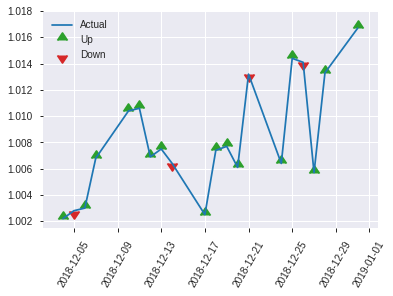


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17396749997163602
RMSE: 0.4170941140457823
LogLoss: 0.5271153384715042
Mean Per-Class Error: 0.23921568627450984
AUC: 0.8289828431372549
pr_auc: 0.8090119235076889
Gini: 0.6579656862745098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48100442836352086: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   57   0.4191   (57.0/136.0)
1      12   108  0.1      (12.0/120.0)
Total  91   165  0.2695   (69.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481004     0.757895  164
max f2                       0.342662     0.843195  195
max f0point5                 0.522591     0.766129  93
max accuracy                 0.514405     0.765625  103
max precision                0.973851     1         0
max recall                   0.0234685    1         251
max specificity              0.973851     1         0
max absolute_mcc             0.514405     0.529948  103
max min_per_class_accuracy   0.504617     0.733333  123
max mean_per_class_accuracy  0.514405     0.760784  103

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 48.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.954229           2.13333   2.13333            1                0.964063   1                           0.964063            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.948497           1.42222   1.77778            0.666667         0.951086   0.833333                    0.957575            0.0166667       0.0416667                  42.2222   77.7778
    3        0.03125                     0.94193            2.13333   1.86667            1                0.943685   0.875                       0.954102            0.0166667       0.0583333                  113.333   86.6667
    4        0.0429688                   0.939076           2.13333   1.93939            1                0.940897   0.909091                    0.950501            0.025           0.0833333                  113.333   93.9394
    5        0.0507812                   0.925805           2.13333   1.96923            1                0.931187   0.923077                    0.94753             0.0166667       0.1                        113.333   96.9231
    6        0.101562                    0.899989           2.13333   2.05128            1                0.915587   0.961538                    0.931558            0.108333        0.208333                   113.333   105.128
    7        0.152344                    0.822996           1.80513   1.96923            0.846154         0.869454   0.923077                    0.910857            0.0916667       0.3                        80.5128   96.9231
    8        0.203125                    0.733019           1.96923   1.96923            0.923077         0.777354   0.923077                    0.877481            0.1             0.4                        96.9231   96.9231
    9        0.300781                    0.538909           1.45067   1.80087            0.68             0.604157   0.844156                    0.78874             0.141667        0.541667                   45.0667   80.0866
    10       0.402344                    0.515663           1.31282   1.67767            0.615385         0.525769   0.786408                    0.722359            0.133333        0.675                      31.2821   67.767
    11       0.5                         0.501512           0.597333  1.46667            0.28             0.507057   0.6875                      0.680307            0.0583333       0.733333                   -40.2667  46.6667
    12       0.601562                    0.486388           1.06667   1.39913            0.5              0.492965   0.655844                    0.648678            0.108333        0.841667                   6.66667   39.9134
    13       0.699219                    0.452643           0.768     1.31099            0.36             0.476277   0.614525                    0.6246              0.075           0.916667                   -23.2     31.0987
    14       0.800781                    0.188806           0.328205  1.18634            0.153846         0.356132   0.556098                    0.59055             0.0333333       0.95                       -67.1795  18.6341
    15       0.898438                    0.0438906          0.341333  1.09449            0.16             0.0782831  0.513043                    0.534869            0.0333333       0.983333                   -65.8667  9.44928
    16       1                           0.0194302          0.164103  1                  0.0769231        0.0321738  0.46875                     

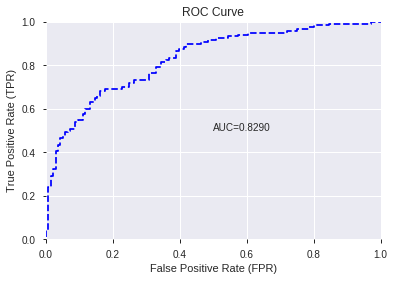

This function is available for GLM models only


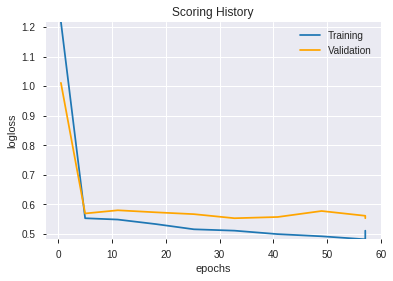

--2019-08-22 13:15:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.201.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.201.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_130702_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_130702_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'STOCHF_fastk',
 'CCI_8',
 'ULTOSC',
 'PLUS_DI_8',
 'CCI_12',
 'WILLR_8',
 'CORREL_8',
 'LINEARREG_SLOPE_8',
 'BBANDS_lowerband_20_2_3',
 'WILLR_12',
 'CDLHIGHWAVE',
 'PLUS_DI_12',
 'aroondown_8',
 'WILLR_14',
 'aroondown_24',
 'ADX_8',
 'BBANDS_lowerband_14_4_2',
 'DX_8',
 'BBANDS_lowerband_14_7_2',
 'PLUS_DI_20',
 'ROCR_24',
 'ATR_20',
 'NATR_12',
 'MINUS_DM_24',
 'STOCH_slowk',
 'BBANDS_lowerband_14_6_2',
 'STOCHF_fastd',
 'DX_14',
 'BBANDS_middleband_20_3_2',
 'MOM_30',
 'SMA_20',
 'aroonup_30',
 'ROCR_20',
 'BBANDS_upperband_24_5_3',
 'BBANDS_upperband_14_7_4',
 'RSI_14',
 'aroonup_20',
 'BBANDS_upperband_20_3_2',
 'STOCHRSI_fastk',
 'HT_PHASOR_inphase',
 'MACDFIX_24',
 'BBANDS_upperband_14_5_5',
 'aroonup_24',
 'WILLR_24',
 'BBANDS_upperband_14_1_3',
 'ROC_14',
 'ROCR_14',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_14']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_131602_model_1  0.80527  0.532713              0.309559  0.425121  0.180728

variable  relative_importance  scaled_importance  percentage
0               STOCHF_fastk             0.627984           1.000000    0.088318
1           CDLDRAGONFLYDOJI             0.541247           0.861881    0.076119
2                  PLUS_DI_8             0.453952           0.722872    0.063842
3                      CCI_8             0.432726           0.689072    0.060857
4                     CCI_12             0.376208           0.599072    0.052909
5                 MINUS_DI_8             0.375626           0.598147    0.052827
6                   WILLR_12             0.348532           0.555001    0.049016
7          CDLGRAVESTONEDOJI             0.318273           0.506817    0.044761
8                    WILLR_8             0.289638           0.461218    0.040734
9               aroondown_24             0.250329           0.398624    0.035205
10                    RSI_14             0.245953           0.391655    0.034590
11         LINEARREG_SLOPE_8             0.222957           0.355036    0.031356
12                  WILLR_14             0.187231           0.298146    0.026332
13               aroondown_8             0.164299           0.261630    0.023107
14            STOCHRSI_fastk             0.163128           0.259764    0.022942
15                PLUS_DI_20             0.160679           0.255865    0.022597
16                   ROCR_24             0.151490           0.241232    0.021305
17                aroonup_30             0.123725           0.197019    0.017400
18                      DX_8             0.119027           0.189538    0.016740
19            CDLRICKSHAWMAN             0.105322           0.167715    0.014812
20                PLUS_DI_12             0.104761           0.166822    0.014733
21                    ULTOSC             0.100251           0.159639    0.014099
22                aroonup_20             0.075993           0.121011    0.010687
23   BBANDS_upperband_24_5_3             0.074204           0.118162    0.010436
24              STOCHF_fastd             0.069732           0.111041    0.009807
25               STOCH_slowk             0.069037           0.109935    0.009709
26                aroonup_24             0.060676           0.096620    0.008533
27   BBANDS_lowerband_20_2_3             0.059962           0.095483    0.008433
28                  CORREL_8             0.059531           0.094798    0.008372
29   BBANDS_lowerband_14_6_2             0.055499           0.088377    0.007805
30                    MOM_30             0.053784           0.085646    0.007564
31                   NATR_12             0.052511           0.083619    0.007385
32                MACDFIX_24             0.050997           0.081208    0.007172
33         HT_PHASOR_inphase             0.048064           0.076537    0.006760
34                     ADX_8             0.042788           0.068136    0.006018
35   BBANDS_lowerband_14_7_2             0.042495           0.067669    0.005976
36   BBANDS_upperband_14_5_5             0.040541           0.064557    0.005702
37                    TRANGE             0.040257           0.064105    0.005662
38                   ROCR_20             0.039539           0.062961    0.005561
39                  WILLR_24             0.037335           0.059453    0.005251
40               CDLHIGHWAVE             0.036222           0.057680    0.005094
41   BBANDS_lowerband_14_4_2             0.034589           0.055079    0.004864
42   BBANDS_upperband_14_1_3             0.031417           0.050029    0.004418
43   BBANDS_upperband_14_7_4             0.029988           0.047753    0.004217
44                    ATR_20             0.026117           0.041589    0.003673
45   BBANDS_upperband_20_3_2             0.022268           0.035460    0.003132
46                    ROC_14             0.016358           0.026048    0.002301
47                   ROCR_14             0.015970           0.025430    0.002246
48                ROCR100_14             0.015495  

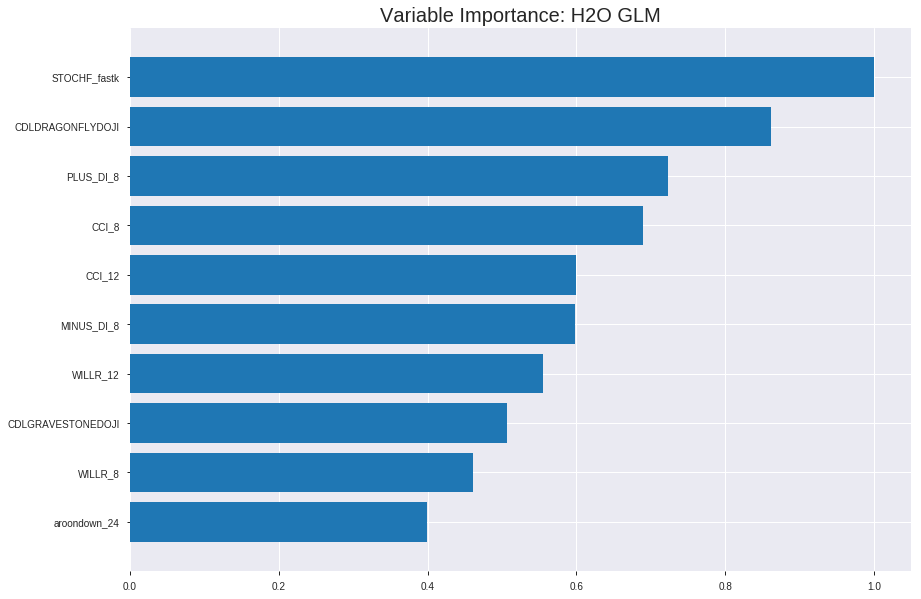

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131602_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18297893447600744
RMSE: 0.4277603703897866
LogLoss: 0.5425457289048287
Null degrees of freedom: 1784
Residual degrees of freedom: 1729
Null deviance: 2474.52142897845
Residual deviance: 1936.8882521902385
AIC: 2048.8882521902387
AUC: 0.8013288556901639
pr_auc: 0.7887871289422406
Gini: 0.6026577113803278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45839039738126897: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      578  312   0.3506   (312.0/890.0)
1      170  725   0.1899   (170.0/895.0)
Total  748  1037  0.27     (482.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45839      0.750518  229
max f2                       0.238377     0.858685  326
max f0point5                 0.536023     0.730666  189
max accuracy                 0.477994     0.735014  218
max precision                0.999785     1         0
max recall                   0.0480795    1         388
max specificity              0.999785     1         0
max absolute_mcc             0.476721     0.472443  219
max min_per_class_accuracy   0.50658      0.72514   202
max mean_per_class_accuracy  0.477994     0.734875  218

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.953275           1.88361   1.88361            0.944444         0.968719   0.944444                    0.968719            0.0189944       0.0189944                  88.3613   88.3613
    2        0.0201681                   0.938531           1.88361   1.88361            0.944444         0.94575    0.944444                    0.957235            0.0189944       0.0379888                  88.3613   88.3613
    3        0.0302521                   0.91941            1.77281   1.84668            0.888889         0.928906   0.925926                    0.947792            0.0178771       0.0558659                  77.2812   84.6679
    4        0.0403361                   0.909605           1.77281   1.82821            0.888889         0.91374    0.916667                    0.939279            0.0178771       0.073743                   77.2812   82.8212
    5        0.0504202                   0.889371           1.99441   1.86145            1                0.900637   0.933333                    0.93155             0.0201117       0.0938547                  99.4413   86.1453
    6        0.10028                     0.830947           1.74791   1.805              0.876404         0.860209   0.905028                    0.896079            0.0871508       0.181006                   74.7913   80.5
    7        0.15014                     0.767248           1.63587   1.74883            0.820225         0.801602   0.876866                    0.864704            0.0815642       0.26257                    63.5867   74.8833
    8        0.2                         0.711771           1.479     1.68156            0.741573         0.737503   0.843137                    0.832993            0.073743        0.336313                   47.9003   68.1564
    9        0.30028                     0.624298           1.39275   1.58511            0.698324         0.664307   0.794776                    0.776659            0.139665        0.475978                   39.2747   58.5112
    10       0.4                         0.563569           1.28853   1.51117            0.646067         0.59477    0.757703                    0.731314            0.128492        0.604469                   28.8526   51.1173
    11       0.50028                     0.503549           1.20333   1.44947            0.603352         0.533754   0.726764                    0.691714            0.12067         0.72514                    20.3333   44.9467
    12       0.6                         0.449853           0.974798  1.37058            0.488764         0.476076   0.687208                    0.655875            0.0972067       0.822346                   -2.52024  37.0577
    13       0.69972                     0.392379           0.728297  1.27904            0.365169         0.420377   0.641313                    0.622313            0.0726257       0.894972                   -27.1703  27.9043
    14       0.8                         0.306414           0.590525  1.19274            0.296089         0.352158   0.598039                    0.588449            0.0592179       0.95419                    -40.9475  19.2737
    15       0.89972                     0.136516           0.313728  1.09531            0.157303         0.230886   0.549191                    0.548819            0.0312849       0.985475                   -68.6272  9.5313
    16       1                           0.0131632          0.144846  1                  0.0726257        0.0759605  0.501401                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18888036901944424
RMSE: 0.43460369190728726
LogLoss: 0.5593590384435959
Null degrees of freedom: 509
Residual degrees of freedom: 454
Null deviance: 707.0141257874837
Residual deviance: 570.5462192124678
AIC: 682.5462192124678
AUC: 0.7832910419069589
pr_auc: 0.7707336508018696
Gini: 0.5665820838139177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2970527392285715: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      90   165  0.6471   (165.0/255.0)
1      11   244  0.0431   (11.0/255.0)
Total  101  409  0.3451   (176.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297053     0.73494   314
max f2                       0.181348     0.855578  340
max f0point5                 0.585537     0.733573  167
max accuracy                 0.563142     0.721569  178
max precision                0.988828     1         0
max recall                   0.0315973    1         395
max specificity              0.988828     1         0
max absolute_mcc             0.563142     0.445833  178
max min_per_class_accuracy   0.542524     0.686275  192
max mean_per_class_accuracy  0.563142     0.721569  178

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 52.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.977371           2         2                  1                0.981749   1                           0.981749            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.963503           0.8       1.45455            0.4              0.970793   0.727273                    0.976769            0.00784314      0.0313725                  -20       45.4545
    3        0.0313725                   0.951354           2         1.625              1                0.95353    0.8125                      0.969507            0.0196078       0.0509804                  100       62.5
    4        0.0411765                   0.943942           2         1.71429            1                0.948428   0.857143                    0.964488            0.0196078       0.0705882                  100       71.4286
    5        0.0509804                   0.931768           2         1.76923            1                0.937204   0.884615                    0.959241            0.0196078       0.0901961                  100       76.9231
    6        0.1                         0.889341           1.76      1.76471            0.88             0.906584   0.882353                    0.933429            0.0862745       0.176471                   76        76.4706
    7        0.15098                     0.834527           1.84615   1.79221            0.923077         0.859278   0.896104                    0.908391            0.0941176       0.270588                   84.6154   79.2208
    8        0.2                         0.767315           1.76      1.78431            0.88             0.807666   0.892157                    0.883703            0.0862745       0.356863                   76        78.4314
    9        0.3                         0.654356           1.2549    1.60784            0.627451         0.716409   0.803922                    0.827939            0.12549         0.482353                   25.4902   60.7843
    10       0.4                         0.596811           1.21569   1.5098             0.607843         0.628097   0.754902                    0.777978            0.121569        0.603922                   21.5686   50.9804
    11       0.5                         0.5335             0.823529  1.37255            0.411765         0.56372    0.686275                    0.735126            0.0823529       0.686275                   -17.6471  37.2549
    12       0.6                         0.47716            1.01961   1.31373            0.509804         0.507751   0.656863                    0.69723             0.101961        0.788235                   1.96078   31.3725
    13       0.7                         0.413297           0.901961  1.2549             0.45098          0.446405   0.627451                    0.661398            0.0901961       0.878431                   -9.80392  25.4902
    14       0.8                         0.30146            0.745098  1.19118            0.372549         0.365711   0.595588                    0.624437            0.0745098       0.952941                   -25.4902  19.1176
    15       0.9                         0.118638           0.313725  1.09368            0.156863         0.207024   0.546841                    0.578058            0.0313725       0.984314                   -68.6275  9.36819
    16       1                           0.0205705          0.156863  1                  0.0784314        0.0720362  0.5                         0.5274


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:16:03  0.000 sec   2            .15E2     56            1.3753384829772266  1.3743181427374525
     2019-08-22 13:16:03  0.017 sec   4            .92E1     56            1.369141719959212   1.3674777552135022
     2019-08-22 13:16:03  0.035 sec   6            .57E1     56            1.359816982698546   1.357144179037727
     2019-08-22 13:16:03  0.053 sec   8            .36E1     56            1.3462358374885135  1.3420784533922592
     2019-08-22 13:16:03  0.073 sec   10           .22E1     56            1.3273415868970644  1.3211783528381638
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:16:03  0.333 sec   34           .73E-2    56            1.0806404073137545  1.1189483690573159
     2019-08-22 13:16:03  0.349 sec   36           .45E-2    56            1.0776663437074852  1.1198370283797534
     2019-08-22 13:16:03  0.377 sec   38           .28E-2    56            1.0756692395305925  1.1208974407272416
     2019-08-22 13:16:03  0.403 sec   40           .17E-2    56            1.0743453179611537  1.1217524050571774
     2019-08-22 13:16:03  0.430 sec   42           .11E-2    56            1.0734053197005111  1.1223227195568566


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.75)

('F1', 0.7278688524590164)

('auc', 0.8052696078431373)

('logloss', 0.5327126161102076)

('mean_per_class_error', 0.25441176470588234)

('rmse', 0.4251214996113319)

('mse', 0.18072828943178765)

glm prediction progress: |████████████████████████████████████████████████| 100%


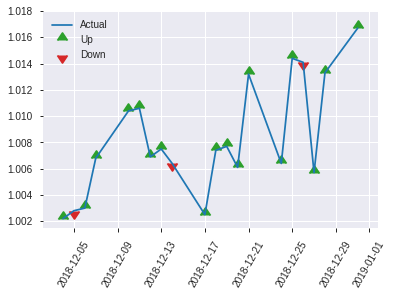


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18072828943178765
RMSE: 0.4251214996113319
LogLoss: 0.5327126161102076
Null degrees of freedom: 255
Residual degrees of freedom: 200
Null deviance: 354.9830011899469
Residual deviance: 272.7488594484263
AIC: 384.7488594484263
AUC: 0.8052696078431373
pr_auc: 0.8037474629651055
Gini: 0.6105392156862746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36393372851254524: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   74   0.5441   (74.0/136.0)
1      9    111  0.075    (9.0/120.0)
Total  71   185  0.3242   (83.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363934     0.727869  184
max f2                       0.342544     0.842027  190
max f0point5                 0.624146     0.754132  90
max accuracy                 0.568897     0.75      105
max precision                0.985233     1         0
max recall                   0.0777742    1         250
max specificity              0.985233     1         0
max absolute_mcc             0.568897     0.497621  105
max min_per_class_accuracy   0.527183     0.716667  121
max mean_per_class_accuracy  0.568897     0.745588  105

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.963854           2.13333   2.13333            1                0.974059   1                           0.974059            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.9534             2.13333   2.13333            1                0.95875    1                           0.966405            0.025           0.05                       113.333   113.333
    3        0.03125                     0.949426           2.13333   2.13333            1                0.950944   1                           0.962539            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.938152           2.13333   2.13333            1                0.943114   1                           0.957242            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.928386           2.13333   2.13333            1                0.933295   1                           0.953558            0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.878904           2.13333   2.13333            1                0.903228   1                           0.928393            0.108333        0.216667                   113.333   113.333
    7        0.152344                    0.826593           1.64103   1.96923            0.769231         0.857018   0.923077                    0.904601            0.0833333       0.3                        64.1026   96.9231
    8        0.203125                    0.760994           1.80513   1.92821            0.846154         0.794786   0.903846                    0.877147            0.0916667       0.391667                   80.5128   92.8205
    9        0.300781                    0.647725           1.28      1.71775            0.6              0.70141    0.805195                    0.82009             0.125           0.516667                   28        71.7749
    10       0.402344                    0.57211            1.39487   1.63625            0.653846         0.616254   0.76699                     0.768636            0.141667        0.658333                   39.4872   63.6246
    11       0.5                         0.512381           0.597333  1.43333            0.28             0.540525   0.671875                    0.724083            0.0583333       0.716667                   -40.2667  43.3333
    12       0.601562                    0.450057           0.820513  1.32987            0.384615         0.479656   0.623377                    0.682816            0.0833333       0.8                        -17.9487  32.987
    13       0.699219                    0.385615           0.853333  1.26331            0.4              0.417721   0.592179                    0.645792            0.0833333       0.883333                   -14.6667  26.3315
    14       0.800781                    0.278327           0.574359  1.17593            0.269231         0.334388   0.55122                     0.606297            0.0583333       0.941667                   -42.5641  17.5935
    15       0.898438                    0.132671           0.341333  1.08522            0.16             0.200419   0.508696                    0.56218             0.0333333       0.975                      -65.8667  8.52174
    16       1                           0.023323           0.246154  1                  0.115385         0.0911851  0.46875                     

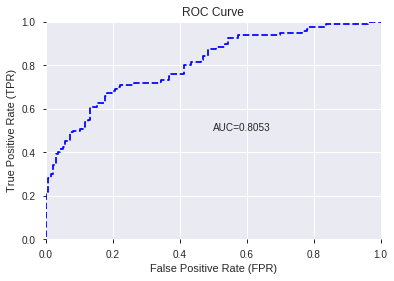

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


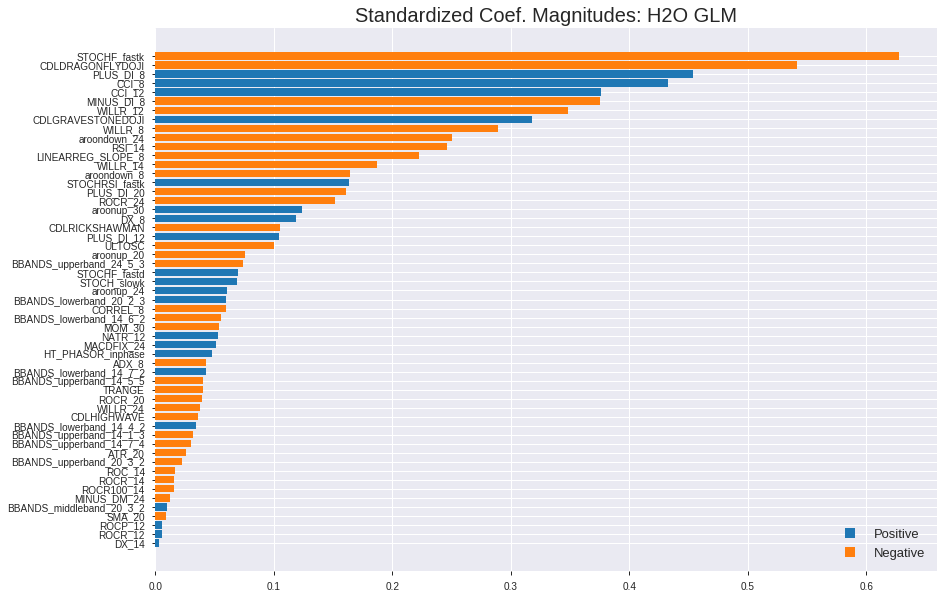

'log_likelihood'
--2019-08-22 13:16:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131602_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131602_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'PLUS_DI_8',
 'CCI_8',
 'CCI_12',
 'MINUS_DI_8',
 'WILLR_12',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'aroondown_24',
 'RSI_14',
 'LINEARREG_SLOPE_8',
 'WILLR_14',
 'aroondown_8',
 'STOCHRSI_fastk',
 'PLUS_DI_20',
 'ROCR_24',
 'aroonup_30',
 'DX_8',
 'CDLRICKSHAWMAN',
 'PLUS_DI_12',
 'ULTOSC',
 'aroonup_20',
 'BBANDS_upperband_24_5_3',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_24',
 'BBANDS_lowerband_20_2_3',
 'CORREL_8',
 'BBANDS_lowerband_14_6_2',
 'MOM_30',
 'NATR_12',
 'MACDFIX_24',
 'HT_PHASOR_inphase',
 'ADX_8',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_5_5',
 'TRANGE',
 'ROCR_20',
 'WILLR_24',
 'CDLHIGHWAVE',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_upperband_14_7_4',
 'ATR_20',
 'BBANDS_upperband_20_3_2',
 'ROC_14',
 'ROCR_14',
 'ROCR100_14',
 'MINUS_DM_24',
 'BBANDS_middleband_20_3_2',
 'SMA_20',
 'ROCP_12',
 'ROCR_12',
 'DX_14']

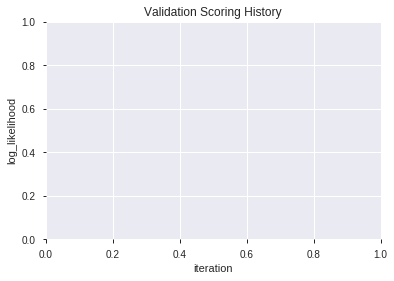

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190822_131619  0.834252  0.512691              0.219363  0.410676  0.168654
1               XGBoost_3_AutoML_20190822_131619  0.830515  0.519633              0.225490  0.414995  0.172221
2  XGBoost_grid_1_AutoML_20190822_131619_model_2  0.829902  0.521932              0.249510  0.415426  0.172579
3  XGBoost_grid_1_AutoML_20190822_131619_model_1  0.827757  0.527040              0.236765  0.418015  0.174737
4  XGBoost_grid_1_AutoML_20190822_131619_model_4  0.820833  0.529203              0.225980  0.418305  0.174979
5               XGBoost_1_AutoML_20190822_131619  0.819730  0.525191              0.252941  0.417075  0.173951
6  XGBoost_grid_1_AutoML_20190822_131619_model_6  0.818076  0.537505              0.236520  0.423065  0.178984
7  XGBoost_grid_1_AutoML_20190822_131619_model_5  0.816422  0.529282              0.256127  0.419156  0.175692
8  XGBoost_grid_1_AutoML_20190822_131619_model_7  0.814767  0.527103              0.240931  0.419882  0.176301
9  XGBoost_grid_1_AutoML_20190822_131619_model_3  0.812255  0.535853              0.250245  0.422037  0.178115

variable  relative_importance  scaled_importance  percentage
0           CDLDRAGONFLYDOJI           967.243774           1.000000    0.111687
1               STOCHF_fastk           690.477234           0.713861    0.079729
2          CDLGRAVESTONEDOJI           516.499573           0.533991    0.059640
3                      CCI_8           465.183899           0.480938    0.053714
4                    WILLR_8           439.025848           0.453894    0.050694
5                aroondown_8           343.316864           0.354943    0.039643
6                 MINUS_DI_8           279.199860           0.288655    0.032239
7                     ULTOSC           275.964966           0.285311    0.031865
8                   WILLR_12           270.192566           0.279343    0.031199
9                  PLUS_DI_8           238.786255           0.246873    0.027572
10                    CCI_12           224.299347           0.231895    0.025900
11                    TRANGE           202.312500           0.209164    0.023361
12                  WILLR_14           169.412750           0.175150    0.019562
13                  CORREL_8           162.134903           0.167626    0.018722
14                    ATR_20           159.022186           0.164408    0.018362
15         LINEARREG_SLOPE_8           150.705856           0.155810    0.017402
16              aroondown_24           144.823746           0.149728    0.016723
17               STOCH_slowk           142.809952           0.147646    0.016490
18                      DX_8           137.680054           0.142343    0.015898
19                     DX_14           127.372200           0.131686    0.014708
20                   ROCR_24           126.652634           0.130942    0.014624
21   BBANDS_upperband_24_5_3           122.894554           0.127056    0.014191
22                    RSI_14           122.470032           0.126618    0.014142
23   BBANDS_upperband_20_3_2           118.087524           0.122087    0.013635
24                PLUS_DI_20           112.226021           0.116027    0.012959
25                   NATR_12           109.605095           0.113317    0.012656
26            STOCHRSI_fastk           108.839722           0.112526    0.012568
27                PLUS_DI_12           103.951530           0.107472    0.012003
28               MINUS_DM_24           101.298187           0.104729    0.011697
29   BBANDS_lowerband_20_2_3           100.772774           0.104185    0.011636
30                   ROCP_12           100.615334           0.104023    0.011618
31                  WILLR_24            98.663406           0.102005    0.011393
32         HT_PHASOR_inphase            97.850548           0.101164    0.011299
33                    MOM_30            88.476837           0.091473    0.010216
34                    ROC_14            83.176163           0.085993    0.009604
35                   ROCR_20            80.520706           0.083248    0.009298
36                MACDFIX_24            77.575462           0.080203    0.008958
37                     ADX_8            75.401138           0.077955    0.008707
38                aroonup_20            74.530731           0.077055    0.008606
39   BBANDS_upperband_14_7_4            72.266777           0.074714    0.008345
40            CDLRICKSHAWMAN            67.341995           0.069623    0.007776
41                aroonup_30            66.730232           0.068990    0.007705
42                aroonup_24            66.704697           0.068964    0.007702
43   BBANDS_upperband_14_1_3            54.906807           0.056766    0.006340
44  BBANDS_middleband_20_3_2            49.392689           0.051065    0.005703
45   BBANDS_lowerband_14_4_2            48.866852           0.050522    0.005643
46   BBANDS_lowerband_14_6_2            37.482719           0.038752    0.004328
47   BBANDS_lowerband_14_7_2            37.453041           0.038721    0.004325
48   BBANDS_upperband_14_5_5            34.903065  

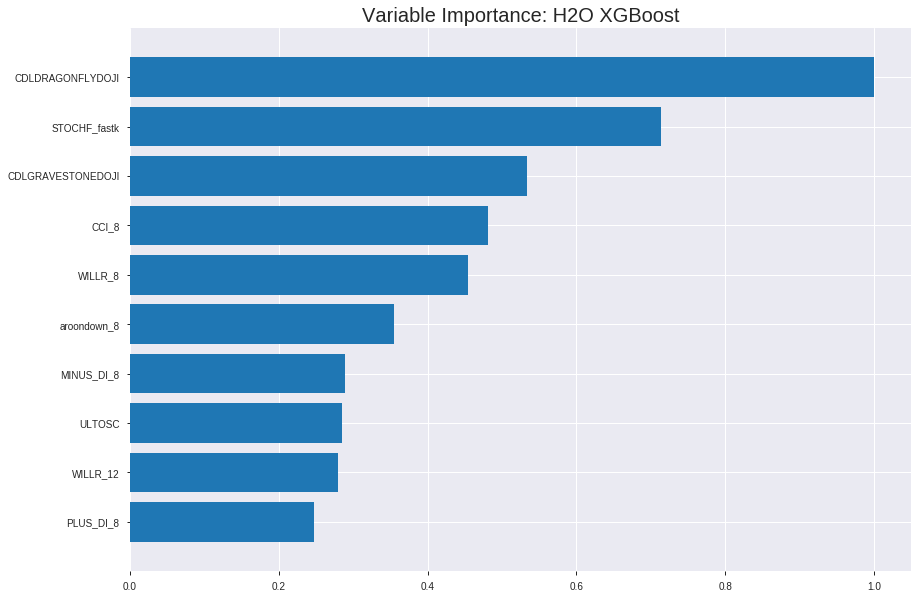

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190822_131619


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12460325017687121
RMSE: 0.3529918556806534
LogLoss: 0.40867468010996577
Mean Per-Class Error: 0.136108844391438
AUC: 0.9297338522377754
pr_auc: 0.929363606722856
Gini: 0.8594677044755508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5300439066357083: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      777  113  0.127    (113.0/890.0)
1      130  765  0.1453   (130.0/895.0)
Total  907  878  0.1361   (243.0/1785.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530044     0.862944  185
max f2                       0.355261     0.903212  266
max f0point5                 0.553266     0.874027  175
max accuracy                 0.530044     0.863866  185
max precision                0.940841     1         0
max recall                   0.137301     1         359
max specificity              0.940841     1         0
max absolute_mcc             0.530044     0.727876  185
max min_per_class_accuracy   0.518458     0.860674  190
max mean_per_class_accuracy  0.530044     0.863891  185

Gains/Lift Table: Avg response rate: 50.14 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010084                    0.924312           1.99441   1.99441            1                0.931947   1                           0.931947            0.0201117       0.0201117                  99.4413   99.4413
    2        0.0201681                   0.914675           1.99441   1.99441            1                0.919615   1                           0.925781            0.0201117       0.0402235                  99.4413   99.4413
    3        0.0302521                   0.901975           1.99441   1.99441            1                0.908778   1                           0.920113            0.0201117       0.0603352                  99.4413   99.4413
    4        0.0403361                   0.889757           1.99441   1.99441            1                0.896365   1                           0.914176            0.0201117       0.0804469                  99.4413   99.4413
    5        0.0504202                   0.880358           1.99441   1.99441            1                0.885022   1                           0.908345            0.0201117       0.100559                   99.4413   99.4413
    6        0.10028                     0.836143           1.972     1.98327            0.988764         0.857679   0.994413                    0.883154            0.098324        0.198883                   97.2004   98.3271
    7        0.15014                     0.798435           1.9496    1.97209            0.977528         0.815615   0.988806                    0.860725            0.0972067       0.296089                   94.9595   97.2088
    8        0.2                         0.762031           1.85996   1.94413            0.932584         0.7809     0.97479                     0.840824            0.0927374       0.388827                   85.9959   94.4134
    9        0.30028                     0.686704           1.805     1.89767            0.905028         0.7244     0.951493                    0.801944            0.181006        0.569832                   80.5      89.7669
    10       0.4                         0.610254           1.51262   1.80168            0.758427         0.648849   0.903361                    0.763777            0.150838        0.72067                    51.2617   80.1676
    11       0.50028                     0.518761           1.39275   1.71971            0.698324         0.566979   0.862262                    0.72433             0.139665        0.860335                   39.2747   71.9707
    12       0.6                         0.421582           0.672274  1.54562            0.337079         0.471178   0.774977                    0.682256            0.0670391       0.927374                   -32.7726  54.5624
    13       0.69972                     0.32486            0.436978  1.38763            0.219101         0.37713    0.695757                    0.638771            0.0435754       0.97095                    -56.3022  38.7626
    14       0.8                         0.224674           0.155988  1.23324            0.0782123        0.27562    0.618347                    0.59325             0.0156425       0.986592                   -84.4012  23.324
    15       0.89972                     0.132793           0.134455  1.11146            0.0674157        0.172438   0.557285                    0.54661             0.0134078       1                          -86.5545  11.1457
    16       1                           0.0494161          0         1                  0                0.0967752  0.501401                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17434397031640642
RMSE: 0.41754517158794496
LogLoss: 0.5260530883826706
Mean Per-Class Error: 0.2333333333333334
AUC: 0.8213687043444828
pr_auc: 0.810196702957987
Gini: 0.6427374086889657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5096781253814697: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      194  61   0.2392   (61.0/255.0)
1      58   197  0.2275   (58.0/255.0)
Total  252  258  0.2333   (119.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.509678     0.768031  204
max f2                       0.238691     0.847994  313
max f0point5                 0.55304      0.781387  175
max accuracy                 0.51638      0.766667  198
max precision                0.932776     1         0
max recall                   0.0996729    1         381
max specificity              0.932776     1         0
max absolute_mcc             0.55304      0.534181  175
max min_per_class_accuracy   0.51163      0.764706  202
max mean_per_class_accuracy  0.51638      0.766667  198

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.912651           2         2                  1                0.921814  1                           0.921814            0.0235294       0.0235294                  100       100
    2        0.0215686                   0.901276           1.6       1.81818            0.8              0.906784  0.909091                    0.914982            0.0156863       0.0392157                  60        81.8182
    3        0.0313725                   0.895438           1.6       1.75               0.8              0.897942  0.875                       0.909657            0.0156863       0.054902                   60        75
    4        0.0411765                   0.884864           1.6       1.71429            0.8              0.890951  0.857143                    0.905203            0.0156863       0.0705882                  60        71.4286
    5        0.0509804                   0.874013           2         1.76923            1                0.881853  0.884615                    0.900713            0.0196078       0.0901961                  100       76.9231
    6        0.1                         0.837909           1.92      1.84314            0.96             0.852123  0.921569                    0.876894            0.0941176       0.184314                   92        84.3137
    7        0.15098                     0.781075           1.84615   1.84416            0.923077         0.812095  0.922078                    0.855014            0.0941176       0.278431                   84.6154   84.4156
    8        0.2                         0.748057           1.6       1.78431            0.8              0.765383  0.892157                    0.833046            0.0784314       0.356863                   60        78.4314
    9        0.3                         0.651472           1.37255   1.64706            0.686275         0.697542  0.823529                    0.787878            0.137255        0.494118                   37.2549   64.7059
    10       0.4                         0.571372           1.52941   1.61765            0.764706         0.609169  0.808824                    0.743201            0.152941        0.647059                   52.9412   61.7647
    11       0.5                         0.511238           1.17647   1.52941            0.588235         0.539792  0.764706                    0.702519            0.117647        0.764706                   17.6471   52.9412
    12       0.6                         0.4294             0.666667  1.38562            0.333333         0.465651  0.69281                     0.663041            0.0666667       0.831373                   -33.3333  38.5621
    13       0.7                         0.344193           0.666667  1.28291            0.333333         0.38138   0.641457                    0.622804            0.0666667       0.898039                   -33.3333  28.2913
    14       0.8                         0.223919           0.470588  1.18137            0.235294         0.280514  0.590686                    0.580017            0.0470588       0.945098                   -52.9412  18.1373
    15       0.9                         0.137903           0.313725  1.08497            0.156863         0.172171  0.542484                    0.534701            0.0313725       0.976471                   -68.6275  8.49673
    16       1                           0.0618766          0.235294  1                  0.117647         0.104929  0.5                         0.491724            0.0235


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:16:21  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.498599                         0.5                0.693147              0.5               0                    1                  0.5
    2019-08-22 13:16:21  0.076 sec   5                  0.471488         0.637391            0.845633        0.80943            1.99441          0.253782                         0.478407           0.650656              0.776201          0.731234             1.73333            0.282353
    2019-08-22 13:16:21  0.140 sec   10                 0.450257         0.596736            0.86046         0.844313           1.99441          0.226331                         0.462825           0.620247              0.791957          0.772491             1.71429            0.270588
    2019-08-22 13:16:21  0.212 sec   15                 0.433923         0.565533            0.872071        0.862589           1.99441          0.203922                         0.451124           0.597196              0.802022          0.787586             1.71429            0.258824
    2019-08-22 13:16:22  0.281 sec   20                 0.420288         0.539081            0.876091        0.868195           1.99441          0.19888                          0.440807           0.576674              0.810158          0.798058             1.66667            0.254902
    2019-08-22 13:16:22  0.364 sec   25                 0.409929         0.518704            0.882083        0.877036           1.99441          0.191036                         0.434234           0.563346              0.815802          0.802561             1.66667            0.247059
    2019-08-22 13:16:22  0.522 sec   30                 0.401688         0.502085            0.885287        0.880827           1.99441          0.183193                         0.429072           0.552334              0.817493          0.803975             1.66667            0.233333
    2019-08-22 13:16:22  0.595 sec   35                 0.394026         0.486731            0.890852        0.886091           1.99441          0.179832                         0.425146           0.543815              0.819723          0.805078             1.66667            0.229412
    2019-08-22 13:16:22  0.672 sec   40                 0.387212         0.473096            0.895126        0.892662           1.99441          0.184874                         0.421831           0.536376              0.821692          0.810863             2                  0.229412
    2019-08-22 13:16:22  0.759 sec   45                 0.381575         0.462129            0.901129        0.898054           1.99441          0.168627                         0.42087            0.533776              0.821584          0.812159             1.66667            0.247059
    2019-08-22 13:16:22  0.833 sec   50                 0.376223         0.451883            0.906315        0.903646           1.99441          0.160784                         0.419703           0.531343              0.822191          0.811419             2                  0.237255
    2019-08-22 13:16:22  0.907 sec   55                 0.371085         0.442165            0.911909        0.90943            1.99441          0.165826                         0.41882            0.529108              0.823345          0.8144

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLDRAGONFLYDOJI   967.2437744140625      1.0                   0.11168697993071501
STOCHF_fastk       690.4772338867188      0.7138606131685846    0.07972893597628762
CDLGRAVESTONEDOJI  516.4995727539062      0.5339911058789617    0.05963985392548392
CCI_8              465.18389892578125     0.48093759942531616   0.05371446801494154
WILLR_8            439.0258483886719      0.4538936925746823    0.05069401573326668
---                ---                    ---                   ---
ROCR_12            23.42881202697754      0.02422224122473185   0.002705308969543564
ROCR_14            21.265289306640625     0.021985449655153092  0.0024554884744028287
SMA_20             16.861215591430664     0.01743222963791611   0.001946953081717552
CDLHIGHWAVE        14.87365436553955      0.01537735859251172   0.0017174507405092645
ROCR100_14         4.81951904296875       0.004982734622291388  0.0005565065817599371


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7782101167315175)

('auc', 0.8342524509803921)

('logloss', 0.5126907969549216)

('mean_per_class_error', 0.21666666666666667)

('rmse', 0.41067554571844916)

('mse', 0.16865440385114605)

xgboost prediction progress: |████████████████████████████████████████████| 100%


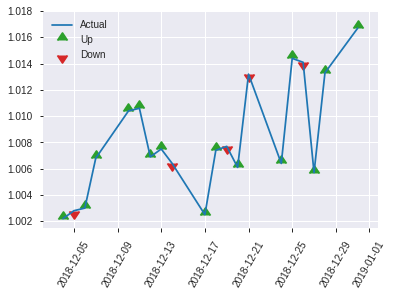


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16865440385114605
RMSE: 0.41067554571844916
LogLoss: 0.5126907969549216
Mean Per-Class Error: 0.21666666666666667
AUC: 0.8342524509803921
pr_auc: 0.8117317051390971
Gini: 0.6685049019607843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4702702760696411: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      99   37   0.2721   (37.0/136.0)
1      20   100  0.1667   (20.0/120.0)
Total  119  137  0.2227   (57.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47027      0.77821   136
max f2                       0.343529     0.839695  174
max f0point5                 0.614917     0.778689  91
max accuracy                 0.495024     0.78125   131
max precision                0.925411     1         0
max recall                   0.102231     1         242
max specificity              0.925411     1         0
max absolute_mcc             0.495024     0.565835  131
max min_per_class_accuracy   0.512914     0.764706  123
max mean_per_class_accuracy  0.495024     0.783333  131

Gains/Lift Table: Avg response rate: 46.88 %, avg score: 48.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.89865            2.13333   2.13333            1                0.909446  1                           0.909446            0.025           0.025                      113.333   113.333
    2        0.0234375                   0.887668           2.13333   2.13333            1                0.890925  1                           0.900186            0.025           0.05                       113.333   113.333
    3        0.03125                     0.883258           2.13333   2.13333            1                0.884741  1                           0.896325            0.0166667       0.0666667                  113.333   113.333
    4        0.0429688                   0.874381           2.13333   2.13333            1                0.879062  1                           0.891617            0.025           0.0916667                  113.333   113.333
    5        0.0507812                   0.867548           2.13333   2.13333            1                0.868305  1                           0.88803             0.0166667       0.108333                   113.333   113.333
    6        0.101562                    0.81716            1.80513   1.96923            0.846154         0.847368  0.923077                    0.867699            0.0916667       0.2                        80.5128   96.9231
    7        0.152344                    0.778675           1.80513   1.91453            0.846154         0.795557  0.897436                    0.843652            0.0916667       0.291667                   80.5128   91.453
    8        0.203125                    0.740674           1.47692   1.80513            0.692308         0.758027  0.846154                    0.822246            0.075           0.366667                   47.6923   80.5128
    9        0.300781                    0.656986           1.792     1.80087            0.84             0.698362  0.844156                    0.782024            0.175           0.541667                   79.2      80.0866
    10       0.402344                    0.573146           1.31282   1.67767            0.615385         0.615218  0.786408                    0.739917            0.133333        0.675                      31.2821   67.767
    11       0.5                         0.498074           1.19467   1.58333            0.56             0.535911  0.742188                    0.700072            0.116667        0.791667                   19.4667   58.3333
    12       0.601562                    0.410768           0.574359  1.41299            0.269231         0.460107  0.662338                    0.659559            0.0583333       0.85                       -42.5641  41.2987
    13       0.699219                    0.327172           0.682667  1.31099            0.32             0.370234  0.614525                    0.61915             0.0666667       0.916667                   -31.7333  31.0987
    14       0.800781                    0.200113           0.164103  1.16553            0.0769231        0.262198  0.546341                    0.573878            0.0166667       0.933333                   -83.5897  16.5528
    15       0.898438                    0.132937           0.512     1.09449            0.24             0.168732  0.513043                    0.529841            0.05            0.983333                   -48.8     9.44928
    16       1                           0.0660041          0.164103  1                  0.0769231        0.101016  0.46875                     0.486288           

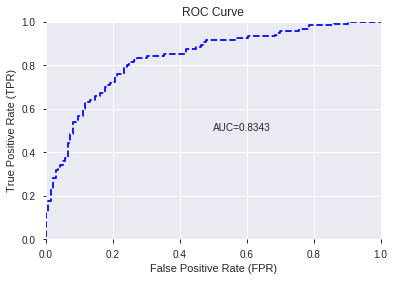

This function is available for GLM models only


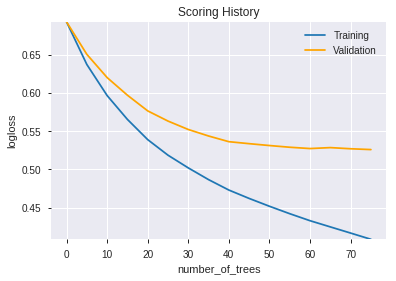

--2019-08-22 13:16:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


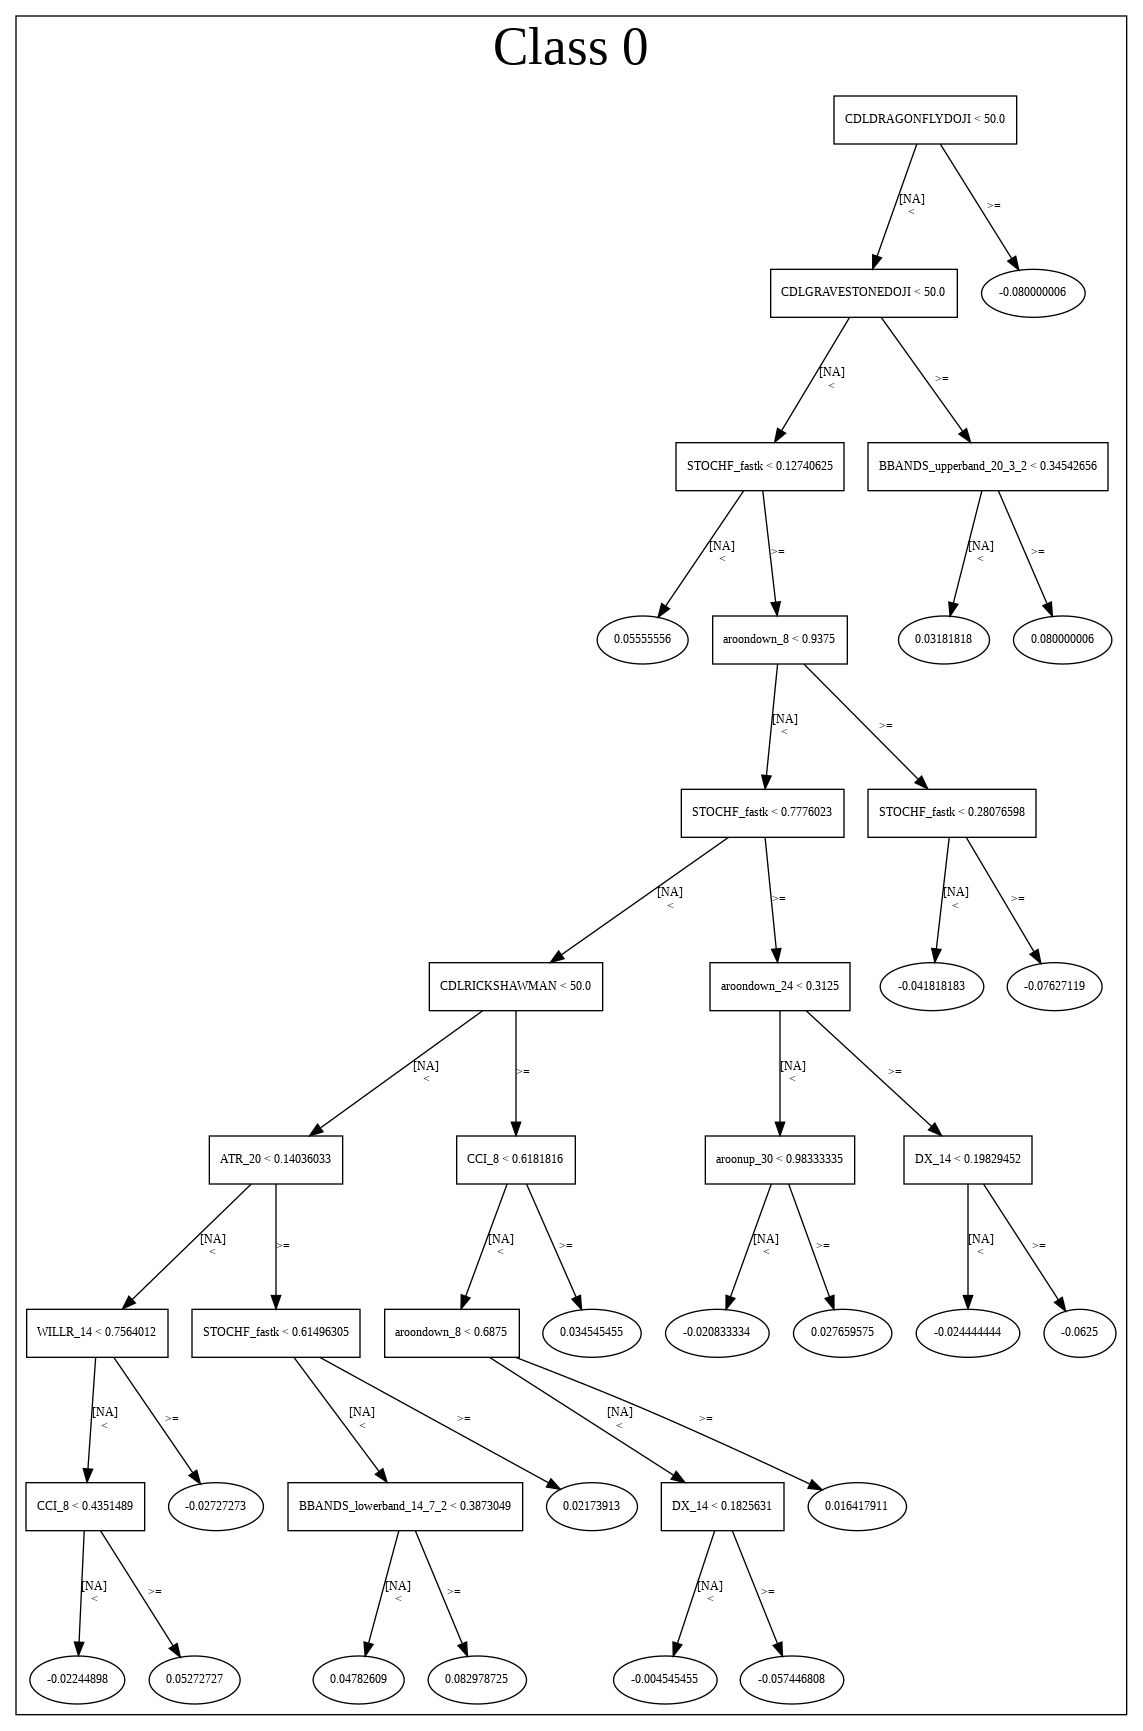

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190822_131619',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190822_131619',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_ad7e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_ad7e',
   'ty

['CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'WILLR_8',
 'aroondown_8',
 'MINUS_DI_8',
 'ULTOSC',
 'WILLR_12',
 'PLUS_DI_8',
 'CCI_12',
 'TRANGE',
 'WILLR_14',
 'CORREL_8',
 'ATR_20',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'STOCH_slowk',
 'DX_8',
 'DX_14',
 'ROCR_24',
 'BBANDS_upperband_24_5_3',
 'RSI_14',
 'BBANDS_upperband_20_3_2',
 'PLUS_DI_20',
 'NATR_12',
 'STOCHRSI_fastk',
 'PLUS_DI_12',
 'MINUS_DM_24',
 'BBANDS_lowerband_20_2_3',
 'ROCP_12',
 'WILLR_24',
 'HT_PHASOR_inphase',
 'MOM_30',
 'ROC_14',
 'ROCR_20',
 'MACDFIX_24',
 'ADX_8',
 'aroonup_20',
 'BBANDS_upperband_14_7_4',
 'CDLRICKSHAWMAN',
 'aroonup_30',
 'aroonup_24',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_20_3_2',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_5_5',
 'STOCHF_fastd',
 'ROCR_12',
 'ROCR_14',
 'SMA_20',
 'CDLHIGHWAVE',
 'ROCR100_14']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.766
GLM             0.750
XGBoost         0.781
dtype: float64

DeepLearning    GLM  XGBoost
All          0.758  0.742    0.762
DLF          0.754  0.738    0.777
Fwe          0.750  0.738    0.773
RFE          0.766  0.750    0.781
XGBF         0.758  0.738    0.777





F1


DeepLearning    0.761
GLM             0.750
XGBoost         0.778
dtype: float64

DeepLearning    GLM  XGBoost
All          0.739  0.722    0.756
DLF          0.761  0.728    0.761
Fwe          0.750  0.750    0.758
RFE          0.758  0.728    0.778
XGBF         0.758  0.728    0.761





auc


DeepLearning    0.832
GLM             0.818
XGBoost         0.834
dtype: float64

DeepLearning    GLM  XGBoost
All          0.812  0.798    0.829
DLF          0.832  0.801    0.824
Fwe          0.811  0.818    0.822
RFE          0.829  0.805    0.834
XGBF         0.823  0.801    0.824





logloss


DeepLearning    0.555
GLM             0.541
XGBoost         0.530
dtype: float64

DeepLearning    GLM  XGBoost
All          0.536  0.537    0.513
DLF          0.532  0.541    0.530
Fwe          0.555  0.519    0.529
RFE          0.527  0.533    0.513
XGBF         0.528  0.541    0.530





mean_per_class_error


DeepLearning    0.251
GLM             0.267
XGBoost         0.239
dtype: float64

DeepLearning    GLM  XGBoost
All          0.247  0.267    0.239
DLF          0.247  0.264    0.224
Fwe          0.251  0.265    0.227
RFE          0.239  0.254    0.217
XGBF         0.239  0.264    0.224





rmse


DeepLearning    0.429
GLM             0.429
XGBoost         0.420
dtype: float64

DeepLearning    GLM  XGBoost
All          0.425  0.427    0.413
DLF          0.424  0.429    0.420
Fwe          0.429  0.419    0.419
RFE          0.417  0.425    0.411
XGBF         0.420  0.429    0.420





mse


DeepLearning    0.184
GLM             0.184
XGBoost         0.176
dtype: float64

DeepLearning    GLM  XGBoost
All          0.181  0.182    0.171
DLF          0.180  0.184    0.176
Fwe          0.184  0.175    0.176
RFE          0.174  0.181    0.169
XGBF         0.177  0.184    0.176

{'F1':       DeepLearning    GLM  XGBoost
 All          0.739    NaN      NaN
 DLF          0.761    NaN      NaN
 DLF            NaN  0.728      NaN
 DLF            NaN    NaN    0.761
 All            NaN  0.722      NaN
 All            NaN    NaN    0.756
 XGBF         0.758    NaN      NaN
 XGBF           NaN  0.728      NaN
 XGBF           NaN    NaN    0.761
 Fwe          0.750    NaN      NaN
 Fwe            NaN  0.750      NaN
 Fwe            NaN    NaN    0.758
 RFE          0.758    NaN      NaN
 RFE            NaN  0.728      NaN
 RFE            NaN    NaN    0.778,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.758    NaN      NaN
 DLF          0.754    NaN      NaN
 DLF            NaN  0.738      NaN
 DLF            NaN    NaN    0.777
 All            NaN  0.742      NaN
 All            NaN    NaN    0.762
 XGBF         0.758    NaN      NaN
 XGBF           NaN  0.738      NaN
 XGBF           NaN    NaN    0.777
 Fwe          0.750    NaN      NaN
 Fwe     